In [1]:
#!pip install joblib
#!pip install pandas
#!pip install scipy
#!pip install cryptocmd
#!pip install prettytable
#!pip install scikit-learn
#!pip install lightgbm
#!pip install xgboost
#!pip install statsmodels
#!pip install arch
#!pip install bokeh
#!pip install matplotlib
#!pip install keras_tuner
#!pip install keras-tcn
#!pip install keras-beats
#!pip install openpyxl

# Within WSL Miniconda
#conda create -n tf_gpu python=3.9
#conda activate tf_gpu
#conda install -c "nvidia/label/cuda-11.8.0" cuda-toolkit
#python3 -m pip install nvidia-cudnn-cu11==8.7.0.84
#mkdir -p $CONDA_PREFIX/etc/conda/activate.d
#echo 'CUDNN_PATH=$(dirname $(python -c "import nvidia.cudnn;print(nvidia.cudnn.__file__)"))' >> $CONDA_PREFIX/etc/conda/activate.d/env_vars.sh
#echo 'export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/:$CUDNN_PATH/lib' >> $CONDA_PREFIX/etc/conda/activate.d/env_vars.sh
#source $CONDA_PREFIX/etc/conda/activate.d/env_vars.sh

In [2]:
# Standard library imports
import os
import sys
import time
import json
import warnings
import logging
import pickle
import hashlib
from abc import abstractmethod
from datetime import datetime, timedelta
from math import pi
from typing import Optional
from joblib import dump, load

# Third-party imports
import requests
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.signal import detrend
from scipy.stats import jarque_bera, kstest
#from scipy.stats import boxcox, invboxcox  # Uncomment if needed
from cryptocmd import CmcScraper
from prettytable import PrettyTable
from pandas.tseries.holiday import USFederalHolidayCalendar
from arch import arch_model

# Plotting and Visualization
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show, output_notebook, save
from bokeh.models import (HoverTool, ColumnDataSource, WheelZoomTool, Span, Range1d,
                          FreehandDrawTool, MultiLine, NumeralTickFormatter, Button, CustomJS)
from bokeh.layouts import column, row
from bokeh.io import curdoc, export_png
from bokeh.models.widgets import CheckboxGroup
from bokeh.themes import Theme
from IPython.display import display, HTML

# Machine Learning Libraries
import sklearn
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, accuracy_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
import xgboost as xgb
from statsmodels.tsa.api import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, grangercausalitytests, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import (Dense, Dropout, LSTM, TimeDistributed, Conv1D, MaxPooling1D, Flatten,
                                    ConvLSTM2D, BatchNormalization, GRU, Bidirectional, Attention, Input,
                                    Reshape, GlobalAveragePooling1D, GlobalMaxPooling1D, Lambda, LayerNormalization, 
                                    SimpleRNN, Layer, Multiply, Add, Activation)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1, l2, l1_l2
from keras_tuner import HyperModel, RandomSearch, BayesianOptimization
from tcn import TCN
from kerasbeats import NBeatsModel

2023-10-15 02:34:03.010282: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-15 02:34:03.010539: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-15 02:34:03.011653: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-15 02:34:03.308751: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using TensorFlow backend


In [3]:
!nvidia-smi

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

# Detailed device placement information
warnings.filterwarnings('ignore')
print(tf.test.gpu_device_name())
print(tf.sysconfig.get_build_info())

/bin/bash: /home/ova/miniconda3/envs/tf_gpu/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Sun Oct 15 02:34:11 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.120                Driver Version: 537.58       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050 Ti     On  | 00000000:01:00.0 Off |                  N/A |
| N/A   48C    P3              N/A / ERR! |   3350MiB /  4096MiB |     18%      Default |
|                                     

2023-10-15 02:34:11.621701: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-15 02:34:11.790580: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-15 02:34:11.790904: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-15 02:34:11.801487: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-15 02:34:11.801751: I tensorflow/compile

In [4]:
# Other settings
from IPython.display import display, HTML
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.3f}'.format)
logging.basicConfig(level=logging.INFO, format='%(asctime)s [%(levelname)s] - %(message)s')
logger = logging.getLogger(__name__)
display(HTML("<style>.bk-root { margin-left: auto; margin-right: auto; }</style>"))

print("Hello Everyone")
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tf.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sklearn.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Hello Everyone
Tensor Flow Version: 2.14.0
Keras Version: 2.14.0

Python 3.9.18 (main, Sep 11 2023, 13:41:44) 
[GCC 11.2.0]
Pandas 2.1.1
Scikit-Learn 1.3.1
GPU is available


# ------------------------------------------------------------------------------------------------------------------------------------------------

In [5]:
class CryptoData:
    """
    The CryptoData class is responsible for fetching and validating cryptocurrency data. 
    It provides methods to fetch raw data, validate its integrity, and format it for display.
    
    Attributes:
    - EXPECTED_COLUMNS: A set of expected columns in the fetched data.
    - crypto_symbol: The cryptocurrency symbol to fetch.
    - retries: The maximum number of data fetch retries.
    - backoff_factor: The exponential backoff factor for retries.
    """
    
    EXPECTED_COLUMNS = {'Date', 'Open', 'High', 'Low', 'Close', 'Market Cap', 'Volume'}

    def __init__(self, crypto_symbol: str, retries: int = 5, backoff_factor: float = 0.3):
        """Initializes the class with the given cryptocurrency symbol."""
        logger.info("Initializing CryptoData class.")
        self.crypto_symbol = crypto_symbol
        self.retries = retries
        self.backoff_factor = backoff_factor
        logger.info("CryptoData class initialized.")

    def _validate_data(self, df: pd.DataFrame) -> Optional[pd.DataFrame]:
        """Validates the integrity of the fetched data."""
        logger.info("Starting data validation.")
        if df.isnull().any().any():
            raise ValueError("The fetched data contains missing values.")
        if not self.EXPECTED_COLUMNS.issubset(df.columns):
            raise ValueError("Some expected columns are missing in the data.")
        for col in df.columns:
            if col != 'Date' and not pd.api.types.is_numeric_dtype(df[col]):
                raise ValueError(f"Column {col} is not of numeric type in the fetched data.")
        logger.info("Data validation completed.")
        return df

    def _fetch_cryptocmd_data(self) -> pd.DataFrame:
        """Fetches cryptocurrency data with retries and exponential backoff."""
        logger.info(f"Fetching data for {self.crypto_symbol}.")
        for retry in range(self.retries):
            try:
                scraper = CmcScraper(self.crypto_symbol)
                df = scraper.get_dataframe()
                
                # Drop unwanted columns
                unwanted_columns = ['Time Open', 'Time Close', 'Time High', 'Time Low']
                for col in unwanted_columns:
                    if col in df.columns:
                        df.drop(columns=[col], inplace=True)
    
                return self._validate_data(df)
            except Exception as e:
                logger.error(f'An error occurred while fetching data: {e}')
                sleep_time = self.backoff_factor * (2 ** retry)
                time.sleep(sleep_time)
                logger.info(f'Retrying... (Attempt {retry + 1}/{self.retries})')
        else:
            raise Exception('Max retries reached. Could not fetch the data.')
        logger.info(f"Data fetched successfully for {self.crypto_symbol}.")


    def get_cryptocmd_data(self) -> pd.DataFrame:
        """Fetches and returns the cryptocurrency data."""
        logger.info(f"Getting {self.crypto_symbol} data.")
        df = self._fetch_cryptocmd_data()
        df.set_index('Date', inplace=True)
        df.index = pd.to_datetime(df.index)
        df = df.iloc[::-1]  # Reversing the DataFrame
        logger.info(f"Data obtained successfully for {self.crypto_symbol}.")
        return df.round(2)

    @staticmethod
    def _format_monetary_value(value: float) -> str:
        """Formats a monetary value to a string."""
        return "${:,.2f}".format(value)

    @staticmethod
    def _format_volume_value(value: float) -> str:
        """Formats a volume value to a string."""
        if value > 1e9:
            return "{:.2f}B".format(value/1e9)
        elif value > 1e6:
            return "{:.2f}M".format(value/1e6)
        else:
            return "{:,.2f}".format(value)

    def get_display_data(self) -> pd.DataFrame:
        """Fetches and formats the cryptocurrency data for display."""
        logger.info(f"Formatting display data for {self.crypto_symbol}.")
        display_df = self.get_cryptocmd_data().copy()
        monetary_columns = ['Open', 'High', 'Low', 'Close']
        display_df[monetary_columns] = display_df[monetary_columns].applymap(self._format_monetary_value)
        volume_like_columns = ['Volume', 'Market Cap']
        display_df[volume_like_columns] = display_df[volume_like_columns].applymap(self._format_volume_value)
        logger.info(f"Display data formatted successfully for {self.crypto_symbol}.")
        return display_df


In [6]:
# Initialize CryptoData class for different cryptocurrencies
crypto_symbols = ['BTC']
crypto_data_objects = {}

for symbol in crypto_symbols:
    crypto_data_objects[symbol] = CryptoData(symbol)

# Fetch and save data
data_c = {}
display_data = {}

for symbol, crypto_data_object in crypto_data_objects.items():
    data_c[symbol] = crypto_data_object.get_cryptocmd_data()
    display_data[symbol] = crypto_data_object.get_display_data()

# Now, data['BTC'], data['ETH'], etc. contain the data
# And display_data['BTC'], display_data['ETH'], etc. contain the display data


2023-10-15 02:34:16,904 [INFO] - Initializing CryptoData class.
2023-10-15 02:34:16,907 [INFO] - CryptoData class initialized.
2023-10-15 02:34:16,910 [INFO] - Getting BTC data.
2023-10-15 02:34:16,912 [INFO] - Fetching data for BTC.
2023-10-15 02:34:19,919 [INFO] - Starting data validation.
2023-10-15 02:34:19,931 [INFO] - Data validation completed.
2023-10-15 02:34:19,958 [INFO] - Data obtained successfully for BTC.
2023-10-15 02:34:19,966 [INFO] - Formatting display data for BTC.
2023-10-15 02:34:19,969 [INFO] - Getting BTC data.
2023-10-15 02:34:19,972 [INFO] - Fetching data for BTC.
2023-10-15 02:34:21,092 [INFO] - Starting data validation.
2023-10-15 02:34:21,098 [INFO] - Data validation completed.
2023-10-15 02:34:21,115 [INFO] - Data obtained successfully for BTC.
2023-10-15 02:34:21,187 [INFO] - Display data formatted successfully for BTC.


In [7]:
data = data_c['BTC'].copy()
data

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2013-04-28,136.690,143.370,110.850,127.950,25956.840,1419007893.660
2013-04-29,134.440,147.490,134.000,144.540,0.000,1603768864.500
2013-04-30,144.000,146.930,134.050,139.000,0.000,1542813125.000
2013-05-01,139.000,139.890,107.720,116.990,0.000,1298954593.750
2013-05-02,116.380,125.600,92.280,105.210,0.000,1168517495.250
...,...,...,...,...,...,...
2023-10-09,27934.470,27989.470,27302.560,27583.680,12007668568.180,538127916933.080
2023-10-10,27589.200,27715.850,27301.660,27391.020,9973350678.170,534398434701.940
2023-10-11,27392.080,27474.120,26561.100,26873.320,13648094333.060,524325019033.960


# ------------------------------------------------------------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------------------------------------------------------------

In [8]:
class CryptoDataAnalytics:
    """
    This class is responsible for performing enhanced analytics on cryptocurrency data.

    Attributes:
        df (pd.DataFrame): The DataFrame containing the cryptocurrency data.
        output_dir (str): The directory where analytics files will be saved.
    """
    
    def __init__(self, crypto_data: pd.DataFrame):
        logger.info("Initializing CryptoDataAnalytics class.")
        self.df = crypto_data
        self.output_dir = 'analytics_csv'
        self._create_output_dir()
        logger.info("CryptoDataAnalytics class initialized successfully.")
        
    def _create_output_dir(self):
        """Create output directory if it doesn't exist."""
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)
            logger.info(f"Created output directory: {self.output_dir}")
            
    def calculate_historical_volatility(self, column: str = 'Close', window: int = 30) -> pd.DataFrame:
        """Calculates historical volatility."""
        logger.info("Initiating historical volatility calculation.")
        if len(self.df) < window:
            logger.error("Data length is less than the rolling window size. Cannot calculate volatility.")
            raise ValueError("Insufficient data for volatility calculation.")
        
        log_ret = np.log(self.df[column] / self.df[column].shift(1))
        volatility = log_ret.rolling(window=window).std()
        logger.info("Historical volatility calculation successful.")
        return pd.DataFrame(volatility, columns=['Historical Volatility'])
        
    def perform_time_analysis(self, freq: str):
        """Performs time-based analysis."""
        logger.info(f"Initiating {freq}-based time analysis.")
        data = self.df.resample(freq).agg({'Close': ['last', 'mean', 'max', 'min'], 'Open': 'first'})
        data.columns = data.columns.map('_'.join).str.strip('_')
        data = self.calculate_price_variation(data)
        
        # Reorder columns
        ordered_columns = ['Close_mean', 'Close_max', 'Close_min', 'Close_last', 'Open_first', 'variation_$_abs', 'variation_%_rel']
        data = data[ordered_columns]
        
        logger.info(f"{freq}-based time analysis successful.")
        return data

    def calculate_price_variation(self, data: pd.DataFrame):
        """Calculates price variation."""
        logger.info("Initiating price variation calculation.")
        data['variation_$_abs'] = data['Close_last'] - data['Open_first']
        data['variation_%_rel'] = ((data['Close_last'] - data['Open_first']) / data['Open_first']) * 100
        logger.info("Price variation calculation successful.")
        return data
    
    def retrieve_all_time_records(self):
        """Retrieves all-time price records."""
        logger.info("Initiating retrieval of all-time records.")
        all_time_high = self.df['Close'].max()
        all_time_low = self.df['Close'].min()
        all_time_high_date = self.df['Close'].idxmax().strftime('%Y-%m-%d')
        all_time_low_date = self.df['Close'].idxmin().strftime('%Y-%m-%d')
        logger.info("All-time records retrieval successful.")
        return all_time_high, all_time_low, all_time_high_date, all_time_low_date
    
    def perform_and_save_all_analyses(self):
        """Performs all analyses and saves them to Excel files."""
        logger.info("Initiating all analyses.")
        self.save_analysis_to_excel(self.perform_time_analysis('Y'), 'yearly_data.xlsx')
        self.save_analysis_to_excel(self.perform_time_analysis('M'), 'monthly_data.xlsx')
        self.save_analysis_to_excel(self.perform_time_analysis('W'), 'weekly_data.xlsx')
        logger.info("All analyses have been successfully performed and saved.")
        
    def save_analysis_to_excel(self, analysis: pd.DataFrame, filename: str):
        """Saves the given DataFrame to an Excel file in the output directory."""
        filepath = os.path.join(self.output_dir, filename)
        analysis.to_excel(filepath)
        logger.info(f"Analysis saved to {filepath}.")


In [9]:
analytics = CryptoDataAnalytics(data)

# Retrieve and display all-time records
all_time_high, all_time_low, all_time_high_date, all_time_low_date = analytics.retrieve_all_time_records()
print(f"All Time High: {all_time_high} on {all_time_high_date}")
print(f"All Time Low: {all_time_low} on {all_time_low_date}")

# Run all analyses and save them
analytics.perform_and_save_all_analyses()

# Additionally, display the DataFrames
yearly_data = analytics.perform_time_analysis('Y')
monthly_data = analytics.perform_time_analysis('M')
weekly_data = analytics.perform_time_analysis('W')

display(yearly_data)
display(monthly_data)
display(weekly_data)


2023-10-15 02:34:22,649 [INFO] - Initializing CryptoDataAnalytics class.
2023-10-15 02:34:22,656 [INFO] - CryptoDataAnalytics class initialized successfully.
2023-10-15 02:34:22,658 [INFO] - Initiating retrieval of all-time records.
2023-10-15 02:34:22,666 [INFO] - All-time records retrieval successful.
2023-10-15 02:34:22,671 [INFO] - Initiating all analyses.
2023-10-15 02:34:22,673 [INFO] - Initiating Y-based time analysis.
2023-10-15 02:34:22,732 [INFO] - Initiating price variation calculation.
2023-10-15 02:34:22,740 [INFO] - Price variation calculation successful.
2023-10-15 02:34:22,745 [INFO] - Y-based time analysis successful.


All Time High: 67566.83 on 2021-11-08
All Time Low: 68.43 on 2013-07-05


2023-10-15 02:34:23,341 [INFO] - Analysis saved to analytics_csv/yearly_data.xlsx.
2023-10-15 02:34:23,345 [INFO] - Initiating M-based time analysis.
2023-10-15 02:34:23,376 [INFO] - Initiating price variation calculation.
2023-10-15 02:34:23,387 [INFO] - Price variation calculation successful.
2023-10-15 02:34:23,398 [INFO] - M-based time analysis successful.
2023-10-15 02:34:23,500 [INFO] - Analysis saved to analytics_csv/monthly_data.xlsx.
2023-10-15 02:34:23,502 [INFO] - Initiating W-based time analysis.
2023-10-15 02:34:23,557 [INFO] - Initiating price variation calculation.
2023-10-15 02:34:23,562 [INFO] - Price variation calculation successful.
2023-10-15 02:34:23,565 [INFO] - W-based time analysis successful.
2023-10-15 02:34:23,940 [INFO] - Analysis saved to analytics_csv/weekly_data.xlsx.
2023-10-15 02:34:23,942 [INFO] - All analyses have been successfully performed and saved.
2023-10-15 02:34:23,944 [INFO] - Initiating Y-based time analysis.
2023-10-15 02:34:23,955 [INFO] - 

,Close_mean,Close_max,Close_min,Close_last,Open_first,variation_$_abs,variation_%_rel
Date,,,,,,,
2013-12-31,257.449,1151.170,68.430,754.010,136.690,617.320,451.620
2014-12-31,527.237,953.290,310.740,320.190,754.970,-434.780,-57.589
2015-12-31,272.453,465.320,178.100,430.570,320.430,110.140,34.373
2016-12-31,568.492,975.920,364.330,963.740,430.720,533.020,123.751
2017-12-31,4006.034,19497.400,777.760,14156.400,963.660,13192.740,1369.024
2018-12-31,7572.299,17527.000,3236.760,3742.700,14112.200,-10369.500,-73.479
2019-12-31,7395.247,13016.230,3399.470,7193.600,3746.710,3446.890,91.998
2020-12-31,11116.378,29001.720,4970.790,29001.720,7194.890,21806.830,303.088
2021-12-31,47436.932,67566.830,29374.150,46306.450,28994.010,17312.440,59.710


,Close_mean,Close_max,Close_min,Close_last,Open_first,variation_$_abs,variation_%_rel
Date,,,,,,,
2013-04-30,137.163,144.540,127.950,139.000,136.690,2.310,1.690
2013-05-31,119.993,133.480,97.750,129.000,139.000,-10.000,-7.194
2013-06-30,107.761,129.300,94.650,96.610,128.820,-32.210,-25.004
2013-07-31,90.512,107.990,68.430,106.090,97.510,8.580,8.799
2013-08-31,113.905,135.350,102.800,135.350,106.210,29.140,27.436
...,...,...,...,...,...,...,...
2023-06-30,27763.199,30695.470,25124.680,30477.250,27218.410,3258.840,11.973
2023-07-31,30057.470,31476.050,29176.920,29230.110,30471.850,-1241.740,-4.075
2023-08-31,27852.792,29765.490,25931.470,25931.470,29230.870,-3299.400,-11.287


,Close_mean,Close_max,Close_min,Close_last,Open_first,variation_$_abs,variation_%_rel
Date,,,,,,,
2013-04-28,127.950,127.950,127.950,127.950,136.690,-8.740,-6.394
2013-05-05,118.843,144.540,97.750,115.910,134.440,-18.530,-13.783
2013-05-12,113.926,117.200,111.500,115.000,115.980,-0.980,-0.845
2013-05-19,118.709,123.500,111.500,121.990,114.820,7.170,6.245
2013-05-26,127.733,133.480,122.000,133.480,122.500,10.980,8.963
...,...,...,...,...,...,...,...
2023-09-17,26210.736,26608.690,25162.660,26534.190,25831.720,702.470,2.719
2023-09-24,26725.833,27211.120,26256.830,26256.830,26532.990,-276.160,-1.041
2023-10-01,26821.913,27983.750,26217.250,27983.750,26253.780,1729.970,6.589


# ------------------------------------------------------------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------------------------------------------------------------

In [10]:
class CryptoAnalyticsVisual:
    """
    The CryptoAnalyticsVisual class provides tools for cryptocurrency market analysis and visualization.
    
    Attributes:
        data (pd.DataFrame): Raw crypto data with 'Open', 'Close', 'High', 'Low', 'Volume'.
    
    Methods:
        _create_visualizations_directory: Creates directory for visualizations.
        save_plot_to_file: Saves Bokeh plot to file.
        calculate_macd, plot_macd_bokeh: Handles MACD calculation and plotting.
        calculate_rsi, plot_rsi_bokeh: Handles RSI calculation and plotting.
        calculate_bollinger_bands, plot_bollinger_bands_bokeh: Handles Bollinger Bands.
        calculate_fibonacci_retracement, plot_fibonacci_retracement_bokeh: Handles Fibonacci retracement.
        volume_analysis, plot_volume_analysis_bokeh: Handles volume analysis.
        create_candlestick_chart, plot_trend_bokeh: Plots candlestick and trend data.

    Example:
        >>> df = pd.read_csv('crypto_data.csv')
        >>> analytics = CryptoAnalyticsVisual(df)
        >>> analytics.plot_macd_bokeh()
    """
    def __init__(self, data: pd.DataFrame):
        self.data = data
        output_notebook()
        curdoc().theme = 'dark_minimal'
        self._create_visualizations_directory()
        logger.info('CryptoAnalyticsVisual instance created and initialized.')

    def _create_visualizations_directory(self):
        """Creates a directory for storing visualization assets."""
        if not os.path.exists('visualizations_assets'):
            os.makedirs('visualizations_assets')
            logger.info("Created directory: visualizations_assets")

    def save_plot_to_file(self, plot, filename: str, format: str = 'html'):
        """Saves plot to a file."""
        full_path = os.path.join('visualizations_assets', filename)
        if format == 'html':
            save(plot, filename=full_path)
            logger.info(f'Plot saved to file: {full_path}')
        else:
            logger.error('Unsupported file format: {}'.format(format))

    def calculate_macd(self, short_window=12, long_window=26, signal_window=9):
        """Calculates MACD and signal line."""
        short_ema = self.data['Close'].ewm(span=short_window, adjust=False).mean()
        long_ema = self.data['Close'].ewm(span=long_window, adjust=False).mean()
        macd_line = short_ema - long_ema
        signal_line = macd_line.ewm(span=signal_window, adjust=False).mean()
        logger.info(f'MACD calculated with short_window={short_window}, long_window={long_window}, and signal_window={signal_window}')
        return macd_line, signal_line

    def plot_macd_bokeh(self, display=True):
        """Plots MACD and signal line."""
        macd_line, signal_line = self.calculate_macd()
        source = ColumnDataSource(data=dict(x=self.data.index, y1=macd_line, y2=signal_line))
        p = figure(width=1400, height=600, title="MACD Analysis", x_axis_type="datetime")
        p.line(x='x', y='y1', source=source, legend_label="MACD Line", color="blue", alpha=0.8)
        p.line(x='x', y='y2', source=source, legend_label="Signal Line", color="red", alpha=0.8)
        hover = HoverTool(tooltips=[("Date", "@x{%F}"), ("MACD", "@y1"), ("Signal", "@y2")], formatters={"@x": "datetime"})
        p.add_tools(hover)
        logger.info('MACD plot displayed.')
        if display:
            show(p)
        return p

    def calculate_rsi(self, window=14):
        """Calculates the Relative Strength Index (RSI)."""
        delta = self.data['Close'].diff()
        gain = (delta.where(delta > 0, 0)).fillna(0)
        loss = (-delta.where(delta < 0, 0)).fillna(0)
        avg_gain = gain.rolling(window=window, min_periods=1).mean()
        avg_loss = loss.rolling(window=window, min_periods=1).mean()
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        logger.info(f'RSI calculated with window={window}')
        return rsi

    def plot_rsi_bokeh(self, display=True):
        """Plots the Relative Strength Index (RSI)."""
        rsi = self.calculate_rsi()
        source = ColumnDataSource(data=dict(x=self.data.index, y=rsi))
        p = figure(width=1400, height=600, title="RSI Analysis", x_axis_type="datetime")
        p.line(x='x', y='y', source=source, legend_label="RSI", color="green", alpha=0.8)
        hover = HoverTool(tooltips=[("Date", "@x{%F}"), ("RSI", "@y")], formatters={"@x": "datetime"})
        p.add_tools(hover)
        p.add_layout(Span(location=70, dimension='width', line_color='red', line_width=1, line_dash='dashed'))
        p.add_layout(Span(location=30, dimension='width', line_color='red', line_width=1, line_dash='dashed'))
        logger.info('RSI plot displayed.')
        if display:
            show(p)
        return p

    def calculate_bollinger_bands(self, window=20, num_std=2):
        """Calculates upper and lower Bollinger Bands."""
        rolling_mean = self.data['Close'].rolling(window=window).mean()
        rolling_std = self.data['Close'].rolling(window=window).std()
        upper_band = rolling_mean + (rolling_std * num_std)
        lower_band = rolling_mean - (rolling_std * num_std)
        logger.info(f'Bollinger Bands calculated with window={window} and num_std={num_std}')
        return upper_band, lower_band

    def plot_bollinger_bands_bokeh(self, display=True):
        """Plots Bollinger Bands and Close Price."""
        upper_band, lower_band = self.calculate_bollinger_bands()
        source = ColumnDataSource(data=dict(x=self.data.index, close=self.data['Close'], upper=upper_band, lower=lower_band))
        p = figure(width=1400, height=600, title="Bollinger Bands Analysis", x_axis_type="datetime")
        p.line(x='x', y='close', source=source, legend_label="Close Price", color="blue", alpha=0.8)
        p.line(x='x', y='upper', source=source, legend_label="Upper Band", color="red", alpha=0.5)
        p.line(x='x', y='lower', source=source, legend_label="Lower Band", color="green", alpha=0.5)
        hover = HoverTool(tooltips=[("Date", "@x{%F}"), ("Close", "@close{$0,0.00} K"), ("Upper Band", "@upper{$0,0.00} K"), ("Lower Band", "@lower{$0,0.00} K")], formatters={"@x": "datetime"})
        p.yaxis.formatter = NumeralTickFormatter(format="$0,0.00")
        p.add_tools(hover)
        logger.info('Bollinger Bands plot displayed.')
        if display:
            show(p)
        return p

    def calculate_fibonacci_retracement(self):
        """Calculates Fibonacci retracement levels."""
        max_price = self.data['High'].max()
        min_price = self.data['Low'].min()
        diff = max_price - min_price
        levels = [0.0, 0.236, 0.382, 0.5, 0.618, 0.786, 1.0]
        retracement_levels = {level: (max_price - level * diff) for level in levels}
        logger.info('Fibonacci retracement levels calculated.')
        return retracement_levels

    def plot_fibonacci_retracement_bokeh(self, display=True):
        """Plots Fibonacci retracement levels."""
        retracement_levels = self.calculate_fibonacci_retracement()
        source = ColumnDataSource(data=dict(x=self.data.index, close=self.data['Close']))
        p = figure(width=1400, height=600, title="Fibonacci Retracement Levels", x_axis_type="datetime")
        p.line(x='x', y='close', source=source, legend_label="Close Price", color="blue", alpha=0.8)
        for level, price in retracement_levels.items():
            p.add_layout(Span(location=price, dimension='width', line_color='red', line_width=1, line_dash='dashed'))
            p.line([], [], line_color="red", legend_label=f'Level: {level}', line_dash='dashed')
        hover = HoverTool(tooltips=[("Date", "@x{%F}"), ("Close Price", "@close{$0,0.00} K")], formatters={"@x": "datetime"})
        p.yaxis.formatter = NumeralTickFormatter(format="$0,0.00")
        p.add_tools(hover)
        logger.info('Fibonacci retracement plot displayed.')
        if display:
            show(p)
        return p

    def volume_analysis(self):
        """Analyzes volume data and computes average volume over 30 days."""
        volume = self.data['Volume'] / 1_000  # Convert to Thousands
        avg_volume = volume.rolling(window=30).mean()
        logger.info('Volume analysis completed.')
        return volume, avg_volume

    def plot_volume_analysis_bokeh(self, display=True):
        """Plots volume and 30-day average volume."""
        volume, avg_volume = self.volume_analysis()
        source = ColumnDataSource(data=dict(x=self.data.index, volume=volume, avg_volume=avg_volume))
        p = figure(width=1400, height=600, title="Volume Analysis (in Thousands)", x_axis_type="datetime")
        p.vbar(x='x', top='volume', source=source, width=0.9, legend_label="Volume", alpha=0.6, color="blue")
        p.line(x='x', y='avg_volume', source=source, legend_label="30-Day Avg Volume", color="red", line_width=2)
        hover = HoverTool(tooltips=[("Date", "@x{%F}"), ("Volume", "@volume{$0,0} K"), ("30-Day Avg Volume", "@avg_volume{$0,0} K")], formatters={"@x": "datetime"})
        p.yaxis.formatter = NumeralTickFormatter(format="$0,0")
        p.add_tools(hover)
        logger.info('Volume analysis plot displayed.')
        if display:
            show(p) 
        return p
    
    def create_candlestick_chart(self, time_period='last_month', ma_period=20, display=True):
        """
        Creates a candlestick chart for the selected time period and moving average period.
        """
        logger.info("Creating candlestick chart.")
        # Assuming _select_data is a method that filters the data based on the time_period
        df = self._select_data(time_period)

        df['index_col'] = df.index  
        df['MA'] = df['Close'].rolling(window=ma_period).mean()

        inc = df.Close > df.Open
        dec = df.Open > df.Close

        source_inc = ColumnDataSource(df[inc])
        source_dec = ColumnDataSource(df[dec])
        source_hover = ColumnDataSource(df)
        w = 12 * 60 * 60 * 1000 

        TOOLS = "pan,wheel_zoom,box_zoom,reset,save"
        p = figure(x_axis_type="datetime", tools=TOOLS, width=1400, title="Crypto Candlestick with MA")
        p.xaxis.major_label_orientation = pi / 4
        p.grid.grid_line_alpha = 0.3

        p.segment('index_col', 'High', 'index_col', 'Low', color="black", source=source_inc)
        p.vbar('index_col', w, 'Open', 'Close', fill_color="#39B86B", line_color="black", source=source_inc)
        p.segment('index_col', 'High', 'index_col', 'Low', color="black", source=source_dec)
        p.vbar('index_col', w, 'Open', 'Close', fill_color="#F2583E", line_color="black", source=source_dec)

        hover = HoverTool(
            tooltips=[
                ("Date", "@index_col{%F}"),
                ("Open", "@{Open}{($ 0,0.00)}"),
                ("Close", "@{Close}{($ 0,0.00)}"),
                ("High", "@{High}{($ 0,0.00)}"),
                ("Low", "@{Low}{($ 0,0.00)}"),
                ("MA", "@{MA}{($ 0,0.00)}")
            ],
            formatters={
                '@index_col': 'datetime',
                '@Open': 'numeral',
                '@Close': 'numeral',
                '@High': 'numeral',
                '@Low': 'numeral',
                '@MA': 'numeral'
            },
            mode='vline'
        )
        p.add_tools(hover)
        p.line('index_col', 'MA', color='blue', legend_label='Moving Average', source=source_hover)

        if display:
            show(p)

        logger.info('Candlestick chart displayed.')
        return p

    def plot_trend_bokeh(self, display=True):
        """
        Plots trend data using various moving averages for analysis.
        """
        logger.info("Creating trend analysis plot.")
        # Assuming _identify_trend is a method that identifies the trend in the data
        trend_data = self._identify_trend()
        source = ColumnDataSource(data={**{'x': self.data.index, 'price': trend_data['Price']}, **{f"mavg{period}": trend_data[f"{period}_day_mavg"] for period in [3, 7, 15, 40, 90, 120]}})

        p = figure(width=1400, height=600, title="Trend Analysis using Moving Averages", x_axis_type="datetime")
        p.line(x='x', y='price', source=source, legend_label="Close Price", alpha=0.8)

        colors = {"3": "orange", "7": "yellow", "15": "cyan", "40": "red", "90": "purple", "120": "green"}
        for period, color in colors.items():
            p.line(x='x', y=f'mavg{period}', source=source, legend_label=f"{period}-day MA", color=color, line_dash="dashed")

        hover = HoverTool(
            tooltips=[
                ("Date", "@x{%F}"),
                ("Price", "@price{$0,0.00} K"),
                ("3-day MA", "@mavg3{$0,0.00} K"),
                ("7-day MA", "@mavg7{$0,0.00} K"),
                ("15-day MA", "@mavg15{$0,0.00} K"),
                ("40-day MA", "@mavg40{$0,0.00} K"),
                ("90-day MA", "@mavg90{$0,0.00} K"),
                ("120-day MA", "@mavg120{$0,0.00} K")
            ],
            formatters={"@x": "datetime"}
        )
        p.yaxis.formatter = NumeralTickFormatter(format="$0,0.00")
        p.add_tools(hover)
        if display:
            show(p)

        logger.info('Trend plot displayed.')
        return p
    
    def _identify_trend(self, column: str = 'Close'):
        signals = pd.DataFrame(index=self.data.index)
        signals['Price'] = self.data[column]

        # Moving Averages
        ma_periods = [3, 7, 15, 40, 90, 120]
        for period in ma_periods:
            signals[f'{period}_day_mavg'] = self.data[column].rolling(window=period, min_periods=1, center=False).mean()

        # Signal based on 40-day and 120-day moving averages (since there's no 100-day moving average in the new setup)
        signals['signal'] = 0.0
        signals['signal'][40:] = np.where(signals['40_day_mavg'][40:] > signals['120_day_mavg'][40:], 1.0, 0.0)
        return signals

    def _select_data(self, time_period):
        logger.info("Selecting data for time period: %s", time_period)
        if time_period == 'last_month':
            last_month = self.data.index.max() - pd.DateOffset(months=1)
            df = self.data[self.data.index >= last_month]
        elif time_period == 'last_3_months':
            last_3_months = self.data.index.max() - pd.DateOffset(months=3)
            df = self.data[self.data.index >= last_3_months]
        elif time_period == 'last_6_months':
            last_6_months = self.data.index.max() - pd.DateOffset(months=6)
            df = self.data[self.data.index >= last_6_months]
        elif time_period == 'last_1_year':
            last_1_year = self.data.index.max() - pd.DateOffset(years=1)
            df = self.data[self.data.index >= last_1_year]
        elif time_period == 'last_3_years':
            last_3_years = self.data.index.max() - pd.DateOffset(years=3)
            df = self.data[self.data.index >= last_3_years]
        else:
            df = self.data

        return df


In [11]:
crypto_analytics = CryptoAnalyticsVisual(data)
candle = crypto_analytics.create_candlestick_chart(time_period='last_6_months', ma_period=20)
trend = crypto_analytics.plot_trend_bokeh()
bollinger_bands = crypto_analytics.plot_bollinger_bands_bokeh()
macd = crypto_analytics.plot_macd_bokeh()
rsi = crypto_analytics.plot_rsi_bokeh()
fibonacci_retracement = crypto_analytics.plot_fibonacci_retracement_bokeh()
volume = crypto_analytics.plot_volume_analysis_bokeh()

Loading BokehJS ...

2023-10-15 02:34:24,777 [INFO] - CryptoAnalyticsVisual instance created and initialized.
2023-10-15 02:34:24,780 [INFO] - Creating candlestick chart.
2023-10-15 02:34:24,782 [INFO] - Selecting data for time period: last_6_months


2023-10-15 02:34:25,697 [INFO] - Candlestick chart displayed.
2023-10-15 02:34:25,708 [INFO] - Creating trend analysis plot.


2023-10-15 02:34:26,533 [INFO] - Trend plot displayed.
2023-10-15 02:34:26,555 [INFO] - Bollinger Bands calculated with window=20 and num_std=2
2023-10-15 02:34:26,727 [INFO] - Bollinger Bands plot displayed.


2023-10-15 02:34:26,955 [INFO] - MACD calculated with short_window=12, long_window=26, and signal_window=9
2023-10-15 02:34:27,258 [INFO] - MACD plot displayed.


2023-10-15 02:34:27,768 [INFO] - RSI calculated with window=14
2023-10-15 02:34:27,925 [INFO] - RSI plot displayed.


2023-10-15 02:34:28,595 [INFO] - Fibonacci retracement levels calculated.
2023-10-15 02:34:28,784 [INFO] - Fibonacci retracement plot displayed.


2023-10-15 02:34:29,261 [INFO] - Volume analysis completed.
2023-10-15 02:34:29,378 [INFO] - Volume analysis plot displayed.


In [12]:
crypto_analytics.save_plot_to_file(candle, 'candle.html')
crypto_analytics.save_plot_to_file(trend, 'trend.html')
crypto_analytics.save_plot_to_file(bollinger_bands, 'bollinger_bands.html')
crypto_analytics.save_plot_to_file(macd, 'macd.html')
crypto_analytics.save_plot_to_file(rsi, 'rsi.html')
crypto_analytics.save_plot_to_file(fibonacci_retracement, 'fibonacci_retracement.html')
crypto_analytics.save_plot_to_file(volume, 'rsi.html')

2023-10-15 02:34:30,256 [INFO] - Plot saved to file: visualizations_assets/candle.html
2023-10-15 02:34:30,537 [INFO] - Plot saved to file: visualizations_assets/trend.html
2023-10-15 02:34:30,826 [INFO] - Plot saved to file: visualizations_assets/bollinger_bands.html
2023-10-15 02:34:31,151 [INFO] - Plot saved to file: visualizations_assets/macd.html
2023-10-15 02:34:31,300 [INFO] - Plot saved to file: visualizations_assets/rsi.html
2023-10-15 02:34:31,589 [INFO] - Plot saved to file: visualizations_assets/fibonacci_retracement.html
2023-10-15 02:34:31,810 [INFO] - Plot saved to file: visualizations_assets/rsi.html


# ------------------------------------------------------------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------------------------------------------------------------

In [13]:
class Feature_Eng_Tech:
    """
    The Feature_Eng_Tech class is responsible for applying various feature engineering techniques on time series data.
    
    Attributes:
        df (pd.DataFrame): Original time series data.
        target_column (str): Target column for which features are being generated.
        data_eng (pd.DataFrame): DataFrame with engineered features.
        logger (logging.Logger): Logger for tracking operations and debugging.
        
    Methods:
        reset_data: Resets the engineered data to its original state.
        handle_missing_values: Handles missing values in the DataFrame.
        add_date_features: Adds date-related features like year, month, day, and optionally day of the week.
        add_lag_features: Adds lag features based on a given window size.
        add_rolling_features: Adds rolling window features like mean and standard deviation.
        add_expanding_window_features: Adds expanding window features like mean, min, max, and sum.
        add_seasonal_decomposition: Adds seasonal decomposition features like trend, seasonality, and residuals.
        detrend_data: Detrends the time series data.
        add_holiday_features: Adds a feature to indicate holidays.
        add_fourier_features: Adds Fourier features based on a given period and order.
        handle_nan_values_post_engineering: Handles NaN values post feature engineering.
        feature_engineering: Applies multiple feature engineering methods based on a configuration dictionary.
        get_engineered_data: Returns the DataFrame with engineered features.
    """
    
    def __init__(self, df: pd.DataFrame, target_column: str):
        if not isinstance(df, pd.DataFrame):
            raise ValueError("Input data should be a pandas DataFrame.")
        if target_column not in df.columns:
            raise ValueError(f"Target column {target_column} not found in DataFrame.")
        
        self.df = df.copy()
        self.target_column = target_column
        self.data_eng = self.df.copy()
        
        logging.basicConfig(level=logging.INFO, format='%(asctime)s [%(levelname)s] - %(message)s')
        self.logger = logging.getLogger(__name__)
        self.logger.info("Initialized Feature_Eng_Tech.")

    def reset_data(self):
        """Resets the engineered data to its original state."""
        self.data_eng = self.df.copy()
        self.logger.info("Reset data to the original state.")

    def handle_missing_values(self, method: str = 'ffill'):
        """
        Handles missing values in the DataFrame.
        
        Parameters:
            method (str): Method to handle missing values ('ffill', 'bfill', 'interpolate', 'drop'). Default is 'ffill'.
        """
        if method not in ['ffill', 'bfill', 'interpolate', 'drop']:
            raise ValueError("Invalid method for handling missing values. Choose 'ffill', 'bfill', 'interpolate', or 'drop'.")
        if self.df.isnull().sum().sum() > 0:
            self.df.fillna(method=method, inplace=True)
            self.logger.info(f"Handled missing values using {method} method.")
        else:
            self.logger.info("No missing values detected.")

    def add_date_features(self, include_day_of_week: bool = True):
        """
        Adds date-related features like year, month, day, and optionally day of the week.
        
        Parameters:
            include_day_of_week (bool): Whether to include the day of the week as a feature. Default is True.
        """
        if not isinstance(self.df.index, pd.DatetimeIndex):
            self.df.index = pd.to_datetime(self.df.index)
        self.df['year'] = self.df.index.year
        self.df['month'] = self.df.index.month
        self.df['day'] = self.df.index.day
        if include_day_of_week:
            self.df['day_of_week'] = self.df.index.dayofweek
        self.logger.info("Date-related features added.")

    def add_lag_features(self, window: int = 3):
        """
        Adds lag features based on a given window size.
        
        Parameters:
            window (int): The window size for creating lag features. Default is 3.
        """
        if window > len(self.data_eng):
            raise ValueError("The window parameter should be less than the length of the time series data.")
        for i in range(1, window + 1):
            self.data_eng[f"lag_{i}"] = self.data_eng[self.target_column].shift(i)
        self.logger.info(f'Added lag features with window size {window}.')

    def add_rolling_features(self, window: int = 3, min_periods: int = 1):
        """
        Adds rolling window features like mean and standard deviation.
        
        Parameters:
            window (int): The window size for rolling features. Default is 3.
            min_periods (int): Minimum number of observations required to have a value. Default is 1.
        """
        self.data_eng[f"rolling_mean_{window}"] = self.data_eng[self.target_column].rolling(window=window, min_periods=min_periods).mean()
        self.data_eng[f"rolling_std_{window}"] = self.data_eng[self.target_column].rolling(window=window, min_periods=min_periods).std()
        self.logger.info(f'Added rolling window features with window size {window}.')

    def add_expanding_window_features(self, min_periods: int = 1):
        """
        Adds expanding window features like mean, min, max, and sum.
        
        Parameters:
            min_periods (int): Minimum number of observations required to have a value. Default is 1.
        """
        self.data_eng['expanding_mean'] = self.data_eng[self.target_column].expanding(min_periods=min_periods).mean()
        self.data_eng['expanding_min'] = self.data_eng[self.target_column].expanding(min_periods=min_periods).min()
        self.data_eng['expanding_max'] = self.data_eng[self.target_column].expanding(min_periods=min_periods).max()
        self.data_eng['expanding_sum'] = self.data_eng[self.target_column].expanding(min_periods=min_periods).sum()
        self.logger.info('Added expanding window features.')

    def add_seasonal_decomposition(self, period: int = 12, model: str = 'additive'):
        """
        Adds seasonal decomposition features like trend, seasonality, and residuals.
        
        Parameters:
            period (int): The period for seasonal decomposition. Default is 12.
            model (str): The model type for seasonal decomposition ('additive' or 'multiplicative'). Default is 'additive'.
        """
        result = seasonal_decompose(self.data_eng[self.target_column], period=period, model=model)
        self.data_eng['trend'] = result.trend
        self.data_eng['seasonal'] = result.seasonal
        self.data_eng['residual'] = result.resid
        self.logger.info(f'Added seasonal decomposition with period {period} and model {model}.')

    def detrend_data(self):
        """Detrends the time series data."""
        self.data_eng['detrended'] = detrend(self.data_eng[self.target_column])
        self.logger.info('Detrended the data.')

    def add_holiday_features(self):
        """Adds a feature to indicate holidays."""
        cal = USFederalHolidayCalendar()
        holidays = cal.holidays(start=self.data_eng.index.min(), end=self.data_eng.index.max())
        self.data_eng['is_holiday'] = self.data_eng.index.isin(holidays).astype(int)
        self.logger.info('Added holiday features.')

    def add_fourier_features(self, period: int, order: int):
        """
        Adds Fourier features based on a given period and order.
        
        Parameters:
            period (int): The period for Fourier features.
            order (int): The order for Fourier features.
        """
        for i in range(1, order + 1):
            self.data_eng[f'fourier_sin_{i}'] = np.sin(2 * i * np.pi * self.data_eng.index.dayofyear / period)
            self.data_eng[f'fourier_cos_{i}'] = np.cos(2 * i * np.pi * self.data_eng.index.dayofyear / period)
        self.logger.info(f'Added Fourier features with period {period} and order {order}.')

    def handle_nan_values_post_engineering(self, method: str = 'drop'):
        """
        Handles NaN values post feature engineering.
        
        Parameters:
            method (str): Method to handle missing values ('drop', 'ffill', 'bfill'). Default is 'drop'.
        """
        if method == 'drop':
            self.data_eng.dropna(inplace=True)
        elif method == 'ffill':
            self.data_eng.fillna(method='ffill', inplace=True)
        elif method == 'bfill':
            self.data_eng.fillna(method='bfill', inplace=True)
        else:
            raise ValueError("Invalid method. Choose 'drop', 'ffill', or 'bfill'.")
        self.logger.info(f"Handled NaN values using {method} method.")

    def feature_engineering(self, config: dict):
        """
        Applies multiple feature engineering methods based on a configuration dictionary.
        
        Parameters:
            config (dict): A dictionary with the configuration for feature engineering.
        """
        feature_methods = {
            "handle_missing_values": self.handle_missing_values,
            "add_date_features": self.add_date_features,
            "add_lag_features": self.add_lag_features,
            "add_rolling_features": self.add_rolling_features,
            "add_expanding_window_features": self.add_expanding_window_features,
            "add_seasonal_decomposition": self.add_seasonal_decomposition,
            "detrend_data": self.detrend_data,
            "add_holiday_features": self.add_holiday_features,
            "add_fourier_features": lambda: self.add_fourier_features(config.get("fourier_period", 365), config.get("fourier_order", 3))
        }

        for feature, method in feature_methods.items():
            if config.get(feature):
                method()
        self.handle_nan_values_post_engineering()
        self.logger.info('Feature engineering steps applied based on configuration.')

    def get_engineered_data(self) -> pd.DataFrame:
        """
        Returns the DataFrame with engineered features.
        
        Returns:
            pd.DataFrame: DataFrame containing the engineered features.
        """
        return self.data_eng.copy()

In [14]:
feature_eng = Feature_Eng_Tech(data, target_column='Close')

# Define a configuration for feature engineering
config = {
    "handle_missing_values": True,
    "add_date_features": True,
    "add_lag_features": True,
    "add_rolling_features": True,
    "add_expanding_window_features": True,
    "add_seasonal_decomposition": True,
    "detrend_data": True,
    "add_holiday_features": True,
    "add_fourier_features": True,
}

# Apply feature engineering based on the configuration
feature_eng.feature_engineering(config)

# Get the engineered data
data_eng = feature_eng.get_engineered_data()
data_eng

2023-10-15 02:34:32,121 [INFO] - Initialized Feature_Eng_Tech.
2023-10-15 02:34:32,136 [INFO] - No missing values detected.
2023-10-15 02:34:32,148 [INFO] - Date-related features added.
2023-10-15 02:34:32,163 [INFO] - Added lag features with window size 3.
2023-10-15 02:34:32,180 [INFO] - Added rolling window features with window size 3.
2023-10-15 02:34:32,202 [INFO] - Added expanding window features.
2023-10-15 02:34:32,216 [INFO] - Added seasonal decomposition with period 12 and model additive.
2023-10-15 02:34:32,240 [INFO] - Detrended the data.
2023-10-15 02:34:32,328 [INFO] - Added holiday features.
2023-10-15 02:34:32,347 [INFO] - Added Fourier features with period 365 and order 3.
2023-10-15 02:34:32,358 [INFO] - Handled NaN values using drop method.
2023-10-15 02:34:32,359 [INFO] - Feature engineering steps applied based on configuration.


,Open,High,Low,Close,Volume,Market Cap,lag_1,lag_2,lag_3,rolling_mean_3,...,seasonal,residual,detrended,is_holiday,fourier_sin_1,fourier_cos_1,fourier_sin_2,fourier_cos_2,fourier_sin_3,fourier_cos_3
Date,,,,,,,,,,,,,,,,,,,,,
2013-05-04,98.100,115.000,92.500,112.500,0.000,1250316562.500,97.750,105.210,116.990,105.153,...,30.719,-35.261,8133.352,0,0.845,-0.534,-0.903,-0.429,0.120,0.993
2013-05-05,112.900,118.800,107.140,115.910,0.000,1288693175.500,112.500,97.750,105.210,108.720,...,-41.153,41.689,8126.128,0,0.836,-0.549,-0.918,-0.398,0.171,0.985
2013-05-06,115.980,124.660,106.640,112.300,0.000,1249023060.000,115.910,112.500,97.750,113.570,...,14.588,-15.441,8111.884,0,0.826,-0.563,-0.931,-0.366,0.222,0.975
2013-05-07,112.250,113.440,97.700,111.500,0.000,1240593600.000,112.300,115.910,112.500,113.237,...,-19.303,18.608,8100.450,0,0.817,-0.577,-0.943,-0.333,0.272,0.962
2013-05-08,109.600,115.780,109.600,113.570,0.000,1264049202.150,111.500,112.300,115.910,112.457,...,-27.084,28.156,8091.886,0,0.806,-0.591,-0.954,-0.301,0.321,0.947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-03,27508.250,27667.190,27216.000,27429.980,11407814186.590,534975274335.570,27530.780,27983.750,26967.920,27648.170,...,30.719,-90.716,-5000.768,0,-0.999,0.039,-0.077,-0.997,0.993,-0.116
2023-10-04,27429.070,27826.660,27248.110,27799.390,11143355313.540,542203190963.030,27429.980,27530.780,27983.750,27586.717,...,-41.153,283.881,-4641.992,0,-0.998,0.056,-0.112,-0.994,0.986,-0.167
2023-10-05,27798.650,28091.860,27375.600,27415.910,11877253669.950,534747363212.190,27799.390,27429.980,27530.780,27548.427,...,14.588,-169.134,-5036.106,0,-0.997,0.073,-0.146,-0.989,0.976,-0.218


# ------------------------------------------------------------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------------------------------------------------------------

In [15]:
class TimeSeriesAnalysis:
    """
    A class to perform various time series analysis tasks such as stationarity checks, volatility modeling, and decomposition.

    Attributes:
        data (pd.DataFrame): Time series data.
        target (str): Target column for time series analysis.
    """

    def __init__(self, data, target):
        """
        Initialize the TimeSeriesAnalysis class.

        Parameters:
            data (pd.DataFrame): Time series data.
            target (str): Target column for time series analysis.
        """
        logger.info("Initializing TimeSeriesAnalysis class")
        if target not in data.columns:
            raise ValueError(f"'{target}' is not a column in the provided data.")
        self.data = data
        self.target = target
        self.alpha = 0.05  

    def save_and_show_plot(self, fig, filename, show=True):
        """
        Utility method to save and display the plot.

        Parameters:
            fig (matplotlib.figure.Figure): The plot figure.
            filename (str): Filename to save the plot.
            show (bool, optional): Whether to display the plot. Default is True.
        """
        if not os.path.exists('ts_plots_assets'):
            os.makedirs('ts_plots_assets')
        path = os.path.join('ts_plots_assets', filename)
        fig.savefig(path)
        logger.info(f"Plot saved to: {path}")
        if show:
            plt.show()

    def check_stationarity(self):
        """
        Check the stationarity of the time series data using the Augmented Dickey-Fuller test.

        Returns:
            tuple: ADF Statistic, p-value, and critical values.
        """
        logger.info("Checking stationarity of the time series")
        result = adfuller(self.data[self.target])
        print('-'*60)
        print('ADF Statistic:', result[0])
        print('p-value:', result[1])
        print('Critical Values:')
        for key, value in result[4].items():
            print('\t{}: {}'.format(key, value))
        if result[1] <= 0.05:
            print('The series is likely stationary.')
        else:
            print('The series is likely non-stationary.')
        print('-'*60)
        print("\n")
        return result[0], result[1], result[4]

    def check_autocorrelation(self):
        """
        Check the autocorrelation of the time series using ACF and PACF plots.

        Returns:
            tuple: ACF and PACF figures.
        """
        logger.info("Checking autocorrelation of the time series")
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
        plot_acf(self.data[self.target], lags=50, alpha=0.05, ax=ax1)
        ax1.set_title("ACF for {}".format(self.target))
        plot_pacf(self.data[self.target], lags=50, alpha=0.05, method='ols', ax=ax2)
        ax2.set_title("PACF for {}".format(self.target))
        self.save_and_show_plot(fig, 'autocorrelation.png')
        return fig

    def check_volatility(self, p=1, q=1):
        """
        Check volatility using GARCH model.

        Parameters:
            p (int, optional): The number of lag observations to include in the GARCH model. Default is 1.
            q (int, optional): The number of lag forecast errors to include in the GARCH model. Default is 1.

        Returns:
            str: Summary of the GARCH model fit.
        """
        logger.info("Checking volatility of the time series")
        try:
            model = arch_model(self.data[self.target], vol='Garch', p=p, q=q)
            model_fit = model.fit(disp='off')
            summary_str = model_fit.summary().as_text()
            print(summary_str)
            return summary_str
        except Exception as e:
            print(f"Error encountered: {e}")
            return f"Error encountered: {e}"

    def decompose_time_series(self, model='additive', period=30, show=True):
        """
        Decompose the time series data into trend, seasonal, and residual components.

        Parameters:
            model (str): The type of decomposition model ('additive' or 'multiplicative').
            period (int): The period for seasonal decomposition.
            show (bool): Whether to display the plot.
        Returns:
            fig (matplotlib.Figure): The figure object containing the decomposition plots.
        """
        logger.info("Decomposing the time series")
        result = seasonal_decompose(self.data[self.target], model=model, period=period)

        # Adjusting the figsize here
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))

        result.observed.plot(ax=ax1)
        ax1.set_title('Observed')
        result.trend.plot(ax=ax2)
        ax2.set_title('Trend')
        result.seasonal.plot(ax=ax3)
        ax3.set_title('Seasonal')
        result.resid.plot(ax=ax4)
        ax4.set_title('Residual')

        self.save_and_show_plot(fig, 'decompose.png', show=show)

        return fig

    def test_granger_causality(self, other_column, maxlag=30, verbose=False):
        """Test Granger Causality between target and another time series column.
        
        Parameters:
            other_column (str): The name of the other column to test for Granger Causality.
            maxlag (int): The maximum number of lags to consider for the test.
            verbose (bool): Whether to display detailed output.
        
        Returns:
            dict: A dictionary containing the Granger Causality test results.
        """
        logger.info("Testing Granger causality")
        if other_column not in self.data.columns:
            raise ValueError(f"'{other_column}' is not a column in the provided data.")
        other_data = self.data[other_column].values
        target_data = self.data[self.target].values
        data = np.column_stack((target_data, other_data))
        result = grangercausalitytests(data, maxlag=maxlag, verbose=verbose)
        return result
    
    
    def concise_granger_output_table(self, granger_results):
        """Generate a concise report from the Granger Causality test results in a table format."""
        table_content = ['<table border="1" style="border-collapse:collapse;">']
        lags = list(granger_results.keys())
        for i in range(0, len(lags), 6):
            table_content.append('<tr>')
            for j in range(6):
                if i + j < len(lags):
                    lag = lags[i + j]
                    test_statistics = granger_results[lag][0]
                    cell_content = (f"<b>Lag: {lag}</b><br>"
                                    f"ssr_ftest: F={test_statistics['ssr_ftest'][0]:.4f}, p={test_statistics['ssr_ftest'][1]:.4f}<br>"
                                    f"ssr_chi2test: chi2={test_statistics['ssr_chi2test'][0]:.4f}, p={test_statistics['ssr_chi2test'][1]:.4f}<br>"
                                    f"lrtest: chi2={test_statistics['lrtest'][0]:.4f}, p={test_statistics['lrtest'][1]:.4f}<br>"
                                    f"params_ftest: F={test_statistics['params_ftest'][0]:.4f}, p={test_statistics['params_ftest'][1]:.4f}")
                    table_content.append(f'<td style="padding: 8px; text-align: left;">{cell_content}</td>')
            table_content.append('</tr>')
        table_content.append('</table>')
        return "\n".join(table_content)
    
    def check_jarque_bera(self, alpha=None):
        """
        Perform Jarque-Bera test to check for normality.

        Parameters:
            alpha (float, optional): Significance level. Defaults to class-level alpha.

        Returns:
            dict: Test results including test statistic, p-value, and conclusion.
        """
        alpha = alpha if alpha is not None else self.alpha
        logger.info("Performing Jarque-Bera test")
        jb_value, p_value = jarque_bera(self.data[self.target])
        conclusion = "Fail to reject the null hypothesis: The series likely follows a normal distribution." if p_value > alpha else "Reject the null hypothesis: The series likely does not follow a normal distribution."

        result = {
            'test_statistic': jb_value,
            'p_value': p_value,
            'alpha': alpha,
            'null_hypothesis': 'The series follows a normal distribution.',
            'conclusion': conclusion
        }

        output_str = (f"Jarque-Bera test statistic: {jb_value}\n"
                      f"p-value: {p_value}\n"
                      f"Significance level: {alpha}\n"
                      f"{conclusion}")

        print(output_str)
        print("\n")
        logger.info(output_str.replace("\n", " "))

        return result
    
    def check_kpss(self, alpha=None):
        """
        Perform KPSS test to check for stationarity.

        Parameters:
            alpha (float, optional): Significance level. Defaults to class-level alpha.

        Returns:
            dict: Test results including test statistic, p-value, critical values, and conclusion.
        """
        alpha = alpha if alpha is not None else self.alpha
        logger.info("Performing KPSS test")
        kpss_value, p_value, _, crit = kpss(self.data[self.target])
        conclusion = "Fail to reject the null hypothesis: The series is likely non-stationary." if p_value > alpha else "Reject the null hypothesis: The series is likely stationary."

        result = {
            'test_statistic': kpss_value,
            'p_value': p_value,
            'alpha': alpha,
            'critical_values': crit,
            'null_hypothesis': 'The series is stationary around a constant.',
            'conclusion': conclusion
        }

        output_str = (f"KPSS test statistic: {kpss_value}\n"
                      f"p-value: {p_value}\n"
                      f"Critical values: {crit}\n"
                      f"Significance level: {alpha}\n"
                      f"{conclusion}")

        print(output_str)
        print("\n")
        logger.info(output_str.replace("\n", " "))

        return result


    def check_ks_test(self, alpha=None, dist='norm'):
        """
        Perform Kolmogorov-Smirnov test for goodness of fit.

        Parameters:
            alpha (float, optional): Significance level. Defaults to class-level alpha.
            dist (str, optional): The distribution to test against. Defaults to 'norm'.

        Returns:
            dict: Test results including test statistic, p-value, and conclusion.
        """
        alpha = alpha if alpha is not None else self.alpha
        logger.info("Performing Kolmogorov-Smirnov test")
        ks_value, p_value = kstest(self.data[self.target], dist)
        conclusion = "Fail to reject the null hypothesis: The series likely follows the specified distribution." if p_value > alpha else "Reject the null hypothesis: The series likely does not follow the specified distribution."

        result = {
            'test_statistic': ks_value,
            'p_value': p_value,
            'alpha': alpha,
            'null_hypothesis': f'The series follows the {dist} distribution.',
            'conclusion': conclusion
        }

        output_str = (f"Kolmogorov-Smirnov test statistic: {ks_value}\n"
                      f"p-value: {p_value}\n"
                      f"Significance level: {alpha}\n"
                      f"{conclusion}")

        print(output_str)
        print("\n")
        logger.info(output_str.replace("\n", " "))

        return result


2023-10-15 02:34:32,640 [INFO] - Initializing TimeSeriesAnalysis class
2023-10-15 02:34:32,645 [INFO] - Checking autocorrelation of the time series
2023-10-15 02:34:33,675 [INFO] - Plot saved to: ts_plots_assets/autocorrelation.png


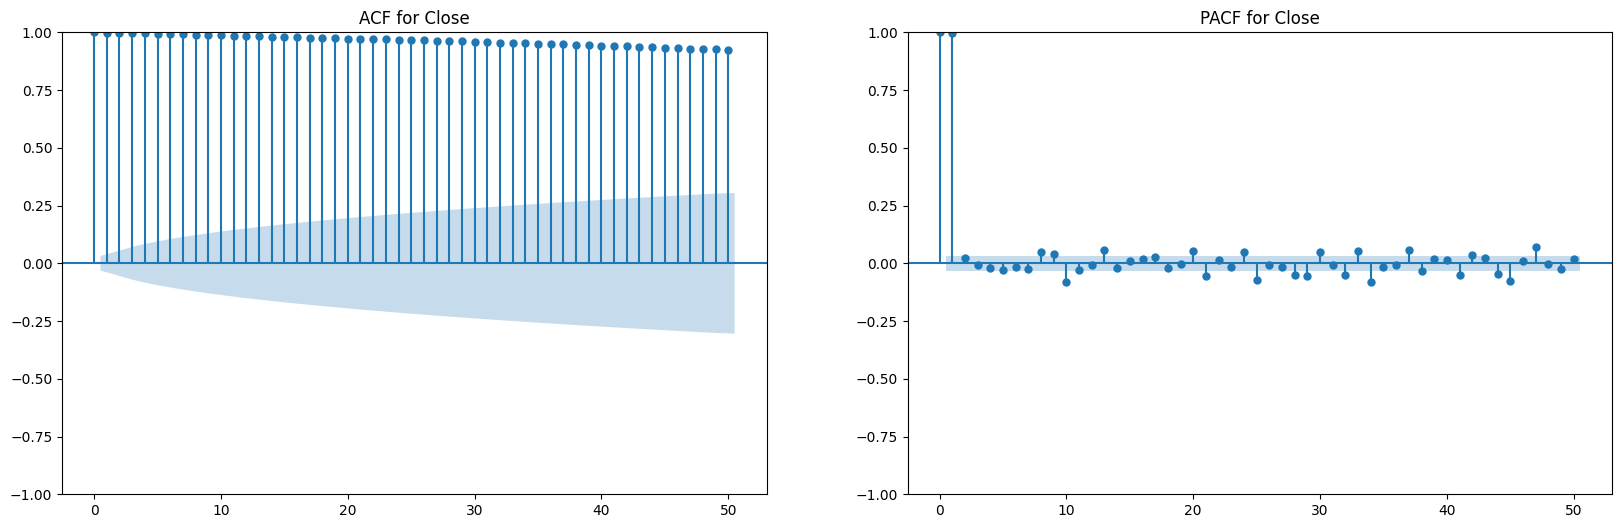

2023-10-15 02:34:34,126 [INFO] - Decomposing the time series
2023-10-15 02:34:36,044 [INFO] - Plot saved to: ts_plots_assets/decompose.png


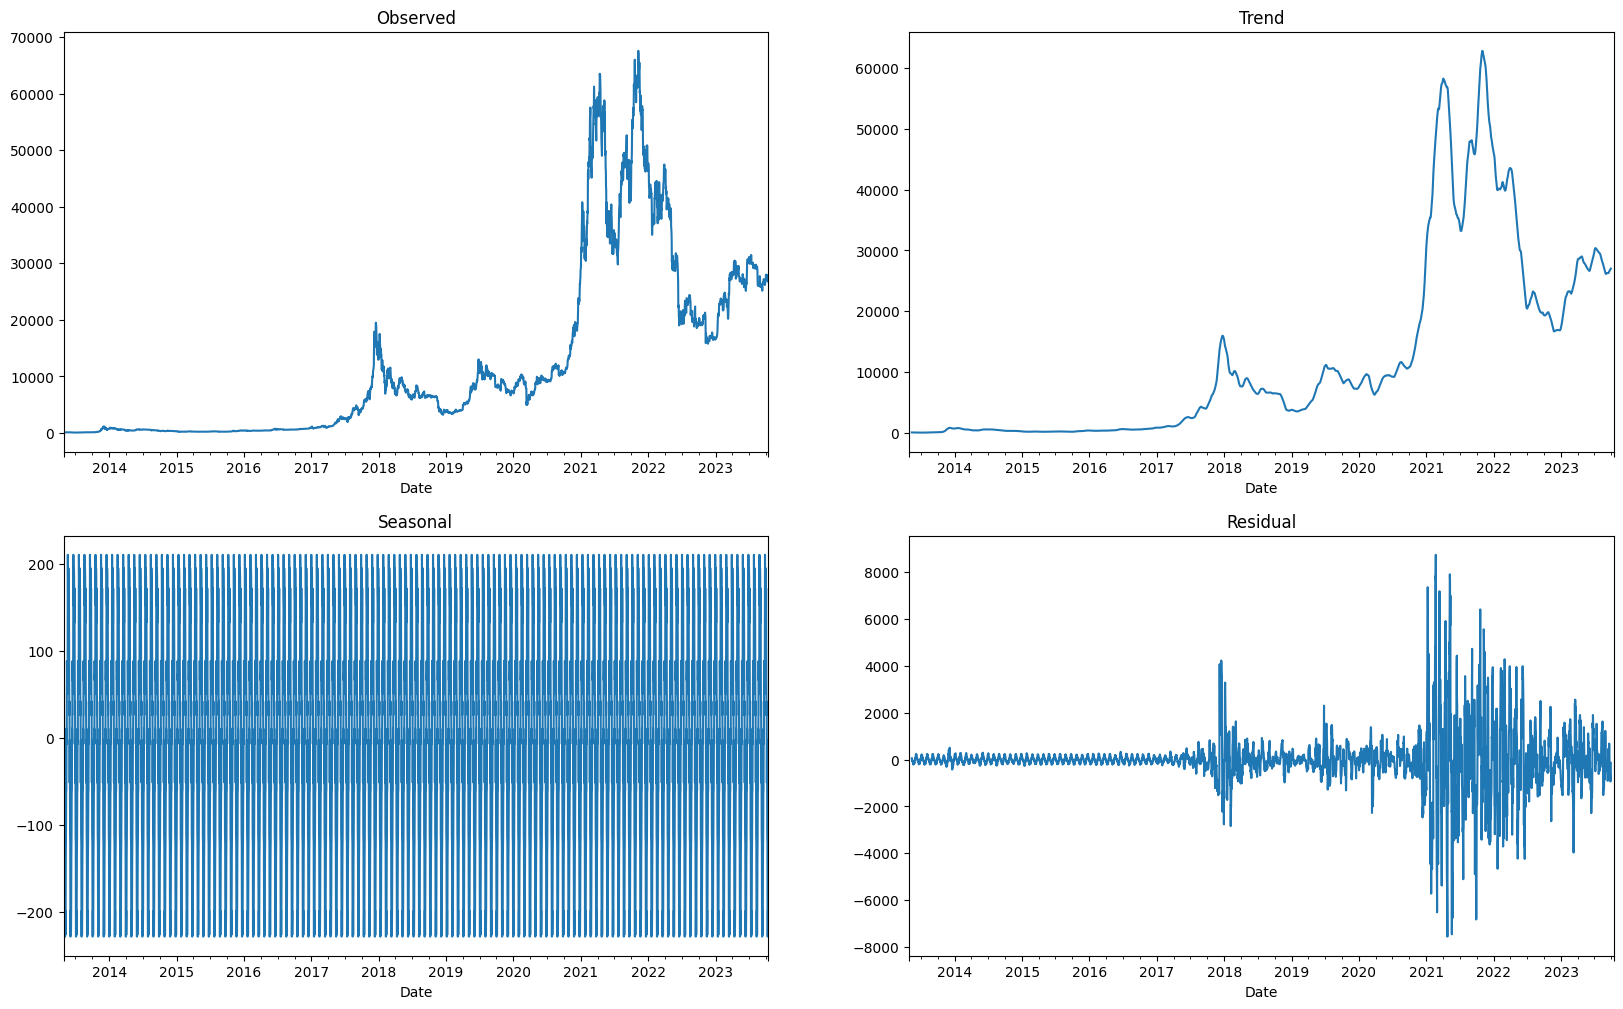

2023-10-15 02:34:38,137 [INFO] - Checking stationarity of the time series
2023-10-15 02:34:38,845 [INFO] - Performing Jarque-Bera test
2023-10-15 02:34:38,860 [INFO] - Jarque-Bera test statistic: 1685.068081467234 p-value: 0.0 Significance level: 0.05 Reject the null hypothesis: The series likely does not follow a normal distribution.
2023-10-15 02:34:38,870 [INFO] - Performing KPSS test
2023-10-15 02:34:38,875 [INFO] - KPSS test statistic: 6.1319945059130445 p-value: 0.01 Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739} Significance level: 0.05 Reject the null hypothesis: The series is likely stationary.
2023-10-15 02:34:38,881 [INFO] - Performing Kolmogorov-Smirnov test
2023-10-15 02:34:38,890 [INFO] - Kolmogorov-Smirnov test statistic: 1.0 p-value: 0.0 Significance level: 0.05 Reject the null hypothesis: The series likely does not follow the specified distribution.
2023-10-15 02:34:38,898 [INFO] - Checking volatility of the time series


------------------------------------------------------------
ADF Statistic: -1.603795144167509
p-value: 0.48168678382504115
Critical Values:
	1%: -3.4320761232873904
	5%: -2.862302706315417
	10%: -2.5671759986719715
The series is likely non-stationary.
------------------------------------------------------------


Jarque-Bera test statistic: 1685.068081467234
p-value: 0.0
Significance level: 0.05
Reject the null hypothesis: The series likely does not follow a normal distribution.


KPSS test statistic: 6.1319945059130445
p-value: 0.01
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Significance level: 0.05
Reject the null hypothesis: The series is likely stationary.


Kolmogorov-Smirnov test statistic: 1.0
p-value: 0.0
Significance level: 0.05
Reject the null hypothesis: The series likely does not follow the specified distribution.




2023-10-15 02:34:39,201 [INFO] - Testing Granger causality


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -38271.7
Distribution:                  Normal   AIC:                           76551.3
Method:            Maximum Likelihood   BIC:                           76576.3
                                        No. Observations:                 3821
Date:                Sun, Oct 15 2023   Df Residuals:                     3820
Time:                        02:34:39   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu           998.5075     33.441     29.859 6.695e-196 [9.

"Lag: 1ssr_ftest: F=2.2105, p=0.1372ssr_chi2test: chi2=2.2122, p=0.1369lrtest: chi2=2.2116, p=0.1370params_ftest: F=2.2105, p=0.1372","Lag: 2ssr_ftest: F=0.1870, p=0.8295ssr_chi2test: chi2=0.3744, p=0.8293lrtest: chi2=0.3744, p=0.8293params_ftest: F=0.1870, p=0.8295","Lag: 3ssr_ftest: F=0.9054, p=0.4376ssr_chi2test: chi2=2.7211, p=0.4367lrtest: chi2=2.7201, p=0.4368params_ftest: F=0.9054, p=0.4376","Lag: 4ssr_ftest: F=1.6477, p=0.1594ssr_chi2test: chi2=6.6064, p=0.1582lrtest: chi2=6.6007, p=0.1586params_ftest: F=1.6477, p=0.1594","Lag: 5ssr_ftest: F=0.8082, p=0.5436ssr_chi2test: chi2=4.0525, p=0.5419lrtest: chi2=4.0504, p=0.5422params_ftest: F=0.8082, p=0.5436","Lag: 6ssr_ftest: F=1.0968, p=0.3616ssr_chi2test: chi2=6.6034, p=0.3591lrtest: chi2=6.5977, p=0.3597params_ftest: F=1.0968, p=0.3616"
"Lag: 7ssr_ftest: F=2.2752, p=0.0260ssr_chi2test: chi2=15.9895, p=0.0252lrtest: chi2=15.9561, p=0.0255params_ftest: F=2.2752, p=0.0260","Lag: 8ssr_ftest: F=1.6957, p=0.0942ssr_chi2test: chi2=13.6263, p=0.0920lrtest: chi2=13.6020, p=0.0927params_ftest: F=1.6957, p=0.0942","Lag: 9ssr_ftest: F=4.9604, p=0.0000ssr_chi2test: chi2=44.8673, p=0.0000lrtest: chi2=44.6053, p=0.0000params_ftest: F=4.9604, p=0.0000","Lag: 10ssr_ftest: F=2.2642, p=0.0123ssr_chi2test: chi2=22.7675, p=0.0116lrtest: chi2=22.6998, p=0.0119params_ftest: F=2.2642, p=0.0123","Lag: 11ssr_ftest: F=2.2773, p=0.0091ssr_chi2test: chi2=25.2026, p=0.0085lrtest: chi2=25.1196, p=0.0088params_ftest: F=2.2773, p=0.0091","Lag: 12ssr_ftest: F=3.8043, p=0.0000ssr_chi2test: chi2=45.9535, p=0.0000lrtest: chi2=45.6785, p=0.0000params_ftest: F=3.8043, p=0.0000"
"Lag: 13ssr_ftest: F=2.8805, p=0.0004ssr_chi2test: chi2=37.7144, p=0.0003lrtest: chi2=37.5288, p=0.0003params_ftest: F=2.8805, p=0.0004","Lag: 14ssr_ftest: F=4.6484, p=0.0000ssr_chi2test: chi2=65.5771, p=0.0000lrtest: chi2=65.0187, p=0.0000params_ftest: F=4.6484, p=0.0000","Lag: 15ssr_ftest: F=4.6508, p=0.0000ssr_chi2test: chi2=70.3346, p=0.0000lrtest: chi2=69.6926, p=0.0000params_ftest: F=4.6508, p=0.0000","Lag: 16ssr_ftest: F=4.8060, p=0.0000ssr_chi2test: chi2=77.5683, p=0.0000lrtest: chi2=76.7882, p=0.0000params_ftest: F=4.8060, p=0.0000","Lag: 17ssr_ftest: F=4.4755, p=0.0000ssr_chi2test: chi2=76.7893, p=0.0000lrtest: chi2=76.0245, p=0.0000params_ftest: F=4.4755, p=0.0000","Lag: 18ssr_ftest: F=4.1793, p=0.0000ssr_chi2test: chi2=75.9665, p=0.0000lrtest: chi2=75.2177, p=0.0000params_ftest: F=4.1793, p=0.0000"
"Lag: 19ssr_ftest: F=4.6611, p=0.0000ssr_chi2test: chi2=89.4789, p=0.0000lrtest: chi2=88.4422, p=0.0000params_ftest: F=4.6611, p=0.0000","Lag: 20ssr_ftest: F=4.4255, p=0.0000ssr_chi2test: chi2=89.4746, p=0.0000lrtest: chi2=88.4377, p=0.0000params_ftest: F=4.4255, p=0.0000","Lag: 21ssr_ftest: F=3.7468, p=0.0000ssr_chi2test: chi2=79.5836, p=0.0000lrtest: chi2=78.7617, p=0.0000params_ftest: F=3.7468, p=0.0000","Lag: 22ssr_ftest: F=3.8214, p=0.0000ssr_chi2test: chi2=85.0775, p=0.0000lrtest: chi2=84.1389, p=0.0000params_ftest: F=3.8214, p=0.0000","Lag: 23ssr_ftest: F=4.1331, p=0.0000ssr_chi2test: chi2=96.2530, p=0.0000lrtest: chi2=95.0535, p=0.0000params_ftest: F=4.1331, p=0.0000","Lag: 24ssr_ftest: F=4.3271, p=0.0000ssr_chi2test: chi2=105.2080, p=0.0000lrtest: chi2=103.7768, p=0.0000params_ftest: F=4.3271, p=0.0000"
"Lag: 25ssr_ftest: F=3.3924, p=0.0000ssr_chi2test: chi2=85.9641, p=0.0000lrtest: chi2=85.0051, p=0.0000params_ftest: F=3.3924, p=0.0000","Lag: 26ssr_ftest: F=3.4170, p=0.0000ssr_chi2test: chi2=90.0992, p=0.0000lrtest: chi2=89.0463, p=0.0000params_ftest: F=3.4170, p=0.0000","Lag: 27ssr_ftest: F=3.7146, p=0.0000ssr_chi2test: chi2=101.7681, p=0.0000lrtest: chi2=100.4272, p=0.0000params_ftest: F=3.7146, p=0.0000","Lag: 28ssr_ftest: F=3.8034, p=0.0000ssr_chi2test: chi2=108.1205, p=0.0000lrtest: chi2=106.6082, p=0.0000params_ftest: F=3.8034, p=0.0000","Lag: 29ssr_ftest: F=4.1170, p=0.0000ssr_chi2test: chi2=121.2809, p=0.0000lrtest: chi2=119.3818, p=0.0000params_ftest: F=4.1170, p=0.0000","Lag: 30ssr_ftest: F=3.8598, p=0.0000ssr

In [16]:
from IPython.core.display import display, HTML

# Instantiate and call methods
tsa = TimeSeriesAnalysis(data, target='Close')

# Store and display the results
autocorr_fig = tsa.check_autocorrelation()
decomposition = tsa.decompose_time_series(show=True)  # Set show=False if you don't want to display the plot

adf_stat, p_value, crit_values = tsa.check_stationarity()
jb_results = tsa.check_jarque_bera(alpha=0.05)
kpss_results = tsa.check_kpss(alpha=0.05)
ks_results = tsa.check_ks_test(alpha=0.05)
volatility_summary = tsa.check_volatility()
granger_results = tsa.test_granger_causality('Open', maxlag=30, verbose=False)
display(HTML(tsa.concise_granger_output_table(granger_results)))


In [17]:
    def recheck_statistical_properties(self, tsa):
        """
        Re-run statistical tests to confirm transformation effectiveness.
        
        Parameters:
            tsa (TimeSeriesAnalysis): TimeSeriesAnalysis object for running statistical tests.
        """
        self.logger.info("Rechecking statistical properties after transformations...")
        jb_results = tsa.check_jarque_bera(alpha=0.05)
        kpss_results = tsa.check_kpss(alpha=0.05)
        ks_results = tsa.check_ks_test(alpha=0.05)
        return jb_results, kpss_results, ks_results

# ------------------------------------------------------------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------------------------------------------------------------

In [18]:
class UnifiedDataPreprocessor:
    """ 
    UnifiedDataPreprocessor is responsible for preprocessing time series data.
    It performs actions like data splitting, normalization, reshaping, and sequence generation.
    
    Attributes:
        data (pd.DataFrame): Original time series data.
        target_column (str): Target column for preprocessing.
        logger (logging.Logger): Logger for tracking operations and debugging.
        transformations (list): List of applied transformations.
    """
    
    def __init__(self, df, target_column, logger=None):
        self.data = df.copy()
        self.target_column = target_column
        self.scalers = {}
        self.X_train, self.X_test, self.y_train, self.y_test = None, None, None, None
        self.X_train_seq, self.X_test_seq, self.y_train_seq, self.y_test_seq = None, None, None, None
        self.logger = logger if logger else logging.getLogger(__name__)
        self.transformations = []
        self.lambda_val = None  
        self.scalers = {
            "MinMax": MinMaxScaler(),
            "Standard": StandardScaler(),
            "Robust": RobustScaler(),
            "Quantile": QuantileTransformer(output_distribution='normal'),
            "Power": PowerTransformer(method='yeo-johnson')
        }
        self.logger.info("Initializing DataPreprocessor...")        
    
    def get_scaler(self, scaler_type):
        self.logger.info(f"Getting scaler of type: {scaler_type}")
        try:
            return self.scalers[scaler_type]
        except KeyError:
            raise ValueError(f"Invalid scaler_type. Supported types are: {', '.join(self.scalers.keys())}")

    def split_and_plot_data(self, test_size=0.2, split_date=None, plot=True):
        """
        Split the data into training and test sets, and then plot the target variable for both sets.
        :param test_size: float, optional, default 0.2. Represents the proportion of the dataset to include in the test split.
        :param split_date: str, optional, default None. A date string (e.g., '2023-01-01') to split data at a specific date. If provided, this will override test_size.
        """
        self.logger.info("Splitting data...")

        features = self.data.drop(columns=[self.target_column])
        target = self.data[self.target_column]

        if split_date:
            train_mask = self.data.index < split_date
            self.X_train, self.X_test = features[train_mask], features[~train_mask]
            self.y_train, self.y_test = target[train_mask], target[~train_mask]
        else:
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
                features, target, test_size=test_size, shuffle=False
            )

        self.logger.info(f"Data split completed. X_train shape: {self.X_train.shape}, y_train shape: {self.y_train.shape}")
        print(f"X_train shape: {self.X_train.shape}, y_train shape: {self.y_train.shape}")
        print(f"X_test shape: {self.X_test.shape}, y_test shape: {self.y_test.shape}")

        if plot: # Plotting
            plt.figure(figsize=(20, 7))
            plt.subplot(1, 2, 1)
            plt.title('Training Data - Target')
            plt.plot(self.y_train, label=self.target_column)
            plt.xlabel("Time")
            plt.ylabel("Value")
            plt.legend()
            plt.subplot(1, 2, 2)
            plt.title('Test Data - Target')
            plt.plot(self.y_test, label=self.target_column)
            plt.xlabel("Time")
            plt.ylabel("Value")
            plt.legend()
            plt.show()

    def normalize_data(self, scaler_type='MinMax',plot=True):
        self.logger.info("Normalizing feature data...")
        scaler = self.get_scaler(scaler_type)
        self.X_train = scaler.fit_transform(self.X_train)
        self.X_test = scaler.transform(self.X_test)
        self.scalers['features'] = scaler
        self.logger.info("Feature data normalization completed.")

        # Plot normalized training and test features
        if plot:
            plt.figure(figsize=(20, 8))
            plt.subplot(1, 2, 1)
            plt.title('Normalized Training Features')
            for i in range(self.X_train.shape[1]):
                plt.plot(self.X_train[:, i], label=f'Feature {i}')
            plt.legend()
            plt.subplot(1, 2, 2)
            plt.title('Normalized Test Features')
            for i in range(self.X_test.shape[1]):
                plt.plot(self.X_test[:, i], label=f'Feature {i}')
            plt.legend()
            plt.show()

    def normalize_target(self, scaler_type='MinMax', plot=True):
        self.logger.info("Normalizing target data...")
        scaler = self.get_scaler(scaler_type)
        self.y_train = scaler.fit_transform(self.y_train.values.reshape(-1, 1))
        self.y_test = scaler.transform(self.y_test.values.reshape(-1, 1))
        self.scalers['target'] = scaler
        self.logger.info("Target data normalization completed.")

        if plot:# Plot normalized training and test targets
            plt.figure(figsize=(20, 7))
            plt.subplot(1, 2, 1)
            plt.title('Normalized Training Target')
            plt.plot(self.y_train, label='Normalized ' + self.target_column)
            plt.legend()
            plt.subplot(1, 2, 2)
            plt.title('Normalized Test Target')
            plt.plot(self.y_test, label='Normalized ' + self.target_column)
            plt.legend()
            plt.show()
  
    def difference_and_plot_data(self, interval=1,plot=True):
        """
        Apply differencing to the data and then plot it.

        Parameters:
            interval (int): The interval between differencing. Default is 1.
        """
        self.logger.info(f"Applying differencing with interval {interval}...")
        self.data = self.data.diff(periods=interval).dropna()
        self.transformations.append('Differencing')
        self.logger.info("Differencing applied.")
        if plot:
            plt.figure(figsize=(20, 7))
            plt.title('Data after Differencing')
            plt.plot(self.data[self.target_column], label=self.target_column)
            plt.legend()
            plt.show()
        
    def box_cox_transform_and_plot(self, lambda_val=None,plot=True):
        if self.y_train is None or self.y_test is None:
            self.logger.warning("Data not split yet. Run split_data first.")
            return self  # Allow method chaining

        if np.any(self.y_train <= 0) or np.any(self.y_test <= 0):
            self.logger.warning("Data must be positive for Box-Cox transformation.")
            return self  # Allow method chaining

        self.logger.info("Applying Box-Cox transformation...")
        self.y_train = self.y_train.ravel()
        self.y_test = self.y_test.ravel()
        self.y_train, fitted_lambda = boxcox(self.y_train)
        self.lambda_val = fitted_lambda if lambda_val is None else lambda_val
        self.y_test = boxcox(self.y_test, lmbda=self.lambda_val)
        self.logger.info(f"Box-Cox transformation applied with lambda {self.lambda_val}.")

        if plot:# Plotting only the target variable
            plt.figure(figsize=(20, 7))
            plt.subplot(1, 2, 1)
            plt.title('Box-Cox Transformed Training Target')
            plt.plot(self.y_train, label='Transformed ' + self.target_column)
            plt.legend()
            plt.subplot(1, 2, 2)
            plt.title('Box-Cox Transformed Test Target')
            plt.plot(self.y_test, label='Transformed ' + self.target_column)
            plt.legend()
            plt.show()

    def inverse_box_cox_and_plot(self,plot=True):
        if f'Box-Cox on {self.target_column}' not in self.transformations:
            self.logger.warning("No Box-Cox transformation found on the target column. Skipping inverse transformation.")
            return

        self.logger.info("Applying inverse Box-Cox transformation...")
        self.y_train = invboxcox(self.y_train, self.lambda_val)
        self.y_test = invboxcox(self.y_test, self.lambda_val)
        self.transformations.remove(f'Box-Cox on {self.target_column}')
        self.logger.info(f"Inverse Box-Cox transformation applied on column {self.target_column}.")
        
        if plot:
            plt.figure(figsize=(20, 7))
            plt.subplot(1, 2, 1)
            plt.title('Inverse Box-Cox Transformed Training Target')
            plt.plot(self.y_train, label='Inverse Transformed ' + self.target_column)
            plt.legend()
            plt.subplot(1, 2, 2)
            plt.title('Inverse Box-Cox Transformed Test Target')
            plt.plot(self.y_test, label='Inverse Transformed ' + self.target_column)
            plt.legend()
            plt.show()
        
        
        
        
        
        
        
        
        
        
        
        
        
        
    def reshape_for_recurrent(self, data):
        self.logger.info("Reshaping data for recurrent models...")
        reshaped_data = data.reshape(data.shape)
        self.logger.info(f"Data reshaped to {reshaped_data.shape}.")
        return reshaped_data

    def generate_sequences(self, X_data, y_data, n_steps, seq_to_seq=False):
        X, y = [], []
        for i in range(len(X_data) - n_steps):
            seq_x = X_data[i:i + n_steps, :]
            if seq_to_seq:
                seq_y = y_data[i:i + n_steps, :]
            else:
                seq_y = y_data[i + n_steps - 1]
            X.append(seq_x)
            y.append(seq_y)
        self.logger.info(f"Generated {len(X)} sequences of shape {X[0].shape}.")
        return np.array(X), np.array(y)
    
    def prepare_data_for_recurrent(self, n_steps, seq_to_seq=False):
        self.logger.info(f"Preparing data for recurrent models with {n_steps} timesteps...")
        X_train_seq, y_train_seq = self.generate_sequences(self.X_train, self.y_train, n_steps, seq_to_seq)
        X_test_seq, y_test_seq = self.generate_sequences(self.X_test, self.y_test, n_steps, seq_to_seq)

        # Update instance variables here
        self.X_train_seq = self.reshape_for_recurrent(X_train_seq)
        self.X_test_seq = self.reshape_for_recurrent(X_test_seq)
        self.y_train_seq = y_train_seq  # Assuming y_train_seq and y_test_seq are already 2D
        self.y_test_seq = y_test_seq

        self.logger.info("Data preparation for recurrent models completed.")
        return self.X_train_seq, self.y_train_seq, self.X_test_seq, self.y_test_seq

    def prepare_for_prophet(self):
        """Prepare data for Prophet model."""
        prophet_data = self.data[[self.target_column]].reset_index()
        prophet_data.columns = ['ds', 'y']
        return prophet_data

    def get_preprocessed_data(self):
        """Get preprocessed data."""
        return self.X_train, self.y_train, self.X_test, self.y_test


In [19]:
df = data_c['BTC'].copy()

2023-10-15 02:34:42,283 [INFO] - Initializing DataPreprocessor...
2023-10-15 02:34:42,285 [INFO] - Splitting data...
2023-10-15 02:34:42,305 [INFO] - Data split completed. X_train shape: (3056, 5), y_train shape: (3056,)


X_train shape: (3056, 5), y_train shape: (3056,)
X_test shape: (765, 5), y_test shape: (765,)


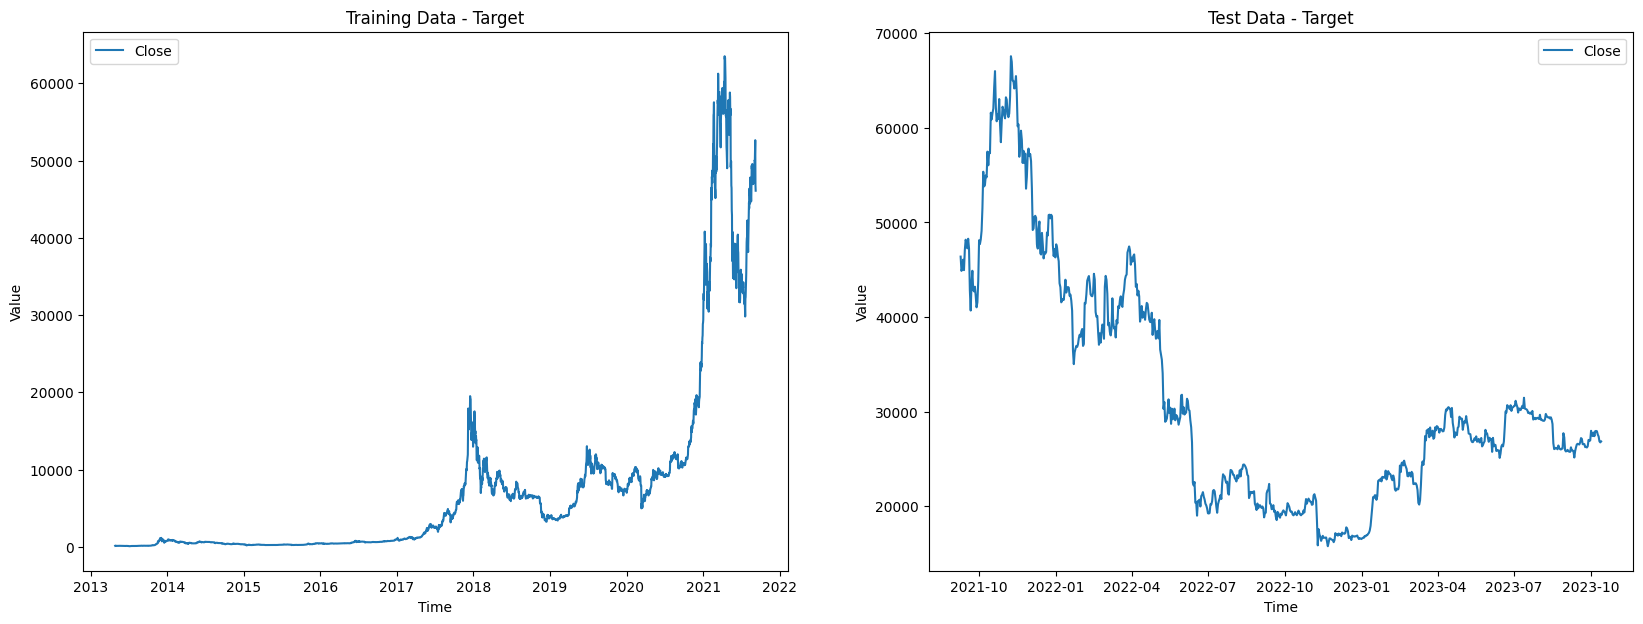

2023-10-15 02:34:44,357 [INFO] - Normalizing feature data...
2023-10-15 02:34:44,360 [INFO] - Getting scaler of type: MinMax
2023-10-15 02:34:44,378 [INFO] - Feature data normalization completed.
2023-10-15 02:34:44,381 [INFO] - Normalizing target data...
2023-10-15 02:34:44,385 [INFO] - Getting scaler of type: MinMax
2023-10-15 02:34:44,388 [INFO] - Target data normalization completed.
2023-10-15 02:34:44,393 [INFO] - Preparing data for recurrent models with 10 timesteps...
2023-10-15 02:34:44,405 [INFO] - Generated 3046 sequences of shape (10, 5).
2023-10-15 02:34:44,423 [INFO] - Generated 755 sequences of shape (10, 5).
2023-10-15 02:34:44,428 [INFO] - Reshaping data for recurrent models...
2023-10-15 02:34:44,430 [INFO] - Data reshaped to (3046, 10, 5).
2023-10-15 02:34:44,433 [INFO] - Reshaping data for recurrent models...
2023-10-15 02:34:44,435 [INFO] - Data reshaped to (755, 10, 5).
2023-10-15 02:34:44,440 [INFO] - Data preparation for recurrent models completed.
2023-10-15 02:

X_train shape: (3056, 5), y_train shape: (3056,)
X_test shape: (765, 5), y_test shape: (765,)
X_train shape: (3056, 5), y_train shape: (3056,)
X_test shape: (765, 5), y_test shape: (765,)
X_train shape: (3056, 5), y_train shape: (3056,)
X_test shape: (765, 5), y_test shape: (765,)


In [20]:
# LSTM Sequece-to-One
#tsa = TimeSeriesAnalysis(df, target='Close')
d_preprocessor = UnifiedDataPreprocessor(df, target_column='Close')
d_preprocessor.split_and_plot_data(test_size=0.2)
d_preprocessor.normalize_data(scaler_type='MinMax',plot=False)
d_preprocessor.normalize_target(scaler_type='MinMax',plot=False)
n_steps = 10 
X_train_seq, y_train_seq, X_test_seq, y_test_seq = d_preprocessor.prepare_data_for_recurrent(n_steps, seq_to_seq=False)

# LSTM Sequece-to-Sequence
d_preprocessor = UnifiedDataPreprocessor(df, target_column='Close')
d_preprocessor.split_and_plot_data(test_size=0.2, plot=False)
d_preprocessor.normalize_data(scaler_type='MinMax', plot=False)
d_preprocessor.normalize_target(scaler_type='MinMax', plot=False)
n_steps = 10 
X_train_seq1, y_train_seq1, X_test_seq1, y_test_seq1 = d_preprocessor.prepare_data_for_recurrent(n_steps, seq_to_seq=True)

# For Linear Regression
d_preprocessor = UnifiedDataPreprocessor(df, target_column='Close')
d_preprocessor.split_and_plot_data(test_size=0.2, plot=False)
d_preprocessor.normalize_data(scaler_type='MinMax', plot=False)
d_preprocessor.normalize_target(scaler_type='MinMax', plot=False)
X_train_lr, y_train_lr, X_test_lr, y_test_lr = d_preprocessor.get_preprocessed_data()

# For XGBoost 
d_preprocessor = UnifiedDataPreprocessor(df, target_column='Close')
d_preprocessor.split_and_plot_data(test_size=0.2, plot=False)
d_preprocessor.normalize_data(scaler_type='MinMax', plot=False)
d_preprocessor.normalize_target(scaler_type='MinMax', plot=False)
X_train_xgb, y_train_xgb, X_test_xgb, y_test_xgb = d_preprocessor.get_preprocessed_data()

In [21]:
print("LSTM Sequence-to-One Data Shapes:")
print("X_train_seq:", X_train_seq.shape)
print("y_train_seq:", y_train_seq.shape)
print("X_test_seq:", X_test_seq.shape)
print("y_test_seq:", y_test_seq.shape)
print("----")

print("LSTM Sequence-to-Sequence Data Shapes:")
print("X_train_seq:", X_train_seq1.shape)
print("y_train_seq:", y_train_seq1.shape)
print("X_test_seq:", X_test_seq1.shape)
print("y_test_seq:", y_test_seq1.shape)
print("----")

print("LR Data Shapes:")
print("X_train_lr:", X_train_lr.shape)
print("y_train_lr:", y_train_lr.shape)
print("X_test_lr:", X_test_lr.shape)
print("y_test_lr:", y_test_lr.shape)
print("----")


print("XGB Data Shapes:")
print("X_train_xgb:", X_train_xgb.shape)
print("y_train_xgb:", y_train_xgb.shape)
print("X_test_xgb:", X_test_xgb.shape)
print("y_test_xgb:", y_test_xgb.shape)
print("----")

LSTM Sequence-to-One Data Shapes:
X_train_seq: (3046, 10, 5)
y_train_seq: (3046, 1)
X_test_seq: (755, 10, 5)
y_test_seq: (755, 1)
----
LSTM Sequence-to-Sequence Data Shapes:
X_train_seq: (3046, 10, 5)
y_train_seq: (3046, 10, 1)
X_test_seq: (755, 10, 5)
y_test_seq: (755, 10, 1)
----
LR Data Shapes:
X_train_lr: (3056, 5)
y_train_lr: (3056, 1)
X_test_lr: (765, 5)
y_test_lr: (765, 1)
----
XGB Data Shapes:
X_train_xgb: (3056, 5)
y_train_xgb: (3056, 1)
X_test_xgb: (765, 5)
y_test_xgb: (765, 1)
----


# ------------------------------------------------------------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------------------------------------------------------------

In [32]:

class BaseModel_ML:
    """
    A base class for machine learning models.
    This class handles data preprocessing, model training, predictions, and evaluations.
    
    - Linear Regression
    - XGBoost
    - LightGBM
    - KNN
    - SVM
    - Random Forest
    """
    def __init__(self, data_preprocessor, config, plot=True):
        self._validate_input(data_preprocessor.X_train, data_preprocessor.y_train, data_preprocessor.X_test, data_preprocessor.y_test)
        self.X_train = data_preprocessor.X_train
        self.y_train = data_preprocessor.y_train
        self.X_test = data_preprocessor.X_test
        self.y_test = data_preprocessor.y_test
        self.feature_scaler = data_preprocessor.scalers['features']
        self.target_scaler = data_preprocessor.scalers['target']
        self.data = data_preprocessor.data
        self.config = config
        self.plot = plot
        self.logger = logging.getLogger(__name__)    
    
    def _validate_input(self, X_train, y_train, X_test, y_test):
        """Validate the shape and type of training and testing data."""
        for arr, name in [(X_train, 'X_train'), (y_train, 'y_train'), (X_test, 'X_test'), (y_test, 'y_test')]:
            if not isinstance(arr, np.ndarray) or len(arr.shape) != 2:
                raise ValueError(f"{name} should be a 2D numpy array.")
                
    def inverse_scale_predictions(self):
        """ Inverse and unscale the predicstion back to their original shape"""
        try:
            self.train_predictions = self.target_scaler.inverse_transform(self.train_predictions.reshape(-1, 1)).flatten()
            self.test_predictions = self.target_scaler.inverse_transform(self.test_predictions.reshape(-1, 1)).flatten()
            self.logger.info("Predictions inverse transformed to original scale")
        except Exception as e:
            self.logger.error(f"Error occurred while inverse transforming predictions: {str(e)}")
            
    def compare_predictions(self):
        """Create dataframes comparing the original and predicted values for both training and test sets."""
        try:
            train_indices = self.data['Close'].iloc[:len(self.y_train)].values
            test_indices = self.data['Close'].iloc[-len(self.y_test):].values

            train_comparison_df = pd.DataFrame({'Original': train_indices, 'Predicted': self.train_predictions.ravel()})
            test_comparison_df = pd.DataFrame({'Original': test_indices, 'Predicted': self.test_predictions.ravel()})

            train_date_index = self.data.index[:len(self.y_train)]
            test_date_index = self.data.index[-len(self.y_test):]

            train_comparison_df.set_index(train_date_index, inplace=True)
            test_comparison_df.set_index(test_date_index, inplace=True)
            self.logger.info("Comparison dataframes generated")
            return train_comparison_df, test_comparison_df
        except Exception as e:
            self.logger.error(f"Error occurred while creating comparison dataframes: {str(e)}")

    def evaluate_model(self):
        """Evaluate the model using various metrics for both training and test sets."""
        try:
            train_comparison_df, test_comparison_df = self.compare_predictions()
            metrics = {
                'RMSE': lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
                'R2 Score': r2_score,
                'MAE': mean_absolute_error,
                'Explained Variance': explained_variance_score
            }

            results = []
            for dataset, comparison_df in [('Train', train_comparison_df), ('Test', test_comparison_df)]:
                dataset_results = {metric_name: metric_func(comparison_df['Original'], comparison_df['Predicted']) for metric_name, metric_func in metrics.items()}
                results.append(dataset_results)

            results_df = pd.DataFrame(results, index=['Train', 'Test'])
            return results_df
        except Exception as e:
            self.logger.error(f"Error occurred while evaluating the model: {str(e)}")
        
    @staticmethod
    def update_config_hash_mapping(config_hash, config, folder_name="models_assets"):
        mapping_file_path = os.path.join(folder_name, 'config_hash_mapping.json')
        if os.path.exists(mapping_file_path):
            with open(mapping_file_path, 'r') as f:
                existing_mappings = json.load(f)
        else:
            existing_mappings = {}

        existing_mappings[config_hash] = config

        # Save updated mappings
        with open(mapping_file_path, 'w') as f:
            json.dump(existing_mappings, f, indent=4)

    def save_model_to_folder(self, version, folder_name="models_assets"):
        model_name = self.__class__.__name__[9:]  # Remove 'Enhanced_' from the class name
        config_str = json.dumps(self.config, sort_keys=True)
        config_hash = hashlib.md5(config_str.encode()).hexdigest()[:6]

        if not os.path.exists(folder_name):
            os.makedirs(folder_name)

        BaseModel_ML.update_config_hash_mapping(config_hash, self.config, folder_name)

        # Save the model
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        filename = f"{model_name}_V{version}_{config_hash}_{timestamp}.joblib"
        full_path = os.path.join(folder_name, filename)
        dump(self.model, full_path)
        self.logger.info(f"Model saved to {full_path}")
        
    def plot_predictions(self):
        """Plot the original vs predicted values for both training and testing data."""
        if not self.plot:
            return

        train_comparison_df, test_comparison_df = self.compare_predictions()
        train_comparison_df.index = pd.to_datetime(train_comparison_df.index)
        test_comparison_df.index = pd.to_datetime(test_comparison_df.index)

        source_train = ColumnDataSource(data=dict(
            date=train_comparison_df.index,
            original=train_comparison_df['Original'],
            predicted=train_comparison_df['Predicted']
        ))

        source_test = ColumnDataSource(data=dict(
            date=test_comparison_df.index,
            original=test_comparison_df['Original'],
            predicted=test_comparison_df['Predicted']
        ))

        p1 = figure(width=700, height=600, x_axis_type="datetime", title="Training Data: Actual vs Predicted")
        p1.line('date', 'original', legend_label="Actual", line_alpha=0.6, source=source_train)
        p1.line('date', 'predicted', legend_label="Predicted", line_color="red", line_dash="dashed", source=source_train)
        p1.legend.location = "top_left"

        p2 = figure(width=700, height=600, x_axis_type="datetime", title="Testing Data: Actual vs Predicted")
        p2.line('date', 'original', legend_label="Actual", line_alpha=0.6, source=source_test)
        p2.line('date', 'predicted', legend_label="Predicted", line_color="red", line_dash="dashed", source=source_test)
        p2.legend.location = "top_left"

        hover1 = HoverTool()
        hover1.tooltips = [
            ("Date", "@date{%F}"),
            ("Actual Value", "@original{0,0.0000}"),
            ("Predicted Value", "@predicted{0,0.0000}")
        ]
        hover1.formatters = {"@date": "datetime"}
        p1.add_tools(hover1)

        hover2 = HoverTool()
        hover2.tooltips = [
            ("Date", "@date{%F}"),
            ("Actual Value", "@original{0,0.0000}"),
            ("Predicted Value", "@predicted{0,0.0000}")
        ]
        hover2.formatters = {"@date": "datetime"}
        p2.add_tools(hover2)

        # Show plots
        show(row(p1, p2))

In [33]:
class Enhanced_Linear_Regression(BaseModel_ML):
    """
    Initialize the Enhanced_Linear_Regression model.
    Supports Ridge and Lasso regularization.
    """
    def __init__(self, data_preprocessor, config, plot=True):
        super().__init__(data_preprocessor, config, plot)
        self._initialize_model()

    def _initialize_model(self):
        """Choose the regression model based on the configuration."""
        if self.config['regularization'] == 'ridge':
            self.model = Ridge(alpha=self.config['alpha'])
            self.logger.info("Ridge regression model initialized.")
        elif self.config['regularization'] == 'lasso':
            self.model = Lasso(alpha=self.config['alpha'])
            self.logger.info("Lasso regression model initialized.")
        else:
            self.model = LinearRegression()
            self.logger.info("Plain Linear Regression model initialized.")

    def train_model(self):
        """Train the Linear Regression model."""
        try:
            self.model.fit(self.X_train, self.y_train)
            self.logger.info("Linear Regression model trained successfully.")
        except Exception as e:
            self.logger.error(f"Error occurred while training the model: {str(e)}")

    def make_predictions(self):
        """Make predictions using the trained model for training and test sets."""
        try:
            self.train_predictions = self.model.predict(self.X_train)
            self.test_predictions = self.model.predict(self.X_test)
            self.logger.info("Predictions made successfully.")
        except Exception as e:
            self.logger.error(f"Error occurred while making predictions: {str(e)}")

In [34]:
class Enhanced_XGBoost(BaseModel_ML):
    def __init__(self, data_preprocessor, config, plot=True):
        super().__init__(data_preprocessor, config, plot)
        self._initialize_model()

    def _initialize_model(self):
        """Initialize the XGBoost model based on the configuration."""
        self.model = xgb.XGBRegressor(**self.config)
        self.logger.info("XGBoost model initialized.")
        
    def train_model(self):
        """Train the XGBoost model."""
        try:
            self.model.fit(self.X_train, self.y_train)
            self.logger.info("XGBoost model trained successfully")
        except Exception as e:
            self.logger.error(f"Error occurred while training the model: {str(e)}")

    def make_predictions(self):
        """Make predictions using the trained model for training and test sets."""
        try:
            self.train_predictions = self.model.predict(self.X_train)
            self.test_predictions = self.model.predict(self.X_test)
            self.logger.info("Predictions made successfully for both training and test data")
        except Exception as e:
            self.logger.error(f"Error occurred while making predictions: {str(e)}")        

In [35]:
class Enhanced_LightGBM(BaseModel_ML):
    """
    Initialize the Enhanced LightGBM model.
    """
    def __init__(self, data_preprocessor, config, plot=True):
        super().__init__(data_preprocessor, config, plot)
        self._initialize_model()

    def _initialize_model(self):
        """Initialize the LightGBM model based on the configuration."""
        self.model = LGBMRegressor(**self.config)
        self.logger.info("LightGBM model initialized.")

    def train_model(self):
        try:
            self.model.fit(self.X_train, self.y_train)
            self.logger.info("LightGBM model trained successfully")
        except Exception as e:
            self.logger.error(f"Error occurred while training the model: {str(e)}")

    def make_predictions(self):
        """Make predictions using the trained model for training and test sets."""
        try:
            self.train_predictions = self.model.predict(self.X_train)
            self.test_predictions = self.model.predict(self.X_test)
            self.logger.info("Predictions made successfully for both training and test data")
        except Exception as e:
            self.logger.error(f"Error occurred while making predictions: {str(e)}")

In [36]:
class Enhanced_SVM(BaseModel_ML):
    """
    Initialize the Enhanced SVM model.
    """
    def __init__(self, data_preprocessor, config, plot=True):
        super().__init__(data_preprocessor, config, plot)
        self._initialize_model()

    def _initialize_model(self):
        """Initialize the SVM model based on the configuration."""
        self.model = SVR(**self.config)
        self.logger.info("SVM model initialized.")

    def train_model(self):
        """Train the SVM model."""
        try:
            self.model.fit(self.X_train, self.y_train.ravel())  # ravel() to convert y_train to 1D for SVM
            self.logger.info("SVM model trained successfully.")
        except Exception as e:
            self.logger.error(f"Error occurred while training the model: {str(e)}")

    def make_predictions(self):
        """Make predictions using the trained model."""
        try:
            self.train_predictions = self.model.predict(self.X_train)
            self.test_predictions = self.model.predict(self.X_test)
            self.logger.info("Predictions made successfully.")
        except Exception as e:
            self.logger.error(f"Error occurred while making predictions: {str(e)}")

In [37]:

class Enhanced_KNN(BaseModel_ML):
    """
    Initialize the Enhanced KNN model.
    """
    def __init__(self, data_preprocessor, config, plot=True):
        super().__init__(data_preprocessor, config, plot)
        self._initialize_model()

    def _initialize_model(self):
        """
        Initialize the KNN model based on the configuration.
        """
        self.model = KNeighborsRegressor(**self.config)
        self.logger.info("KNN model initialized.")

    def train_model(self):
        """
        Train the KNN model.
        """
        try:
            self.model.fit(self.X_train, self.y_train.ravel())  # ravel() to convert y_train to 1D for KNN
            self.logger.info("KNN model trained successfully.")
        except Exception as e:
            self.logger.error(f"Error occurred while training the model: {str(e)}")

    def make_predictions(self):
        """Make predictions using the trained model."""
        try:
            self.train_predictions = self.model.predict(self.X_train)
            self.test_predictions = self.model.predict(self.X_test)
            self.logger.info("Predictions made successfully.")
        except Exception as e:
            self.logger.error(f"Error occurred while making predictions: {str(e)}")

In [38]:

class Enhanced_RandomForest(BaseModel_ML):
    """
    A class for an enhanced Random Forest Regression model.
    Inherits from the BaseModel class.
    """
    def __init__(self, data_preprocessor, config, plot=True):
        super().__init__(data_preprocessor, config, plot)
        self._initialize_model()

    def _initialize_model(self):
        """
        Initialize the Random Forest model based on the configuration.
        """
        self.model = RandomForestRegressor(**self.config)
        self.logger.info("Random Forest model initialized.")

    def feature_importance(self):
        """
        Extract feature importance scores.
        """
        try:
            importance_scores = self.model.feature_importances_
            self.logger.info("Feature importance scores extracted.")
            return importance_scores
        except Exception as e:
            self.logger.error(f"Error occurred while extracting feature importance: {str(e)}")
            
    def train_model(self):
        """Make predictions using the trained model for training and test sets."""
        try:
            self.model.fit(self.X_train, self.y_train.ravel())  # Using ravel() to fit the expected shape
            self.logger.info("RandomForest model trained successfully")
        except Exception as e:
            self.logger.error(f"Error occurred while training the model: {str(e)}")

    def make_predictions(self):
        """Make predictions using the trained model."""
        try:
            self.train_predictions = self.model.predict(self.X_train)
            self.test_predictions = self.model.predict(self.X_test)
            self.logger.info("Predictions made successfully.")
        except Exception as e:
            self.logger.error(f"Error occurred while making predictions: {str(e)}")

In [39]:
class Enhanced_SVR(BaseModel_ML):
    """
    Initialize the Enhanced SVR model.
    """
    def __init__(self, data_preprocessor, config, plot=True):
        super().__init__(data_preprocessor, config, plot)
        self._initialize_model()

    def _initialize_model(self):
        """Initialize the SVR model based on the configuration."""
        self.model = SVR(**self.config)
        self.logger.info("SVR model initialized.")
        
    def train_model(self):
        """Train the model."""
        try:
            self.model.fit(self.X_train, self.y_train.ravel())  # Using ravel() to fit the expected shape for some models
            self.logger.info(f"{self.__class__.__name__} model trained successfully.")
        except Exception as e:
            self.logger.error(f"Error occurred while training the model: {str(e)}")

    def make_predictions(self):
        """Make predictions using the trained model."""
        try:
            self.train_predictions = self.model.predict(self.X_train)
            self.test_predictions = self.model.predict(self.X_test)
            self.logger.info("Predictions made successfully.")
        except Exception as e:
            self.logger.error(f"Error occurred while making predictions: {str(e)}")


In [40]:
class Enhanced_ExtraTrees(BaseModel_ML):
    """
    Initialize the Enhanced Extra Trees model.
    """
    def __init__(self, data_preprocessor, config, plot=True):
        super().__init__(data_preprocessor, config, plot)
        self._initialize_model()

    def _initialize_model(self):
        """Initialize the Extra Trees model based on the configuration."""
        self.model = ExtraTreesRegressor(**self.config)
        self.logger.info("Extra Trees model initialized.")
        
    def train_model(self):
        """Train the model."""
        try:
            self.model.fit(self.X_train, self.y_train.ravel())  # Using ravel() to fit the expected shape for some models
            self.logger.info(f"{self.__class__.__name__} model trained successfully.")
        except Exception as e:
            self.logger.error(f"Error occurred while training the model: {str(e)}")

    def make_predictions(self):
        """Make predictions using the trained model."""
        try:
            self.train_predictions = self.model.predict(self.X_train)
            self.test_predictions = self.model.predict(self.X_test)
            self.logger.info("Predictions made successfully.")
        except Exception as e:
            self.logger.error(f"Error occurred while making predictions: {str(e)}")

In [41]:
data_preprocessor = UnifiedDataPreprocessor(df, target_column='Close')
data_preprocessor.split_and_plot_data(test_size=0.2, plot=False)
data_preprocessor.normalize_data(scaler_type='MinMax', plot=False)
data_preprocessor.normalize_target(scaler_type='MinMax', plot=False)

config = {
    'regularization': 'ridge',  # 'ridge', 'lasso', or None for plain Linear Regression
    'alpha': 1.0  # regularization strength
}

model = Enhanced_Linear_Regression(data_preprocessor, config, plot=True)
model.train_model()
model.make_predictions()
model.inverse_scale_predictions()
train_comparison_df, test_comparison_df = model.compare_predictions()
#display(test_comparison_df)
#display(train_comparison_df)
evaluation_results = model.evaluate_model()
display(evaluation_results)
model.plot_predictions()  # This will obey the plotting=True/False flag set during initialization
model.save_model_to_folder(version="final")


2023-10-15 02:35:48,410 [INFO] - Initializing DataPreprocessor...
2023-10-15 02:35:48,412 [INFO] - Splitting data...
2023-10-15 02:35:48,420 [INFO] - Data split completed. X_train shape: (3056, 5), y_train shape: (3056,)
2023-10-15 02:35:48,421 [INFO] - Normalizing feature data...
2023-10-15 02:35:48,422 [INFO] - Getting scaler of type: MinMax
2023-10-15 02:35:48,436 [INFO] - Feature data normalization completed.
2023-10-15 02:35:48,437 [INFO] - Normalizing target data...
2023-10-15 02:35:48,439 [INFO] - Getting scaler of type: MinMax
2023-10-15 02:35:48,442 [INFO] - Target data normalization completed.
2023-10-15 02:35:48,444 [INFO] - Ridge regression model initialized.
2023-10-15 02:35:48,449 [INFO] - Linear Regression model trained successfully.
2023-10-15 02:35:48,467 [INFO] - Predictions made successfully.
2023-10-15 02:35:48,469 [INFO] - Predictions inverse transformed to original scale
2023-10-15 02:35:48,473 [INFO] - Comparison dataframes generated
2023-10-15 02:35:48,478 [INFO

X_train shape: (3056, 5), y_train shape: (3056,)
X_test shape: (765, 5), y_test shape: (765,)


,RMSE,R2 Score,MAE,Explained Variance
Train,287.853,0.999,135.307,0.999
Test,550.544,0.998,422.611,0.998


2023-10-15 02:35:48,533 [INFO] - Comparison dataframes generated


2023-10-15 02:35:48,977 [INFO] - Model saved to models_assets/Linear_Regression_Vfinal_909612_20231015_023548.joblib


In [42]:
xgb_config = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.1,
    'n_estimators': 100,
    'max_depth': 5
}

xgb_model = Enhanced_XGBoost(data_preprocessor, xgb_config, plot=True)
xgb_model.train_model()
xgb_model.make_predictions()
xgb_model.inverse_scale_predictions()  # Make sure this method reshapes the arrays
train_comparison_df, test_comparison_df = xgb_model.compare_predictions()
#display(test_comparison_df)
#display(train_comparison_df)
evaluation_results = xgb_model.evaluate_model()
display(evaluation_results)
xgb_model.plot_predictions()
xgb_model.save_model_to_folder(version="final")

2023-10-15 02:35:54,389 [INFO] - XGBoost model initialized.
2023-10-15 02:35:56,579 [INFO] - XGBoost model trained successfully
2023-10-15 02:35:56,602 [INFO] - Predictions made successfully for both training and test data
2023-10-15 02:35:56,605 [INFO] - Predictions inverse transformed to original scale
2023-10-15 02:35:56,608 [INFO] - Comparison dataframes generated
2023-10-15 02:35:56,611 [INFO] - Comparison dataframes generated


,RMSE,R2 Score,MAE,Explained Variance
Train,135.741,1.000,56.461,1.000
Test,1566.736,0.984,1122.893,0.985


2023-10-15 02:35:56,633 [INFO] - Comparison dataframes generated


2023-10-15 02:35:56,963 [INFO] - Model saved to models_assets/XGBoost_Vfinal_93ce58_20231015_023556.joblib


In [43]:
lgbm_config = {
    'objective': 'regression',
    'learning_rate': 0.1,
    'n_estimators': 100,
    'max_depth': 5
}

lgbm_model = Enhanced_LightGBM(data_preprocessor, lgbm_config, plot=True)
lgbm_model.train_model()
lgbm_model.make_predictions()
lgbm_model.inverse_scale_predictions()
train_comparison_df, test_comparison_df = lgbm_model.compare_predictions()
#display(test_comparison_df)
#display(train_comparison_df)
evaluation_results = lgbm_model.evaluate_model()
display(evaluation_results)
lgbm_model.plot_predictions()
lgbm_model.save_model_to_folder(version="final")


2023-10-15 02:35:56,988 [INFO] - LightGBM model initialized.
2023-10-15 02:35:57,299 [INFO] - LightGBM model trained successfully


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 3056, number of used features: 5
[LightGBM] [Info] Start training from score 0.116267
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

2023-10-15 02:35:57,340 [INFO] - Predictions made successfully for both training and test data
2023-10-15 02:35:57,344 [INFO] - Predictions inverse transformed to original scale
2023-10-15 02:35:57,353 [INFO] - Comparison dataframes generated
2023-10-15 02:35:57,360 [INFO] - Comparison dataframes generated


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,RMSE,R2 Score,MAE,Explained Variance
Train,195.902,1.000,73.113,1.000
Test,1099.518,0.992,739.742,0.992


2023-10-15 02:35:57,388 [INFO] - Comparison dataframes generated


2023-10-15 02:35:57,882 [INFO] - Model saved to models_assets/LightGBM_Vfinal_847f0b_20231015_023557.joblib


In [44]:
svm_config = {
    'kernel': 'rbf',
    'C': 1.0,
    'epsilon': 0.1
}

# Initialize Enhanced_SVM model
svm_model = Enhanced_SVM(data_preprocessor, svm_config, plot=True)
svm_model.train_model()
svm_model.make_predictions()
svm_model.inverse_scale_predictions()
train_comparison_df, test_comparison_df = svm_model.compare_predictions()
#display(test_comparison_df)
#display(train_comparison_df)
evaluation_results = svm_model.evaluate_model()
display(evaluation_results)
svm_model.plot_predictions()
svm_model.save_model_to_folder(version="final")

2023-10-15 02:35:57,903 [INFO] - SVM model initialized.
2023-10-15 02:35:57,916 [INFO] - SVM model trained successfully.
2023-10-15 02:35:57,921 [INFO] - Predictions made successfully.
2023-10-15 02:35:57,923 [INFO] - Predictions inverse transformed to original scale
2023-10-15 02:35:57,928 [INFO] - Comparison dataframes generated
2023-10-15 02:35:57,930 [INFO] - Comparison dataframes generated


,RMSE,R2 Score,MAE,Explained Variance
Train,4890.848,0.842,4696.224,0.964
Test,4600.521,0.858,4306.839,0.883


2023-10-15 02:35:57,949 [INFO] - Comparison dataframes generated


2023-10-15 02:35:58,475 [INFO] - Model saved to models_assets/SVM_Vfinal_6de0eb_20231015_023558.joblib


In [45]:
svr_config = {
    'kernel': 'rbf',
    'C': 1.0,
    'epsilon': 0.1
}
svr_model = Enhanced_SVR(data_preprocessor, svr_config, plot=True)
svr_model.train_model()
svr_model.make_predictions()
svr_model.inverse_scale_predictions()
train_comparison_df, test_comparison_df = svr_model.compare_predictions()
#display(test_comparison_df)
#display(train_comparison_df)
evaluation_results = svr_model.evaluate_model()
display(evaluation_results)
svr_model.plot_predictions()
svr_model.save_model_to_folder(version="final")

2023-10-15 02:35:58,491 [INFO] - SVR model initialized.
2023-10-15 02:35:58,500 [INFO] - Enhanced_SVR model trained successfully.
2023-10-15 02:35:58,506 [INFO] - Predictions made successfully.
2023-10-15 02:35:58,509 [INFO] - Predictions inverse transformed to original scale
2023-10-15 02:35:58,512 [INFO] - Comparison dataframes generated
2023-10-15 02:35:58,517 [INFO] - Comparison dataframes generated


,RMSE,R2 Score,MAE,Explained Variance
Train,4890.848,0.842,4696.224,0.964
Test,4600.521,0.858,4306.839,0.883


2023-10-15 02:35:58,540 [INFO] - Comparison dataframes generated


2023-10-15 02:35:58,947 [INFO] - Model saved to models_assets/SVR_Vfinal_6de0eb_20231015_023558.joblib


In [46]:
knn_config = {
    'n_neighbors': 5,
    'weights': 'uniform',
    'algorithm': 'auto'
}

# Initialize Enhanced_KNN model
knn_model = Enhanced_KNN(data_preprocessor, knn_config, plot=True)
knn_model.train_model()
knn_model.make_predictions()
knn_model.inverse_scale_predictions()
train_comparison_df, test_comparison_df = knn_model.compare_predictions()
#display(test_comparison_df)
#display(train_comparison_df)
evaluation_results = knn_model.evaluate_model()
display(evaluation_results)
knn_model.plot_predictions()
knn_model.save_model_to_folder(version="final")

2023-10-15 02:35:58,963 [INFO] - KNN model initialized.
2023-10-15 02:35:58,974 [INFO] - KNN model trained successfully.
2023-10-15 02:35:59,025 [INFO] - Predictions made successfully.
2023-10-15 02:35:59,028 [INFO] - Predictions inverse transformed to original scale
2023-10-15 02:35:59,033 [INFO] - Comparison dataframes generated
2023-10-15 02:35:59,038 [INFO] - Comparison dataframes generated


,RMSE,R2 Score,MAE,Explained Variance
Train,213.876,1.000,81.048,1.000
Test,1076.043,0.992,835.098,0.993


2023-10-15 02:35:59,072 [INFO] - Comparison dataframes generated


2023-10-15 02:35:59,517 [INFO] - Model saved to models_assets/KNN_Vfinal_f67d60_20231015_023559.joblib


In [47]:
rf_config = {
    'n_estimators': 100,
    'criterion': 'poisson',
    'max_depth': None
}

# Initialize Enhanced_RandomForest model
rf_model = Enhanced_RandomForest(data_preprocessor, rf_config, plot=True)
rf_model.train_model()
feature_importance_scores = rf_model.feature_importance()
rf_model.make_predictions()
rf_model.inverse_scale_predictions()
train_comparison_df, test_comparison_df = rf_model.compare_predictions()
#display(test_comparison_df)
#display(train_comparison_df)
evaluation_results = rf_model.evaluate_model()
display(evaluation_results)
rf_model.plot_predictions()
rf_model.save_model_to_folder(version="final")

2023-10-15 02:35:59,532 [INFO] - Random Forest model initialized.
2023-10-15 02:36:02,533 [INFO] - RandomForest model trained successfully
2023-10-15 02:36:02,551 [INFO] - Feature importance scores extracted.
2023-10-15 02:36:02,647 [INFO] - Predictions made successfully.
2023-10-15 02:36:02,650 [INFO] - Predictions inverse transformed to original scale
2023-10-15 02:36:02,655 [INFO] - Comparison dataframes generated
2023-10-15 02:36:02,665 [INFO] - Comparison dataframes generated


,RMSE,R2 Score,MAE,Explained Variance
Train,48.667,1.000,20.420,1.000
Test,674.364,0.997,547.682,0.998


2023-10-15 02:36:02,690 [INFO] - Comparison dataframes generated


2023-10-15 02:36:03,569 [INFO] - Model saved to models_assets/RandomForest_Vfinal_cd5fc6_20231015_023603.joblib


In [48]:
extra_trees_config = {
    'n_estimators': 100,
    'criterion': 'squared_error',
    'max_depth': None
}
extra_trees_model = Enhanced_ExtraTrees(data_preprocessor, extra_trees_config, plot=True)
extra_trees_model.train_model()
extra_trees_model.make_predictions()
extra_trees_model.inverse_scale_predictions()
train_comparison_df, test_comparison_df = extra_trees_model.compare_predictions()
#display(test_comparison_df)
#display(train_comparison_df)
evaluation_results = extra_trees_model.evaluate_model()
display(evaluation_results)
extra_trees_model.plot_predictions()
extra_trees_model.save_model_to_folder(version="final")

2023-10-15 02:36:03,593 [INFO] - Extra Trees model initialized.
2023-10-15 02:36:04,764 [INFO] - Enhanced_ExtraTrees model trained successfully.
2023-10-15 02:36:04,855 [INFO] - Predictions made successfully.
2023-10-15 02:36:04,858 [INFO] - Predictions inverse transformed to original scale
2023-10-15 02:36:04,860 [INFO] - Comparison dataframes generated
2023-10-15 02:36:04,863 [INFO] - Comparison dataframes generated


,RMSE,R2 Score,MAE,Explained Variance
Train,0.000,1.000,0.000,1.000
Test,651.578,0.997,539.797,0.999


2023-10-15 02:36:04,882 [INFO] - Comparison dataframes generated


2023-10-15 02:36:05,921 [INFO] - Model saved to models_assets/ExtraTrees_Vfinal_c8cf27_20231015_023605.joblib


# ------------------------------------------------------------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------------------------------------------------------------

In [49]:
# LSTM Sequece-to-One
tsa = TimeSeriesAnalysis(df, target='Close')
data_preprocessor = UnifiedDataPreprocessor(df, target_column='Close')
data_preprocessor.split_and_plot_data(test_size=0.2, plot=False)
data_preprocessor.normalize_data(scaler_type='MinMax',plot=False)
data_preprocessor.normalize_target(scaler_type='MinMax',plot=False)
n_steps = 10 
X_train_seq, y_train_seq, X_test_seq, y_test_seq = data_preprocessor.prepare_data_for_recurrent(n_steps, seq_to_seq=False)
print((data_preprocessor.X_train_seq).shape)
print((data_preprocessor.y_train_seq).shape)
print((data_preprocessor.X_test_seq).shape)
print((data_preprocessor.y_test_seq).shape)


print(hasattr(data_preprocessor, 'X_train_seq'))

2023-10-15 02:36:05,954 [INFO] - Initializing TimeSeriesAnalysis class
2023-10-15 02:36:05,959 [INFO] - Initializing DataPreprocessor...
2023-10-15 02:36:05,964 [INFO] - Splitting data...
2023-10-15 02:36:05,974 [INFO] - Data split completed. X_train shape: (3056, 5), y_train shape: (3056,)
2023-10-15 02:36:05,982 [INFO] - Normalizing feature data...
2023-10-15 02:36:05,984 [INFO] - Getting scaler of type: MinMax
2023-10-15 02:36:06,010 [INFO] - Feature data normalization completed.
2023-10-15 02:36:06,012 [INFO] - Normalizing target data...
2023-10-15 02:36:06,017 [INFO] - Getting scaler of type: MinMax
2023-10-15 02:36:06,024 [INFO] - Target data normalization completed.
2023-10-15 02:36:06,026 [INFO] - Preparing data for recurrent models with 10 timesteps...
2023-10-15 02:36:06,042 [INFO] - Generated 3046 sequences of shape (10, 5).
2023-10-15 02:36:06,058 [INFO] - Generated 755 sequences of shape (10, 5).
2023-10-15 02:36:06,068 [INFO] - Reshaping data for recurrent models...
2023-

X_train shape: (3056, 5), y_train shape: (3056,)
X_test shape: (765, 5), y_test shape: (765,)
(3046, 10, 5)
(3046, 1)
(755, 10, 5)
(755, 1)
True


In [50]:
class BaseModelLSTM():
    """
    A base class for LSTM-like machine learning models.
    This class handles data preprocessing, model training, predictions, and evaluations.
    """
    def __init__(self, model_type, data_preprocessor, config, cross_val=False):
        self._validate_input_sequence(data_preprocessor.X_train_seq, data_preprocessor.y_train_seq, data_preprocessor.X_test_seq, data_preprocessor.y_test_seq)
        self.X_train = data_preprocessor.X_train_seq
        self.y_train = data_preprocessor.y_train_seq
        self.X_test = data_preprocessor.X_test_seq
        self.y_test = data_preprocessor.y_test_seq
        self.feature_scaler = data_preprocessor.scalers['features']
        self.target_scaler = data_preprocessor.scalers['target']
        self.data = data_preprocessor.data
        self.config = config
        self.cross_val = cross_val
        self.model_type = model_type
        self.params = {'model_type': model_type}
        self.params.update(config)
        self._initialize_model()
        self.logger = logging.getLogger(__name__)

    def _initialize_model(self):
        logging.info(f"Initializing {self.model_type} model")
        self.model = Sequential()
        
        if self.model_type in ['LSTM', 'GRU']:
            for i, unit in enumerate(self.config['units']):
                return_sequences = True if i < len(self.config['units']) - 1 else False
                layer = LSTM(units=unit, return_sequences=return_sequences) if self.model_type == 'LSTM' else GRU(units=unit, return_sequences=return_sequences)
                self.model.add(layer)
                self.model.add(Dropout(self.config['dropout']))

        elif self.model_type == 'CNN-LSTM':
            self.model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=self.config['input_shape']))
            self.model.add(Dropout(self.config['dropout']))
            self.model.add(LSTM(units=self.config['units'][0]))

        self.model.add(Dense(units=self.config['dense_units']))
        self.model.compile(optimizer=self.config['optimizer'], loss='mean_squared_error')
        self.model.summary()
    
    
    def _validate_input_sequence(self, X_train, y_train, X_test, y_test):
        """Validate the shape and type of training and testing sequence data."""
        for arr, name in [(X_train, 'X_train_seq'), (y_train, 'y_train_seq'), (X_test, 'X_test_seq'), (y_test, 'y_test_seq')]:
            if not isinstance(arr, np.ndarray):
                raise ValueError(f"{name} should be a numpy array.")

            if len(arr.shape) < 2:
                raise ValueError(f"{name} should have at least two dimensions.")

            # Special check for X_* arrays, which should be 3D for sequence models
            if 'X_' in name and len(arr.shape) != 3:
                raise ValueError(f"{name} should be a 3D numpy array for sequence models. Found shape {arr.shape}.")
    
    
    
    def train_model(self, epochs=100, batch_size=50, early_stopping=True):
        logging.info(f"Training {self.params['model_type']} model")
        callbacks = [EarlyStopping(monitor='val_loss', patience=10)] if early_stopping else None

        if self.cross_val:
            tscv = TimeSeriesSplit(n_splits=5)
            self.history = []
            fold_no = 1
            for train, val in tscv.split(self.X_train):
                logging.info(f"Training on fold {fold_no}")
                history = self.model.fit(self.X_train[train], self.y_train[train], epochs=epochs,
                                         batch_size=batch_size, validation_data=(self.X_train[val], self.y_train[val]),
                                         callbacks=callbacks, shuffle=False)
                self.history.append(history)
                logging.info(f"Done with fold {fold_no}")
                self.model.summary()
                fold_no += 1
        else:
            self.history = self.model.fit(self.X_train, self.y_train, epochs=epochs,
                                          batch_size=batch_size, validation_split=0.2,
                                          callbacks=callbacks, shuffle=False)
        logging.info("Training completed")
        self.model.summary()

    def make_predictions(self):
        logging.info("Making predictions")

        self._make_raw_predictions()
        self._make_unscaled_predictions()
        self._create_comparison_dfs()

        logging.info("Predictions made")

    def _make_raw_predictions(self):
        self.train_predictions = self.model.predict(self.X_train)
        self.test_predictions = self.model.predict(self.X_test)
        logging.info(f"Raw predictions made with shapes train: {self.train_predictions.shape}, test: {self.test_predictions.shape}")

    def _make_unscaled_predictions(self):
        # Check if the shape of the predictions matches that of y_train and y_test
        if self.train_predictions.shape[:-1] != self.y_train.shape[:-1]:
            logging.error(f"Shape mismatch: train_predictions {self.train_predictions.shape} vs y_train {self.y_train.shape}")
            return

        if self.test_predictions.shape[:-1] != self.y_test.shape[:-1]:
            logging.error(f"Shape mismatch: test_predictions {self.test_predictions.shape} vs y_test {self.y_test.shape}")
            return

        # If predictions are 3D, reduce dimensionality by taking mean along last axis
        if self.train_predictions.ndim == 3:
            self.train_predictions = np.mean(self.train_predictions, axis=-1)

        if self.test_predictions.ndim == 3:
            self.test_predictions = np.mean(self.test_predictions, axis=-1)

        # Perform the inverse transformation to get unscaled values
        self.train_predictions = self.target_scaler.inverse_transform(self.train_predictions).flatten()
        self.test_predictions = self.target_scaler.inverse_transform(self.test_predictions).flatten()

        logging.info(f"Unscaled predictions made with shapes train: {self.train_predictions.shape}, test: {self.test_predictions.shape}")

    def _create_comparison_dfs(self):
        y_train_flat = self.target_scaler.inverse_transform(self.y_train).flatten()
        y_test_flat = self.target_scaler.inverse_transform(self.y_test).flatten()

        # Obtain date indices from original data
        train_date_index = self.data.index[:len(self.y_train)]
        test_date_index = self.data.index[-len(self.y_test):]

        if y_train_flat.shape != self.train_predictions.shape:
            logging.error(f"Shape mismatch between y_train {y_train_flat.shape} and train_predictions {self.train_predictions.shape}")
        else:
            self.train_comparison_df = pd.DataFrame({'Actual': y_train_flat, 'Predicted': self.train_predictions})
            # Set date index for train_comparison_df
            self.train_comparison_df.set_index(train_date_index, inplace=True)

        if y_test_flat.shape != self.test_predictions.shape:
            logging.error(f"Shape mismatch between y_test {y_test_flat.shape} and test_predictions {self.test_predictions.shape}")
        else:
            self.test_comparison_df = pd.DataFrame({'Actual': y_test_flat, 'Predicted': self.test_predictions})
            # Set date index for test_comparison_df
            self.test_comparison_df.set_index(test_date_index, inplace=True)

    def evaluate_model(self):
            logging.info("Evaluating LSTM model")
            metrics = {'RMSE': mean_squared_error, 'R2 Score': r2_score,
                       'MAE': mean_absolute_error, 'Explained Variance': explained_variance_score}

            evaluation = {}
            for name, metric in metrics.items():
                if name == 'RMSE':
                    train_evaluation = metric(self.train_comparison_df['Actual'],
                                              self.train_comparison_df['Predicted'],
                                              squared=False)
                    test_evaluation = metric(self.test_comparison_df['Actual'],
                                             self.test_comparison_df['Predicted'],
                                             squared=False)
                else:
                    train_evaluation = metric(self.train_comparison_df['Actual'],
                                              self.train_comparison_df['Predicted'])
                    test_evaluation = metric(self.test_comparison_df['Actual'],
                                             self.test_comparison_df['Predicted'])
                evaluation[name] = {'Train': train_evaluation, 'Test': test_evaluation}

            self.evaluation_df = pd.DataFrame(evaluation)
            logging.info("Evaluation completed")
            return self.evaluation_df
   


    def plot_history(self, plot=True):
        if not plot:
            return
        if not hasattr(self, 'history'):
            print("No training history is available. Train model first.")
            return
        # Extracting loss data from training history
        train_loss = self.history.history['loss']
        val_loss = self.history.history['val_loss']
        epochs = list(range(1, len(train_loss) + 1))
        # Preparing data
        source = ColumnDataSource(data=dict(
            epochs=epochs,
            train_loss=train_loss,
            val_loss=val_loss
        ))

        p1 = figure(width=700, height=600, title="Training Loss over Epochs",x_axis_label='Epochs', y_axis_label='Loss')
        hover1 = HoverTool()
        hover1.tooltips = [("Epoch", "@epochs"), ("Loss", "@{train_loss}{0,0.0000}")]
        p1.add_tools(hover1)
        hover2 = HoverTool()
        hover2.tooltips = [("Epoch", "@epochs"), ("Validation Loss", "@{val_loss}{0,0.0000}")]
        p1.add_tools(hover2)
        p1.line(x='epochs', y='train_loss', legend_label="Training Loss", line_width=2, source=source, color="green")
        p1.line(x='epochs', y='val_loss', legend_label="Validation Loss", line_width=2, source=source, color="red")
        p1.legend.location = "top_right"
        p1.legend.click_policy = "hide"

        output_notebook()
        show(p1, notebook_handle=True)

    def plot_predictions(self, plot=True):
        if not plot:
            return        
        if not hasattr(self, 'train_comparison_df') or not hasattr(self, 'test_comparison_df'):
            print("No predictions are available. Generate predictions first.")
            return
        actual_train = self.train_comparison_df['Actual']
        predicted_train = self.train_comparison_df['Predicted']
        actual_test = self.test_comparison_df['Actual']
        predicted_test = self.test_comparison_df['Predicted']
        index_train = self.train_comparison_df.index
        index_test = self.test_comparison_df.index

        # Preparing data
        source_train = ColumnDataSource(data=dict(
            index=index_train,
            actual_train=actual_train,
            predicted_train=predicted_train
        ))

        source_test = ColumnDataSource(data=dict(
            index=index_test,
            actual_test=actual_test,
            predicted_test=predicted_test
        ))

        p2 = figure(width=700, height=600, title="Training Data: Actual vs Predicted", x_axis_label='Date', y_axis_label='Value', x_axis_type="datetime")
        p3 = figure(width=700, height=600, title="Testing Data: Actual vs Predicted",x_axis_label='Date', y_axis_label='Value', x_axis_type="datetime")
        p2.line(x='index', y='actual_train', legend_label="Actual", line_width=2, source=source_train, color="green")
        p2.line(x='index', y='predicted_train', legend_label="Predicted", line_width=2, source=source_train, color="red")
        p3.line(x='index', y='actual_test', legend_label="Actual", line_width=2, source=source_test, color="green")
        p3.line(x='index', y='predicted_test', legend_label="Predicted", line_width=2, source=source_test, color="red")
        p2.legend.location = "top_left" 
        p2.legend.click_policy = "hide"
        p3.legend.location = "top_left" 
        p3.legend.click_policy = "hide"
        hover_train = HoverTool()
        hover_train.tooltips = [
            ("Date", "@index{%F}"),
            ("Actual Value", "@{actual_train}{0,0.0000}"),
            ("Predicted Value", "@{predicted_train}{0,0.0000}")
        ]
        hover_train.formatters = {"@index": "datetime"}

        hover_test = HoverTool()
        hover_test.tooltips = [
            ("Date", "@index{%F}"),
            ("Actual Value", "@{actual_test}{0,0.0000}"),
            ("Predicted Value", "@{predicted_test}{0,0.0000}")
        ]
        hover_test.formatters = {"@index": "datetime"}

        p2.add_tools(hover_train)
        p3.add_tools(hover_test)
        output_notebook()
        show(row(p2, p3), notebook_handle=True)
    
    @staticmethod
    def update_config_hash_mapping(config_hash, config, folder_name="models_assets"):
        """
        Update the configuration hash mapping.
        
        Parameters:
            config_hash (str): The MD5 hash of the configuration.
            config (dict): The configuration dictionary.
            folder_name (str): The name of the folder where models are saved.
        """
        mapping_file_path = os.path.join(folder_name, 'config_hash_mapping.json')
        if os.path.exists(mapping_file_path):
            with open(mapping_file_path, 'r') as f:
                existing_mappings = json.load(f)
        else:
            existing_mappings = {}

        existing_mappings[config_hash] = config

        # Save updated mappings
        with open(mapping_file_path, 'w') as f:
            json.dump(existing_mappings, f, indent=4)

    def save_model_to_folder(self, version, folder_name="models_assets"):
        """
        Save the model to a specified folder.
        
        Parameters:
            version (str): The version of the model.
            folder_name (str): The name of the folder where models are saved.
        """
        model_name = self.__class__.__name__  # Remove 'Enhanced_' from the class name if needed
        config_str = json.dumps(self.config, sort_keys=True)
        config_hash = hashlib.md5(config_str.encode()).hexdigest()[:6]

        if not os.path.exists(folder_name):
            os.makedirs(folder_name)

        self.update_config_hash_mapping(config_hash, self.config, folder_name)

        # Save the model
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        filename = f"{model_name}_V{version}_{config_hash}_{timestamp}.h5"
        full_path = os.path.join(folder_name, filename)
        self.model.save(full_path)
        print(f"Model saved to {full_path}")

In [51]:

class LSTMModel(BaseModelLSTM):
    def _initialize_model(self):
        self.model = Sequential()
        additional_params = {
            'input_shape': self.config['input_shape'],
            'num_lstm_layers': self.config['num_lstm_layers'],
            'lstm_units': self.config['lstm_units']
        }
        self.params.update(additional_params)
        
        for i in range(self.config['num_lstm_layers']):
            units = self.config['lstm_units'][i]
            return_sequences = True if i < self.config['num_lstm_layers'] - 1 else False
            self.model.add(LSTM(units, return_sequences=return_sequences))
            self.model.add(Dropout(self.config['dropout']))
        for units in self.config['dense_units']:
            self.model.add(Dense(units))
        self.model.compile(optimizer=self.config['optimizer'], loss='mean_squared_error')

class GRUModel(BaseModelLSTM):
    def _initialize_model(self):
        self.model = Sequential()
        for i in range(self.config['num_gru_layers']):
            units = self.config['gru_units'][i]
            return_sequences = True if i < self.config['num_gru_layers'] - 1 else False
            self.model.add(GRU(units, return_sequences=return_sequences))
            self.model.add(Dropout(self.config['dropout']))
        for units in self.config['dense_units']:
            self.model.add(Dense(units))
        self.model.compile(optimizer=self.config['optimizer'], loss='mean_squared_error')

class BiLSTMModel(BaseModelLSTM):
    def _initialize_model(self):
        self.model = Sequential()
        for i in range(self.config['num_lstm_layers']):
            units = self.config['lstm_units'][i]
            return_sequences = True if i < self.config['num_lstm_layers'] - 1 else False
            self.model.add(Bidirectional(LSTM(units, return_sequences=return_sequences)))
            self.model.add(Dropout(self.config['dropout']))
        for units in self.config['dense_units']:
            self.model.add(Dense(units))
        self.model.compile(optimizer=self.config['optimizer'], loss='mean_squared_error')



class StackedRNNModel(BaseModelLSTM):
    def _initialize_model(self):
        additional_params = {
            'input_shape': self.config['input_shape'],
            'lstm_units': self.config.get('lstm_units', []),
            'gru_units': self.config.get('gru_units', [])
        }
        self.params.update(additional_params)
        
        input_layer = Input(shape=self.config['input_shape'])
        x = input_layer

        # Adding LSTM layers
        for i, units in enumerate(self.config['lstm_units']):
            return_sequences = True if i < len(self.config['lstm_units']) - 1 or self.config['gru_units'] else False
            x = LSTM(units, return_sequences=return_sequences)(x)
            x = Dropout(self.config['dropout'])(x)

        # Adding GRU layers
        for i, units in enumerate(self.config['gru_units']):
            return_sequences = True if i < len(self.config['gru_units']) - 1 else False
            x = GRU(units, return_sequences=return_sequences)(x)
            x = Dropout(self.config['dropout'])(x)

        # Adding Dense layers
        for units in self.config['dense_units']:
            x = Dense(units)(x)
        
        self.model = Model(inputs=input_layer, outputs=x)
        self.model.compile(optimizer=self.config['optimizer'], loss='mean_squared_error')

class AttentionLSTMModel(BaseModelLSTM):
    """
    This class is an implementation of a LSTM model with Attention for sequence prediction.
    It inherits from the BaseModelLSTM class and overrides the _initialize_model method.
    """
    def _initialize_model(self):
        additional_params = {
            'input_shape': self.config['input_shape'],
            'num_lstm_layers': self.config['num_lstm_layers'],
            'lstm_units': self.config['lstm_units']
        }
        self.params.update(additional_params)
        input_layer = Input(shape=self.config['input_shape'])
        x = input_layer

        # Add LSTM layers
        for i in range(self.config['num_lstm_layers']):
            units = self.config['lstm_units'][i]
            return_sequences = True  # For Attention, the last LSTM layer should also return sequences
            x = LSTM(units, return_sequences=return_sequences)(x)
            x = Dropout(self.config['dropout'])(x)

        x = Attention(use_scale=True)([x, x])  # Self-attention
        x = GlobalAveragePooling1D()(x)
        for units in self.config['dense_units']:
            x = Dense(units)(x)
        
        self.model = Model(inputs=input_layer, outputs=x)
        self.model.compile(optimizer=self.config['optimizer'], loss='mean_squared_error')
    
class SimpleRNNModel(BaseModelLSTM):
        def _initialize_model(self):
            self.model = Sequential()
            additional_params = {
                'input_shape': self.config['input_shape'],
                'num_rnn_layers': self.config['num_rnn_layers'],
                'rnn_units': self.config['rnn_units']
            }
            self.params.update(additional_params)

            for i in range(self.config['num_rnn_layers']):
                units = self.config['rnn_units'][i]
                return_sequences = True if i < self.config['num_rnn_layers'] - 1 else False
                self.model.add(SimpleRNN(units, return_sequences=return_sequences))
                self.model.add(Dropout(self.config['dropout']))

            for units in self.config['dense_units']:
                self.model.add(Dense(units))

            self.model.compile(optimizer=self.config['optimizer'], loss='mean_squared_error')

class SimpleRNNModel(BaseModelLSTM):
    """
    This class is an implementation of a Simple RNN model for sequence prediction.
    It inherits from the BaseModelLSTM class and overrides the _initialize_model method.
    """
    def _initialize_model(self):
        self.model = Sequential()
        additional_params = {
            'input_shape': self.config['input_shape'],
            'num_rnn_layers': self.config['num_rnn_layers'],
            'rnn_units': self.config['rnn_units']
        }
        self.params.update(additional_params)

        for i in range(self.config['num_rnn_layers']):
            units = self.config['rnn_units'][i]
            # Make sure to set return_sequences=False for the last layer
            return_sequences = True if i < self.config['num_rnn_layers'] - 1 else False
            self.model.add(SimpleRNN(units, return_sequences=return_sequences))
            self.model.add(Dropout(self.config['dropout']))

        # Add Dense layers
        for units in self.config['dense_units']:
            self.model.add(Dense(units))

        # Compile the model
        self.model.compile(optimizer=self.config['optimizer'], loss='mean_squared_error')

class BiGRUModel(BaseModelLSTM):
    """
    This class is an implementation of a bi-directional GRU model for sequence prediction.
    It inherits from the BaseModelLSTM class and overrides the _initialize_model method.
    """
    def _initialize_model(self):
        self.model = Sequential()
        additional_params = {
            'input_shape': self.config['input_shape'],
            'num_gru_layers': self.config['num_gru_layers'],
            'gru_units': self.config['gru_units']
        }
        self.params.update(additional_params)

        for i in range(self.config['num_gru_layers']):
            units = self.config['gru_units'][i]
            return_sequences = True if i < self.config['num_gru_layers'] - 1 else False
            self.model.add(Bidirectional(GRU(units, return_sequences=return_sequences)))
            self.model.add(Dropout(self.config['dropout']))

        # If the last RNN layer returns sequences, you may need to flatten it
        if return_sequences:
            self.model.add(Flatten())
        
        for units in self.config['dense_units']:
            self.model.add(Dense(units))

        self.model.compile(optimizer=self.config['optimizer'], loss='mean_squared_error')



class CNNLSTMModel(BaseModelLSTM):
    def _initialize_model(self):
        self.model = Sequential()
        # Conv1D layers
        for i in range(self.config['num_conv_layers']):
            filters = self.config['conv_filters'][i]
            kernel_size = self.config['conv_kernel_size'][i]
            if i == 0:
                self.model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=self.config['input_shape']))
            else:
                self.model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
            self.model.add(MaxPooling1D(pool_size=2))
        
        self.model.add(GlobalMaxPooling1D())
        self.model.add(Reshape((1, self.config['conv_filters'][-1])))    
        # LSTM layers
        for i in range(self.config['num_lstm_layers']):
            units = self.config['lstm_units'][i]
            return_sequences = True if i < self.config['num_lstm_layers'] - 1 else False
            self.model.add(LSTM(units, return_sequences=return_sequences))
            self.model.add(Dropout(self.config['dropout']))
        
        # Dense layers
        for units in self.config['dense_units']:
            self.model.add(Dense(units))
    
        self.model.compile(optimizer=self.config['optimizer'], loss='mean_squared_error')

In [52]:
# LSTM Configuration
lstm_config = {
    'input_shape': (10, 5),  # Add your specific input shape here
    'num_lstm_layers': 2,
    'lstm_units': [50, 30],
    'dropout': 0.2,
    'dense_units': [1],
    'optimizer': 'adam'
}


# Similarly, you can define configurations for GRU and CNN-LSTM
lstm_model = LSTMModel(data_preprocessor=data_preprocessor, config=lstm_config, model_type='LSTM')
lstm_model.train_model(epochs=100, batch_size=32)
lstm_model.make_predictions()
evaluation_df = lstm_model.evaluate_model()
display(evaluation_df)
print("LSTM Model Evaluation:\n", evaluation_df)
lstm_model.plot_history()
lstm_model.plot_predictions()
lstm_model.save_model_to_folder(version="1")


2023-10-15 02:36:06.834164: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-15 02:36:06.834460: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-15 02:36:06.834555: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-15 02:36:06.834865: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-15 02:36:06.834887: I tensorflow/core/co

Epoch 1/100


2023-10-15 02:36:23.955282: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-15 02:36:26.925606: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f6e301034d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-15 02:36:26.925728: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1050 Ti, Compute Capability 6.1
2023-10-15 02:36:26.943260: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-15 02:36:27.211428: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


77/77 [==============================] - 21s 49ms/step - loss: 9.4931e-04 - val_loss: 0.0594
Epoch 2/100
77/77 [==============================] - 3s 35ms/step - loss: 8.9395e-04 - val_loss: 0.0071
Epoch 3/100
77/77 [==============================] - 3s 35ms/step - loss: 1.8595e-04 - val_loss: 0.0122
Epoch 4/100
77/77 [==============================] - 3s 39ms/step - loss: 2.4160e-04 - val_loss: 0.0046
Epoch 5/100
77/77 [==============================] - 3s 33ms/step - loss: 1.3707e-04 - val_loss: 0.0140
Epoch 6/100
77/77 [==============================] - 2s 32ms/step - loss: 2.1693e-04 - val_loss: 0.0051
Epoch 7/100
77/77 [==============================] - 2s 32ms/step - loss: 1.3879e-04 - val_loss: 0.0142
Epoch 8/100
77/77 [==============================] - 3s 41ms/step - loss: 2.8260e-04 - val_loss: 0.0064
Epoch 9/100
77/77 [==============================] - 2s 26ms/step - loss: 1.8181e-04 - val_loss: 0.0199
Epoch 10/100
77/77 [==============================] - 2s 29ms/step - loss: 

2023-10-15 02:37:05,776 [INFO] - Training completed


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 50)            11200     
                                                                 
 dropout (Dropout)           (None, 10, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 30)                9720      
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 20951 (81.84 KB)
Trainable params: 20951 (81.84 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2023-10-15 02:37:05,900 [INFO] - Making predictions


24/24 [==============================] - 0s 7ms/step


2023-10-15 02:37:44,836 [INFO] - Raw predictions made with shapes train: (3046, 1), test: (755, 1)
2023-10-15 02:37:44,840 [INFO] - Unscaled predictions made with shapes train: (3046,), test: (755,)
2023-10-15 02:37:44,847 [INFO] - Predictions made
2023-10-15 02:37:44,849 [INFO] - Evaluating LSTM model
2023-10-15 02:37:44,866 [INFO] - Evaluation completed


,RMSE,R2 Score,MAE,Explained Variance
Train,2526.828,0.958,876.666,0.960
Test,5593.355,0.790,3832.639,0.879


LSTM Model Evaluation:
           RMSE  R2 Score      MAE  Explained Variance
Train 2526.828     0.958  876.666               0.960
Test  5593.355     0.790 3832.639               0.879


Loading BokehJS ...

Loading BokehJS ...

Model saved to models_assets/LSTMModel_V1_84d4b5_20231015_023745.h5


In [ ]:
# Configuration for BiLSTM
bi_lstm_config = {
    'num_lstm_layers': 2,          # Number of LSTM layers
    'lstm_units': [50, 30],        # Number of units for each LSTM layer
    'dropout': 0.2,                # Dropout rate
    'dense_units': [1],            # Number of units for the dense layer
    'optimizer': 'adam'            # Optimizer
}

# Initialize BiLSTM model
bi_lstm_model = BiLSTMModel(data_preprocessor=data_preprocessor, config=bi_lstm_config, model_type='BiLSTM')
bi_lstm_model.train_model(epochs=100, batch_size=32)
bi_lstm_model.make_predictions()
evaluation_df = bi_lstm_model.evaluate_model()
display(evaluation_df)
print("BiLSTM Model Evaluation:\n", evaluation_df)
bi_lstm_model.plot_history()
bi_lstm_model.plot_predictions()
bi_lstm_model.save_model_to_folder(version="1")

2023-10-15 02:37:45,991 [INFO] - Training BiLSTM model


Epoch 1/100
77/77 [==============================] - 19s 80ms/step - loss: 4.6260e-04 - val_loss: 0.0340
Epoch 2/100
77/77 [==============================] - 4s 50ms/step - loss: 0.0014 - val_loss: 0.0260
Epoch 3/100
77/77 [==============================] - 4s 51ms/step - loss: 3.3936e-04 - val_loss: 0.0026
Epoch 4/100
77/77 [==============================] - 4s 50ms/step - loss: 1.1043e-04 - val_loss: 0.0060
Epoch 5/100
77/77 [==============================] - 4s 51ms/step - loss: 1.5035e-04 - val_loss: 0.0033
Epoch 6/100
77/77 [==============================] - 4s 52ms/step - loss: 1.1392e-04 - val_loss: 0.0054
Epoch 7/100
77/77 [==============================] - 4s 54ms/step - loss: 1.4143e-04 - val_loss: 0.0028
Epoch 8/100
77/77 [==============================] - 4s 52ms/step - loss: 1.1668e-04 - val_loss: 0.0028
Epoch 9/100
77/77 [==============================] - 4s 54ms/step - loss: 1.1552e-04 - val_loss: 0.0037
Epoch 10/100
77/77 [==============================] - 4s 50ms/step 

In [ ]:
# For GRU
gru_config = {
    'num_gru_layers': 2,
    'gru_units': [50, 30],
    'dropout': 0.2,
    'dense_units': [1],
    'optimizer': 'adam'
}

# Similarly, you can define configurations for GRU and CNN-LSTM
gru_model = GRUModel(data_preprocessor=data_preprocessor, config=gru_config, model_type='GRU')
gru_model.train_model(epochs=100, batch_size=32)
gru_model.make_predictions()
evaluation_df = gru_model.evaluate_model()
display(evaluation_df)
print("LSTM Model Evaluation:\n", evaluation_df)
gru_model.plot_history()
gru_model.plot_predictions()
gru_model.save_model_to_folder(version="1")

In [ ]:
bi_gru_config = {
    'input_shape': (10, 30),
    'num_gru_layers': 2,
    'gru_units': [50, 30],
    'dense_units': [1],
    'dropout': 0.2,
    'optimizer': 'adam'
}

bi_gru_model = BiGRUModel(data_preprocessor=data_preprocessor, config=bi_gru_config, model_type='BiGRU')
bi_gru_model.train_model(epochs=100, batch_size=32)
bi_gru_model.make_predictions()
evaluation_df = bi_gru_model.evaluate_model()
display(evaluation_df)
print("Stacked RNN Model Evaluation:\n", evaluation_df)
bi_gru_model.plot_history()
bi_gru_model.plot_predictions()
bi_gru_model.save_model_to_folder(version="1")

In [ ]:
simple_rnn_config = {
    'input_shape': (10, 30),
    'num_rnn_layers': 2,
    'rnn_units': [50, 30],
    'dense_units': [1],
    'dropout': 0.2,
    'optimizer': 'adam'
}

simple_rnn_model = SimpleRNNModel(data_preprocessor=data_preprocessor, config=simple_rnn_config, model_type='SimpleRNN')
simple_rnn_model.train_model(epochs=100, batch_size=32)
simple_rnn_model.make_predictions()
evaluation_df = simple_rnn_model.evaluate_model()
display(evaluation_df)
print("Stacked RNN Model Evaluation:\n", evaluation_df)
simple_rnn_model.plot_history()
simple_rnn_model.plot_predictions()
simple_rnn_model.save_model_to_folder(version="1")

In [ ]:
stacked_rnn_config = {
    'input_shape': (10, 5),  # Add your specific input shape here
    'lstm_units': [50, 30],
    'gru_units': [20],
    'dropout': 0.2,
    'dense_units': [1],
    'optimizer': 'adam'
}

stacked_rnn_model = StackedRNNModel(data_preprocessor=data_preprocessor, config=stacked_rnn_config, model_type='StackedRNN')
stacked_rnn_model.train_model(epochs=100, batch_size=32)
stacked_rnn_model.make_predictions()
evaluation_df = stacked_rnn_model.evaluate_model()
display(evaluation_df)
print("Stacked RNN Model Evaluation:\n", evaluation_df)
stacked_rnn_model.plot_history()
stacked_rnn_model.plot_predictions()
stacked_rnn_model.save_model_to_folder(version="1")

In [ ]:
# Configuration for AttentionLSTM
attention_lstm_config = {
    'input_shape': (10, 5),  # Add your specific input shape here
    'num_lstm_layers': 2,
    'lstm_units': [50, 30],
    'dropout': 0.2,
    'dense_units': [1],
    'optimizer': 'adam'
}

# Initialize AttentionLSTM model
attention_lstm_model = AttentionLSTMModel(data_preprocessor=data_preprocessor, config=attention_lstm_config, model_type='AttentionLSTM')
attention_lstm_model.train_model(epochs=100, batch_size=32)
attention_lstm_model.make_predictions()
evaluation_df = attention_lstm_model.evaluate_model()
display(evaluation_df)
print("AttentionLSTM Model Evaluation:\n", evaluation_df)
attention_lstm_model.plot_history()
attention_lstm_model.plot_predictions()
attention_lstm_model.save_model_to_folder(version="1")

In [ ]:
# For CNN-LSTM
cnn_lstm_config = {
    'input_shape': (10, 5),
    'num_conv_layers': 1,
    'conv_filters': [64],
    'conv_kernel_size': [3],
    'num_lstm_layers': 1,
    'lstm_units': [50],
    'dropout': 0.2,
    'dense_units': [1],
    'optimizer': 'adam'
}

cnn_lstm_model = CNNLSTMModel(data_preprocessor=data_preprocessor, config=cnn_lstm_config, model_type='CNN-LSTM')
cnn_lstm_model.train_model(epochs=100, batch_size=32)
cnn_lstm_model.make_predictions()
evaluation_df = cnn_lstm_model.evaluate_model()
display(evaluation_df)
print("CNN-LSTM Model Evaluation:\n", evaluation_df)
cnn_lstm_model.plot_history()
cnn_lstm_model.plot_predictions()

# ------------------------------------------------------------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# LSTM Sequece-to-One
tsa = TimeSeriesAnalysis(df, target='Close')
data_preprocessor = UnifiedDataPreprocessor(df, target_column='Close')
data_preprocessor.split_and_plot_data(test_size=0.2, plot=False)
data_preprocessor.normalize_data(scaler_type='MinMax',plot=False)
data_preprocessor.normalize_target(scaler_type='MinMax',plot=False)
n_steps = 10 
X_train_seq, y_train_seq, X_test_seq, y_test_seq = data_preprocessor.prepare_data_for_recurrent(n_steps, seq_to_seq=False)
print((data_preprocessor.X_train_seq).shape)
print((data_preprocessor.y_train_seq).shape)
print((data_preprocessor.X_test_seq).shape)
print((data_preprocessor.y_test_seq).shape)
print(hasattr(data_preprocessor, 'X_train_seq'))

In [ ]:
class BaseModel_DL_SOA():
    """
    A base class for LSTM-like machine learning models.
    This class handles data preprocessing, model training, predictions, and evaluations.
    """
    def __init__(self, model_type, data_preprocessor, config, cross_val=False):
        self._validate_input_sequence(data_preprocessor.X_train_seq, data_preprocessor.y_train_seq, data_preprocessor.X_test_seq, data_preprocessor.y_test_seq)
        self.X_train = data_preprocessor.X_train_seq
        self.y_train = data_preprocessor.y_train_seq
        self.X_test = data_preprocessor.X_test_seq
        self.y_test = data_preprocessor.y_test_seq
        self.feature_scaler = data_preprocessor.scalers['features']
        self.target_scaler = data_preprocessor.scalers['target']
        self.data = data_preprocessor.data
        self.config = config
        self.cross_val = cross_val
        self.model_type = model_type
        self.params = {'model_type': model_type}
        self.params.update(config)
        self.logger = logging.getLogger(__name__)
    
    
    def _validate_input_sequence(self, X_train, y_train, X_test, y_test):
        """Validate the shape and type of training and testing sequence data."""
        for arr, name in [(X_train, 'X_train_seq'), (y_train, 'y_train_seq'), (X_test, 'X_test_seq'), (y_test, 'y_test_seq')]:
            if not isinstance(arr, np.ndarray):
                raise ValueError(f"{name} should be a numpy array.")
            if len(arr.shape) < 2:
                raise ValueError(f"{name} should have at least two dimensions.")
            if 'X_' in name and len(arr.shape) != 3:
                raise ValueError(f"{name} should be a 3D numpy array for sequence models. Found shape {arr.shape}.")

    def make_predictions(self):
        logging.info("Making predictions")

        self._make_raw_predictions()
        self._make_unscaled_predictions()
        self._create_comparison_dfs()

        logging.info("Predictions made")

    def _make_raw_predictions(self):
        self.train_predictions = self.model.predict(self.X_train)
        self.test_predictions = self.model.predict(self.X_test)
        logging.info(f"Raw predictions made with shapes train: {self.train_predictions.shape}, test: {self.test_predictions.shape}")

    def _make_unscaled_predictions(self):
        # Check if the shape of the predictions matches that of y_train and y_test
        if self.train_predictions.shape[:-1] != self.y_train.shape[:-1]:
            logging.error(f"Shape mismatch: train_predictions {self.train_predictions.shape} vs y_train {self.y_train.shape}")
            return

        if self.test_predictions.shape[:-1] != self.y_test.shape[:-1]:
            logging.error(f"Shape mismatch: test_predictions {self.test_predictions.shape} vs y_test {self.y_test.shape}")
            return

        # If predictions are 3D, reduce dimensionality by taking mean along last axis
        if self.train_predictions.ndim == 3:
            self.train_predictions = np.mean(self.train_predictions, axis=-1)

        if self.test_predictions.ndim == 3:
            self.test_predictions = np.mean(self.test_predictions, axis=-1)

        # Perform the inverse transformation to get unscaled values
        self.train_predictions = self.target_scaler.inverse_transform(self.train_predictions).flatten()
        self.test_predictions = self.target_scaler.inverse_transform(self.test_predictions).flatten()

        logging.info(f"Unscaled predictions made with shapes train: {self.train_predictions.shape}, test: {self.test_predictions.shape}")

    def _create_comparison_dfs(self):
        y_train_flat = self.target_scaler.inverse_transform(self.y_train).flatten()
        y_test_flat = self.target_scaler.inverse_transform(self.y_test).flatten()

        # Obtain date indices from original data
        train_date_index = self.data.index[:len(self.y_train)]
        test_date_index = self.data.index[-len(self.y_test):]

        if y_train_flat.shape != self.train_predictions.shape:
            logging.error(f"Shape mismatch between y_train {y_train_flat.shape} and train_predictions {self.train_predictions.shape}")
        else:
            self.train_comparison_df = pd.DataFrame({'Actual': y_train_flat, 'Predicted': self.train_predictions})
            # Set date index for train_comparison_df
            self.train_comparison_df.set_index(train_date_index, inplace=True)

        if y_test_flat.shape != self.test_predictions.shape:
            logging.error(f"Shape mismatch between y_test {y_test_flat.shape} and test_predictions {self.test_predictions.shape}")
        else:
            self.test_comparison_df = pd.DataFrame({'Actual': y_test_flat, 'Predicted': self.test_predictions})
            # Set date index for test_comparison_df
            self.test_comparison_df.set_index(test_date_index, inplace=True)
            
    def evaluate_model(self):
            logging.info("Evaluating SOA models")
            metrics = {'RMSE': mean_squared_error, 'R2 Score': r2_score,
                       'MAE': mean_absolute_error, 'Explained Variance': explained_variance_score}

            evaluation = {}
            for name, metric in metrics.items():
                if name == 'RMSE':
                    train_evaluation = metric(self.train_comparison_df['Actual'],
                                              self.train_comparison_df['Predicted'],
                                              squared=False)
                    test_evaluation = metric(self.test_comparison_df['Actual'],
                                             self.test_comparison_df['Predicted'],
                                             squared=False)
                else:
                    train_evaluation = metric(self.train_comparison_df['Actual'],
                                              self.train_comparison_df['Predicted'])
                    test_evaluation = metric(self.test_comparison_df['Actual'],
                                             self.test_comparison_df['Predicted'])
                evaluation[name] = {'Train': train_evaluation, 'Test': test_evaluation}

            self.evaluation_df = pd.DataFrame(evaluation)
            logging.info("Evaluation completed")
            return self.evaluation_df

    def plot_history(self, plot=True):
        if not plot:
            return
        if not hasattr(self, 'history'):
            print("No training history is available. Train model first.")
            return
        # Extracting loss data from training history
        train_loss = self.history.history['loss']
        val_loss = self.history.history['val_loss']
        epochs = list(range(1, len(train_loss) + 1))
        # Preparing data
        source = ColumnDataSource(data=dict(
            epochs=epochs,
            train_loss=train_loss,
            val_loss=val_loss
        ))

        p1 = figure(width=700, height=600, title="Training Loss over Epochs",x_axis_label='Epochs', y_axis_label='Loss')
        hover1 = HoverTool()
        hover1.tooltips = [("Epoch", "@epochs"), ("Loss", "@{train_loss}{0,0.0000}")]
        p1.add_tools(hover1)
        hover2 = HoverTool()
        hover2.tooltips = [("Epoch", "@epochs"), ("Validation Loss", "@{val_loss}{0,0.0000}")]
        p1.add_tools(hover2)
        p1.line(x='epochs', y='train_loss', legend_label="Training Loss", line_width=2, source=source, color="green")
        p1.line(x='epochs', y='val_loss', legend_label="Validation Loss", line_width=2, source=source, color="red")
        p1.legend.location = "top_right"
        p1.legend.click_policy = "hide"

        output_notebook()
        show(p1, notebook_handle=True)

    def plot_predictions(self, plot=True):
        if not plot:
            return        
        if not hasattr(self, 'train_comparison_df') or not hasattr(self, 'test_comparison_df'):
            print("No predictions are available. Generate predictions first.")
            return
        actual_train = self.train_comparison_df['Actual']
        predicted_train = self.train_comparison_df['Predicted']
        actual_test = self.test_comparison_df['Actual']
        predicted_test = self.test_comparison_df['Predicted']
        index_train = self.train_comparison_df.index
        index_test = self.test_comparison_df.index

        # Preparing data
        source_train = ColumnDataSource(data=dict(
            index=index_train,
            actual_train=actual_train,
            predicted_train=predicted_train
        ))

        source_test = ColumnDataSource(data=dict(
            index=index_test,
            actual_test=actual_test,
            predicted_test=predicted_test
        ))

        p2 = figure(width=700, height=600, title="Training Data: Actual vs Predicted", x_axis_label='Date', y_axis_label='Value', x_axis_type="datetime")
        p3 = figure(width=700, height=600, title="Testing Data: Actual vs Predicted",x_axis_label='Date', y_axis_label='Value', x_axis_type="datetime")
        p2.line(x='index', y='actual_train', legend_label="Actual", line_width=2, source=source_train, color="green")
        p2.line(x='index', y='predicted_train', legend_label="Predicted", line_width=2, source=source_train, color="red")
        p3.line(x='index', y='actual_test', legend_label="Actual", line_width=2, source=source_test, color="green")
        p3.line(x='index', y='predicted_test', legend_label="Predicted", line_width=2, source=source_test, color="red")
        p2.legend.location = "top_left" 
        p2.legend.click_policy = "hide"
        p3.legend.location = "top_left" 
        p3.legend.click_policy = "hide"
        hover_train = HoverTool()
        hover_train.tooltips = [
            ("Date", "@index{%F}"),
            ("Actual Value", "@{actual_train}{0,0.0000}"),
            ("Predicted Value", "@{predicted_train}{0,0.0000}")
        ]
        hover_train.formatters = {"@index": "datetime"}

        hover_test = HoverTool()
        hover_test.tooltips = [
            ("Date", "@index{%F}"),
            ("Actual Value", "@{actual_test}{0,0.0000}"),
            ("Predicted Value", "@{predicted_test}{0,0.0000}")
        ]
        hover_test.formatters = {"@index": "datetime"}

        p2.add_tools(hover_train)
        p3.add_tools(hover_test)
        output_notebook()
        show(row(p2, p3), notebook_handle=True)
    
    @staticmethod
    def update_config_hash_mapping(config_hash, config, folder_name="models_assets"):
        """
        Update the configuration hash mapping.
        
        Parameters:
            config_hash (str): The MD5 hash of the configuration.
            config (dict): The configuration dictionary.
            folder_name (str): The name of the folder where models are saved.
        """
        mapping_file_path = os.path.join(folder_name, 'config_hash_mapping.json')
        if os.path.exists(mapping_file_path):
            with open(mapping_file_path, 'r') as f:
                existing_mappings = json.load(f)
        else:
            existing_mappings = {}

        existing_mappings[config_hash] = config

        # Save updated mappings
        with open(mapping_file_path, 'w') as f:
            json.dump(existing_mappings, f, indent=4)

    def save_model_to_folder(self, version, folder_name="models_assets"):
        """
        Save the model to a specified folder.
        
        Parameters:
            version (str): The version of the model.
            folder_name (str): The name of the folder where models are saved.
        """
        model_name = self.__class__.__name__  # Remove 'Enhanced_' from the class name if needed
        config_str = json.dumps(self.config, sort_keys=True)
        config_hash = hashlib.md5(config_str.encode()).hexdigest()[:6]

        if not os.path.exists(folder_name):
            os.makedirs(folder_name)

        self.update_config_hash_mapping(config_hash, self.config, folder_name)

        # Save the model
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        filename = f"{model_name}_V{version}_{config_hash}_{timestamp}.h5"
        full_path = os.path.join(folder_name, filename)
        self.model.save(full_path)
        print(f"Model saved to {full_path}")

In [ ]:
class SOA_TCN(BaseModel_DL_SOA):
    def __init__(self, model_type, data_preprocessor, config):
        super().__init__(model_type, data_preprocessor, config)
        self._initialize_model()  # Call this here
    
    def _initialize_model(self):
        logger.info("Initializing the TCN model...")
        self.model = Sequential()

        # Add the TCN layer
        self.model.add(TCN(
            nb_filters=self.config.get('nb_filters', 64),
            kernel_size=self.config.get('kernel_size', 2),
            nb_stacks=self.config.get('nb_stacks', 1),
            dilations=self.config.get('dilations', [1, 2, 4, 8, 16, 32]),
            padding=self.config.get('padding', 'causal'),
            use_skip_connections=self.config.get('use_skip_connections', True),
            dropout_rate=self.config.get('dropout_rate', 0.2),
            return_sequences=self.config.get('return_sequences', False),
            activation=self.config.get('activation', 'relu'),
            kernel_initializer=self.config.get('kernel_initializer', 'he_normal'),
            use_batch_norm=self.config.get('use_batch_norm', False),
            input_shape=self.config['input_shape']
        ))

        self.model.add(Dense(1))  # Assuming regression task, adjust if needed
        self.model.compile(optimizer=self.config.get('optimizer', 'adam'), loss='mean_squared_error')
        
        logger.info("TCN model compiled successfully.")
        self.model.summary()

    def train_model(self, epochs=100, batch_size=50, early_stopping=True):
        logger.info(f"Training the TCN model for {epochs} epochs with batch size of {batch_size}...")
        callbacks = [EarlyStopping(monitor='val_loss', patience=10)] if early_stopping else None
        self.history = self.model.fit(
            self.X_train, 
            self.y_train, 
            epochs=epochs,
            batch_size=batch_size, 
            validation_split=0.2,
            callbacks=callbacks, 
            shuffle=False
        )
        logger.info("Training completed.")


In [ ]:
class SOA_NBEATS(BaseModel_DL_SOA):
    def __init__(self, model_type, data_preprocessor, config):
        super(SOA_NBEATS, self).__init__(model_type, data_preprocessor, config)
        # Assign the sequences
        self.X_train = data_preprocessor.y_train_seq
        self.y_train = data_preprocessor.y_train_seq
        self.X_test = data_preprocessor.y_test_seq
        self.y_test = data_preprocessor.y_test_seq
        self._initialize_model()

    
    def _initialize_model(self):
        logger.info("Initializing the N-BEATS model...")
        
        # Initialize the N-BEATS model
        self.model = NBeatsModel(
            model_type=self.config.get('model_type', 'generic'),
            lookback=self.config.get('lookback', 7),
            horizon=self.config.get('horizon', 1),
            num_generic_neurons=self.config.get('num_generic_neurons', 512),
            num_generic_stacks=self.config.get('num_generic_stacks', 30),
            num_generic_layers=self.config.get('num_generic_layers', 4),
            num_trend_neurons=self.config.get('num_trend_neurons', 256),
            num_trend_stacks=self.config.get('num_trend_stacks', 3),
            num_trend_layers=self.config.get('num_trend_layers', 4),
            num_seasonal_neurons=self.config.get('num_seasonal_neurons', 2048),
            num_seasonal_stacks=self.config.get('num_seasonal_stacks', 3),
            num_seasonal_layers=self.config.get('num_seasonal_layers', 4),
            num_harmonics=self.config.get('num_harmonics', 1),
            polynomial_term=self.config.get('polynomial_term', 3),
            loss=self.config.get('loss', 'mae'),
            learning_rate=self.config.get('learning_rate', 0.001),
            batch_size=self.config.get('batch_size', 1024)
        )
        
        self.model.build_layer()
        self.model.build_model()

        # Compile the actual Keras model inside the NBeatsModel
        optimizer = self.config.get('optimizer', 'adam')
        loss = self.config.get('loss', 'mae')
        self.model.model.compile(optimizer=optimizer, loss=loss)

        logger.info("N-BEATS model initialized and compiled successfully.")
        self.model.model.summary()

    def train_model(self, epochs=100, batch_size=32, early_stopping=True, patience=10, val_split=0.2):
        logger.info(f"Training the N-BEATS model for {epochs} epochs with batch size of {batch_size}...")

        callbacks = []
        if early_stopping:
            es_callback = EarlyStopping(monitor='val_loss', patience=patience)
            callbacks.append(es_callback)

        # Use the actual Keras model inside the NBeatsModel for training
        self.history = self.model.model.fit(
            self.X_train, 
            self.y_train, 
            epochs=epochs,
            batch_size=batch_size,
            validation_split=val_split,
            callbacks=callbacks
        )
        logger.info("Training completed.")


In [ ]:
def wavenet_block(filters, kernel_size, dilation_rate):
    def f(input_):
        tanh_out = Conv1D(filters=filters, kernel_size=kernel_size, dilation_rate=dilation_rate, padding='causal', activation='tanh')(input_)
        sigmoid_out = Conv1D(filters=filters, kernel_size=kernel_size, dilation_rate=dilation_rate, padding='causal', activation='sigmoid')(input_)
        merged = Multiply()([tanh_out, sigmoid_out])
        out = Conv1D(filters=filters, kernel_size=1, activation='relu')(merged)
        skip = Conv1D(filters=filters, kernel_size=1)(out)
        
        # Adjust the residual connection's number of filters to match the input's filters
        input_residual = Conv1D(filters=filters, kernel_size=1)(input_)
        residual = Add()([skip, input_residual])
        
        return residual, skip
    return f

def build_wavenet_model(input_shape, num_blocks, filters, kernel_size):
    input_ = Input(shape=input_shape)
    x = input_
    skip_connections = []
    for dilation_rate in [2**i for i in range(num_blocks)]:
        x, skip = wavenet_block(filters, kernel_size, dilation_rate)(x)
        skip_connections.append(skip)
    x = Add()(skip_connections)
    x = Activation('relu')(x)
    x = Conv1D(filters=filters, kernel_size=1, activation='relu')(x)
    x = Conv1D(filters=filters, kernel_size=1)(x)
    x = Flatten()(x)
    output = Dense(1)(x)  # For regression; adjust if different task

    model = Model(input_, output)
    return model

class SOA_WAVENET(BaseModel_DL_SOA):
    
    def __init__(self, model_type, data_preprocessor, config):
        super(SOA_WAVENET, self).__init__(model_type, data_preprocessor, config)
        self.X_train = data_preprocessor.X_train_seq
        self.y_train = data_preprocessor.y_train_seq
        self.X_test = data_preprocessor.X_test_seq
        self.y_test = data_preprocessor.y_test_seq
        self._initialize_model()

    def _initialize_model(self):
        logger.info("Initializing the WaveNet model...")
        
        self.model = build_wavenet_model(
            input_shape=self.config['input_shape'],
            num_blocks=self.config.get('num_blocks', 4),
            filters=self.config.get('filters', 32),
            kernel_size=self.config.get('kernel_size', 2)
        )
        
        optimizer = self.config.get('optimizer', 'adam')
        loss = self.config.get('loss', 'mae')
        self.model.compile(optimizer=optimizer, loss=loss)
        
        logger.info("WaveNet model compiled successfully.")
        self.model.summary()

    def train_model(self, epochs=100, batch_size=32, early_stopping=True, patience=10, val_split=0.2):
        logger.info(f"Training the WaveNet model for {epochs} epochs with batch size of {batch_size}...")
        
        callbacks = []
        if early_stopping:
            es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)
            callbacks.append(es_callback)
        
        self.history = self.model.fit(
            self.X_train, 
            self.y_train, 
            epochs=epochs,
            batch_size=batch_size,
            validation_split=val_split,
            callbacks=callbacks
        )
        logger.info("Training completed.")


In [ ]:
class SOA_LSTNET(BaseModel_DL_SOA):
    def __init__(self, model_type, data_preprocessor, config):
        super(SOA_LSTNET, self).__init__(model_type, data_preprocessor, config)
        self._initialize_model()  # Call this here

    def _initialize_model(self):
        logger.info("Initializing the LSTNet model...")
        
        # Build the LSTNet model structure
        input_ = Input(shape=self.config['input_shape'])
        
        # CNN Layer
        x = Conv1D(filters=self.config.get('cnn_filters', 64), 
                   kernel_size=self.config.get('kernel_size', 3), 
                   activation='relu')(input_)
        
        # GRU Layer
        x = GRU(units=self.config.get('gru_units', 64), 
                return_sequences=True)(x)
        
        # Attention Layer
        query_value_attention_seq = Attention()([x, x])
        x = Add()([x, query_value_attention_seq])
        
        # Fully Connected Layer for Output
        x = Flatten()(x)
        output = Dense(1)(x)
        
        self.model = Model(inputs=input_, outputs=output)
        self.model.compile(optimizer=self.config.get('optimizer', 'adam'), loss=self.config.get('loss', 'mae'))
        
        logger.info("LSTNet model initialized and compiled successfully.")
        self.model.summary()

    def train_model(self, epochs=100, batch_size=32, early_stopping=True, patience=10, val_split=0.2):
        logger.info(f"Training the LSTNet model for {epochs} epochs with batch size of {batch_size}...")
        
        callbacks = []
        if early_stopping:
            es_callback = EarlyStopping(monitor='val_loss', patience=patience)
            callbacks.append(es_callback)
        
        self.history = self.model.fit(
            self.X_train, 
            self.y_train, 
            epochs=epochs,
            batch_size=batch_size,
            validation_split=val_split,
            callbacks=callbacks
        )
        logger.info("Training completed.")


In [ ]:
class MultiHeadSelfAttention(Layer):
    def __init__(self, embed_size, heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (
            self.head_dim * heads == embed_size
        ), "Embedding size needs to be divisible by heads"

        logger.info("Initializing MultiHeadSelfAttention with embed_size %d and heads %d.", embed_size, heads)
        
        self.values = Dense(self.head_dim, activation="linear")
        self.keys = Dense(self.head_dim, activation="linear")
        self.queries = Dense(self.head_dim, activation="linear")
        self.fc_out = Dense(embed_size, activation="linear")

    def call(self, values, keys, queries, mask):
        logger.info("Calling MultiHeadSelfAttention with values shape %s, keys shape %s, queries shape %s", str(values.shape), str(keys.shape), str(queries.shape))
        
        N = tf.shape(queries)[0]
        value_len, key_len, query_len = tf.shape(values)[1], tf.shape(keys)[1], tf.shape(queries)[1]

        values = tf.reshape(values, (N, value_len, self.heads, self.head_dim))
        keys = tf.reshape(keys, (N, key_len, self.heads, self.head_dim))
        queries = tf.reshape(queries, (N, query_len, self.heads, self.head_dim))

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        score = tf.einsum("nqhd,nkhd->nhqk", queries, keys)
        if mask is not None:
            score *= mask

        attention_weights = tf.nn.softmax(score / (self.embed_size ** (1 / 2)), axis=3)
        out = tf.einsum("nhql,nlhd->nqhd", attention_weights, values)
        out = tf.reshape(out, (N, query_len, self.heads * self.head_dim))
        out = self.fc_out(out)
        return out

def create_positional_encoding(max_seq_len, d_model):
    logger.info("Generating positional encoding for max_seq_len %d and d_model %d.", max_seq_len, d_model)

    pos = tf.range(max_seq_len, dtype=tf.float32)[:, tf.newaxis]
    div_term = tf.exp(tf.range(0, d_model, 2, dtype=tf.float32) * -(tf.math.log(10000.0) / d_model))
    sinusoidal_input = tf.matmul(pos, div_term[tf.newaxis, :])
    sines = tf.sin(sinusoidal_input)
    cosines = tf.cos(sinusoidal_input)
    pos_encoding = tf.concat([sines, cosines], axis=-1)
    logger.info("Generated positional encoding with shape %s.", str(pos_encoding.shape))

    return pos_encoding

class TransformerBlock(Layer):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        logger.info("Initializing TransformerBlock with embed_size %d, heads %d, dropout %f, forward_expansion %d.", embed_size, heads, dropout, forward_expansion)
        
        self.attention = MultiHeadSelfAttention(embed_size, heads)
        self.norm1 = LayerNormalization(epsilon=1e-6)
        self.norm2 = LayerNormalization(epsilon=1e-6)
        
        self.feed_forward = tf.keras.Sequential([
            Dense(forward_expansion * embed_size, activation="relu"),
            Dense(embed_size),
        ])
        
        self.dropout = Dropout(dropout)

    def call(self, value, key, query, mask):
        logger.info("Calling TransformerBlock with value shape %s, key shape %s, query shape %s.", str(value.shape), str(key.shape), str(query.shape))
        
        attention = self.attention(value, key, query, mask)
        x = self.norm1(attention + query)
        x = self.dropout(x)
        
        forward = self.feed_forward(x)
        out = self.norm2(forward + x)
        out = self.dropout(out)
        
        return out

In [ ]:
class SOA_TRANSFORMER(BaseModel_DL_SOA):
    def __init__(self, model_type, data_preprocessor, config):
        super(SOA_TRANSFORMER, self).__init__(model_type, data_preprocessor, config)
        self._initialize_model()
    
    def _initialize_model(self):
        inputs = Input(shape=self.config['input_shape'])

        embed_size = self.config['embed_size']
        num_layers = self.config['num_layers']
        heads = self.config['heads']
        dropout = self.config['dropout']
        forward_expansion = self.config['forward_expansion']

        # Logging the initial configuration
        logger.info("Initializing Transformer with the following configuration:")
        logger.info("Embed size: %d", embed_size)
        logger.info("Number of layers: %d", num_layers)
        logger.info("Number of heads: %d", heads)
        logger.info("Dropout rate: %f", dropout)
        logger.info("Forward expansion: %d", forward_expansion)

        # Add an embedding layer
        x = Dense(embed_size)(inputs)
        logger.info("Added embedding layer with shape: %s", str(x.shape))

        positional_encoding = create_positional_encoding(self.config['input_shape'][0], embed_size)
        x += positional_encoding
        logger.info("Added positional encoding to the model")

        for i in range(num_layers):
            x = TransformerBlock(embed_size, heads, dropout, forward_expansion)(x, x, x, None)
            logger.info("Added Transformer block %d/%d", i+1, num_layers)

        x = GlobalAveragePooling1D()(x)
        outputs = Dense(1, activation="linear")(x)
        logger.info("Added global average pooling and output layers")

        self.model = Model(inputs=inputs, outputs=outputs)
        self.model.compile(optimizer=self.config['optimizer'], loss=self.config['loss'])
        self.model.summary()
        logger.info("Model compiled with optimizer: %s and loss: %s", self.config['optimizer'], self.config['loss'])

    def train_model(self, epochs=100, batch_size=32, early_stopping=True, patience=10, val_split=0.2):
        logger.info("Training the Transformer model for %d epochs with batch size of %d...", epochs, batch_size)
        
        callbacks = []
        if early_stopping:
            es_callback = EarlyStopping(monitor='val_loss', patience=patience)
            callbacks.append(es_callback)
        
        self.history = self.model.fit(
            self.X_train, 
            self.y_train, 
            epochs=epochs,
            batch_size=batch_size,
            validation_split=val_split,
            callbacks=callbacks
        )
        logger.info("Training completed.")

In [ ]:
sequence_length = data_preprocessor.X_train_seq.shape[1]  # Number of time steps in a sequence
num_features = data_preprocessor.X_train_seq.shape[2]     # Number of features at each time step

tcn_config = {
    'input_shape': (sequence_length, num_features),
    'nb_filters': 64,
    'kernel_size': 2,
    'nb_stacks': 1,
    'dilations': [1, 2, 4, 8, 16, 32],
    'padding': 'causal',
    'use_skip_connections': True,
    'dropout_rate': 0.2,
    'return_sequences': False,
    'activation': 'relu',
    'kernel_initializer': 'he_normal',
    'use_batch_norm': False,
    'optimizer': 'adam'
}


tcn_model = SOA_TCN(model_type='TCN', data_preprocessor=data_preprocessor, config=tcn_config)
tcn_model.train_model(epochs=100, batch_size=32)
tcn_model.make_predictions()
evaluation_df = tcn_model.evaluate_model()
print("TCN Model Evaluation:\n", evaluation_df)
tcn_model.plot_history()
tcn_model.plot_predictions()


In [ ]:
#ONLY HANDLES UNIVARIATE
# WOULD NEED A HELPER FUNCTION
sequence_length = 1  # This should be 10
nbeats_config = {
    'model_type': 'generic',
    'lookback': sequence_length,
    'horizon': 1,
    'num_generic_neurons': 512,
    'num_generic_stacks': 30,
    'num_generic_layers': 4,
    'num_trend_neurons': 256,
    'num_trend_stacks': 3,
    'num_trend_layers': 4,
    'num_seasonal_neurons': 2048,
    'num_seasonal_stacks': 3,
    'num_seasonal_layers': 4,
    'num_harmonics': 1,
    'polynomial_term': 3,
    'loss': 'mae',
    'learning_rate': 0.001,
    'batch_size': 1024
}

nbeats_config['lookback'] = sequence_length
nbeats_model = SOA_NBEATS(model_type='N-BEATS', data_preprocessor=data_preprocessor, config=nbeats_config)
nbeats_model.train_model(epochs=100, batch_size=32)
nbeats_model.make_predictions()
evaluation_df = nbeats_model.evaluate_model()
print("N-BEATS Model Evaluation:\n", evaluation_df)
nbeats_model.plot_history()
nbeats_model.plot_predictions()

In [ ]:
sequence_length = data_preprocessor.X_train_seq.shape[1]  # Number of time steps in a sequence
num_features = data_preprocessor.X_train_seq.shape[2]     # Number of features at each time step

# Sample initiation
wavenet_config = {
    'input_shape': (sequence_length, num_features),
    'num_blocks': 4,
    'filters': 32,
    'kernel_size': 2,
    'optimizer': 'adam',
    'loss': 'mae'
}

wavenet_model = SOA_WAVENET(model_type='WaveNet', data_preprocessor=data_preprocessor, config=wavenet_config)
wavenet_model.train_model(epochs=100, batch_size=32)
wavenet_model.make_predictions()
evaluation_df = wavenet_model.evaluate_model()
print("WaveNet Model Evaluation:\n", evaluation_df)
wavenet_model.plot_history()
wavenet_model.plot_predictions()

In [ ]:
sequence_length = data_preprocessor.X_train_seq.shape[1]  # Number of time steps in a sequence
num_features = data_preprocessor.X_train_seq.shape[2]     # Number of features at each time step

# Configuration for LSTNet
lstnet_config = {
    'input_shape': (sequence_length, num_features),
    'cnn_filters': 64,
    'gru_units': 64,
    'kernel_size': 3,
    'optimizer': 'adam',
    'loss': 'mae'
}

# Build and train the LSTNet model
lstnet_model = SOA_LSTNET(model_type='LSTNet', data_preprocessor=data_preprocessor, config=lstnet_config)
lstnet_model.train_model(epochs=100, batch_size=32)
lstnet_model.make_predictions()
evaluation_df = lstnet_model.evaluate_model()
print("LSTNet Model Evaluation:\n", evaluation_df)
lstnet_model.plot_history()
lstnet_model.plot_predictions()

In [ ]:
sequence_length = data_preprocessor.X_train_seq.shape[1]  # Number of time steps in a sequence
num_features = data_preprocessor.X_train_seq.shape[2]    
# Configuration for Transformer
transformer_config = {
    'input_shape': (sequence_length, num_features),
    'num_layers': 2,
    'embed_size': 64,
    'heads': 4,
    'dropout': 0.2,
    'forward_expansion': 2,
    'optimizer': 'adam',
    'loss': 'mae'
}

# Build and train the Transformer model
transformer_model = SOA_TRANSFORMER(model_type='Transformer', data_preprocessor=data_preprocessor, config=transformer_config)
transformer_model.train_model(epochs=100, batch_size=32)
transformer_model.make_predictions()
evaluation_df = transformer_model.evaluate_model()
print("Transformer Model Evaluation:\n", evaluation_df)
transformer_model.plot_history()
transformer_model.plot_predictions()

# ------------------------------------------------------------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
class EnhancedLSTMHyperModel(HyperModel):
    """
    A HyperModel subclass for building enhanced LSTM models for hyperparameter tuning.
    
    Searchable Hyperparameters:
        - num_layers (int): The number of LSTM layers (Range: 1 to 4).
        - units (int): The number of units in each LSTM layer (Range: 32 to 256, step: 32).
        - recurrent_dropout (float): The dropout rate for the recurrent units in each LSTM layer (Range: 0.0 to 0.5, step: 0.05).
        - activation (str): The activation function to use in each LSTM layer. Can be 'tanh', 'sigmoid', or 'relu'.
        - regularizer (str): The regularization to apply on the kernel weights matrix in each LSTM layer. Can be 'l1', 'l2', or 'l1_l2'.
        - dropout (float): The dropout rate for Dropout layers after each LSTM layer (Range: 0.0 to 0.5, step: 0.05).
        - dense_units (int): The number of units in the Dense layer (Range: 1 to 3).
        - dense_activation (str): The activation function to use in the Dense layer. Can be 'relu', 'linear', 'sigmoid', or 'tanh'.
        - learning_rate (float): The learning rate for the optimizer. Can be 1e-2, 1e-3, or 1e-4.
        - optimizer (str): The optimizer to use. Can be 'adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'nadam', or 'ftrl'.

    Hardcoded Parameters:
        - Loss Function: 'mean_squared_error'
        - Metrics: ['mean_absolute_error']
        - Input Shape: Determined by the shape of training data.

    Usage:
        Initialize the hypermodel with data_preprocessor object containing preprocessed training and test data, and then use it for hyperparameter tuning using suitable tuners like Bayesian Optimization, Random Search, etc."""
    def __init__(self, data_preprocessor):
        self.input_shape = data_preprocessor.X_train_seq.shape[1:]
        self.X_train = data_preprocessor.X_train_seq
        self.y_train = data_preprocessor.y_train_seq
        self.X_test = data_preprocessor.X_test_seq
        self.y_test = data_preprocessor.y_test_seq
        self.logger = logging.getLogger(__name__)

    def build(self, hp):
        logging.info("Building LSTM model...")

        model = Sequential()
        num_layers = hp.Int('num_layers', 1, 4)
        logging.info(f"Setting up {num_layers} LSTM layers.")

        for i in range(num_layers):
            units = hp.Int('units_' + str(i), min_value=32, max_value=256, step=32)
            logging.info(f"Layer {i+1}: Setting up LSTM with {units} units.")

            if i == 0:  # Only provide the input_shape for the first LSTM layer
                model.add(LSTM(units=units,
                               recurrent_dropout=hp.Float('recurrent_dropout_'+str(i), min_value=0.0, max_value=0.5, step=0.05),
                               activation=hp.Choice('activation_'+str(i), ['tanh', 'sigmoid', 'relu']),
                               kernel_regularizer=hp.Choice('regularizer_' + str(i), ['l1', 'l2', 'l1_l2']),
                               return_sequences=True if i < num_layers - 1 else False,
                               input_shape=self.input_shape))
            else:
                model.add(LSTM(units=units,
                               recurrent_dropout=hp.Float('recurrent_dropout_'+str(i), min_value=0.0, max_value=0.5, step=0.05),
                               activation=hp.Choice('activation_'+str(i), ['tanh', 'sigmoid', 'relu']),
                               kernel_regularizer=hp.Choice('regularizer_' + str(i), ['l1', 'l2', 'l1_l2']),
                               return_sequences=True if i < num_layers - 1 else False))

            model.add(BatchNormalization())

            dropout_rate = hp.Float('dropout_'+str(i), min_value=0.0, max_value=0.5, step=0.05)
            logging.info(f"Layer {i+1}: Setting up Dropout with rate {dropout_rate}.")
            model.add(Dropout(rate=dropout_rate))

        dense_units = hp.Int('dense_units', 1, 3)
        logging.info(f"Setting up Dense layer with {dense_units} units.")
        model.add(Dense(units=dense_units, activation=hp.Choice('dense_activation', ['relu', 'linear', 'sigmoid', 'tanh'])))

        lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
        optimizer_choice = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'nadam', 'ftrl'])

        if optimizer_choice == 'adam':
            optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        elif optimizer_choice == 'sgd':
            optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
        elif optimizer_choice == 'rmsprop':
            optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)
        elif optimizer_choice == 'adagrad':
            optimizer = tf.keras.optimizers.Adagrad(learning_rate=lr)
        elif optimizer_choice == 'adadelta':
            optimizer = tf.keras.optimizers.Adadelta(learning_rate=lr)
        elif optimizer_choice == 'nadam':
            optimizer = tf.keras.optimizers.Nadam(learning_rate=lr)
        elif optimizer_choice == 'ftrl':
            optimizer = tf.keras.optimizers.Ftrl(learning_rate=lr)

        logging.info(f"Compiling model with optimizer {optimizer_choice} and learning rate {lr}.")
        model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])

        logging.info("Model built successfully!")
        return model

In [ ]:
hypermodel = EnhancedLSTMHyperModel(data_preprocessor=data_preprocessor)
tuner = BayesianOptimization(
    hypermodel,
    objective='val_loss',
    max_trials=100,
    directory='bayesian_optimization',
    project_name='lstm',
    overwrite=True

)

# Callbacks
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='min')
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

# Start the search
tuner.search(hypermodel.X_train, hypermodel.y_train, epochs=25, validation_split=0.2, callbacks=[early_stopping_callback, lr_schedule])


In [ ]:
best_model = tuner.get_best_models()[0]
best_hyperparameters = tuner.get_best_hyperparameters()[0]

# Display the best model's architecture
best_model.summary()
print(best_hyperparameters.values)

In [ ]:
class Class2HyperModel(HyperModel):
    """
    A HyperModel subclass for building sequence-based deep learning models for hyperparameter tuning.
    Searchable Hyperparameters:
        - num_layers (int): The number of sequence layers (Range: 1 to 4).
        - layer_type (str): The type of sequence layer. Can be 'LSTM', 'GRU', 'BidirectionalLSTM', or 'BidirectionalGRU'.
        - units (int): The number of units in a layer (Range: 32 to 256, step: 32).
        - kernel_initializer (str): The initializer for the kernel weights matrix.
        - recurrent_dropout (float): The dropout rate for the recurrent units (Range: 0.0 to 0.5, step: 0.05).
        - activation (str): The activation function to use. Can be 'tanh', 'sigmoid', or 'relu'.
        - momentum (float): Momentum for the moving average in BatchNormalization layer (Range: 0.0 to 1.0, step: 0.1).
        - epsilon (float): Small float added to variance to avoid dividing by zero in BatchNormalization layer (Range: 1e-5 to 1e-2, step: 1e-5).
        - dropout (float): The dropout rate for Dropout layers (Range: 0.0 to 0.5, step: 0.05).
        - dense_units (int): The number of units in the Dense layer (Range: 1 to 3).
        - dense_activation (str): The activation function to use in the Dense layer. Can be 'relu', 'linear', 'sigmoid', or 'tanh'.
        - optimizer (str): The optimizer to use. Can be 'adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'nadam', or 'ftrl'.
        - learning_rate (float): The learning rate for the optimizer. Can be 1e-2, 1e-3, or 1e-4.

    Hardcoded Parameters:
        - Loss Function: 'mean_squared_error'
        - Metrics: ['mean_absolute_error']
        - Input Shape: Determined by the shape of training data.
        - The directory for Bayesian Optimization: 'bayesian_optimization'
        - Project Name for Bayesian Optimization: 'final'
        - Max Trials for Bayesian Optimization: 100
        - Number of Epochs: 25
        - Validation Split: 0.2
    
    Callbacks:
        - ReduceLROnPlateau: Reduces the learning rate when a metric has stopped improving.
        - EarlyStopping: Stops training when a monitored metric has stopped improving.
    """
    def __init__(self, data_preprocessor):
        self.input_shape = data_preprocessor.X_train_seq.shape[1:]
        self.X_train = data_preprocessor.X_train_seq
        self.y_train = data_preprocessor.y_train_seq
        self.X_test = data_preprocessor.X_test_seq
        self.y_test = data_preprocessor.y_test_seq
        self.logger = logging.getLogger(__name__)

    def build(self, hp):
        self.logger.info("Building sequence-based deep learning model...")
        model = tf.keras.Sequential()

        # Dictionary for Optimizers
        optimizer_dict = {
            'adam': tf.keras.optimizers.Adam,
            'sgd': tf.keras.optimizers.SGD,
            'rmsprop': tf.keras.optimizers.RMSprop,
            'adagrad': tf.keras.optimizers.Adagrad,
            'adadelta': tf.keras.optimizers.Adadelta,
            'nadam': tf.keras.optimizers.Nadam,
            'ftrl': tf.keras.optimizers.Ftrl
        }

        # Number of sequence layers
        num_layers = hp.Int('num_layers', 1, 4)
        last_layer_type = None

        for i in range(num_layers):
            # Type of sequence layer: LSTM, GRU, Bidirectional
            layer_type = hp.Choice(f'layer_type_{i}', ['LSTM', 'GRU', 'BidirectionalLSTM', 'BidirectionalGRU'])

            units = hp.Int(f'units_{i}', min_value=32, max_value=256, step=32)
            kernel_initializer = hp.Choice(f'kernel_initializer_{i}', ['glorot_uniform', 'he_normal', 'lecun_normal'])
            
            # Layer Parameters
            layer_params = {
                'units': units,
                'kernel_initializer': kernel_initializer,
                'recurrent_dropout': hp.Float(f'recurrent_dropout_{i}', min_value=0.0, max_value=0.5, step=0.05),
                'activation': hp.Choice(f'activation_{i}', ['tanh', 'sigmoid', 'relu']),
                'return_sequences': True if i < num_layers - 1 else False
            }

            if i == 0:  # First layer needs to specify input shape
                layer_params['input_shape'] = self.input_shape

            # Add sequence layer based on choice
            if 'Bidirectional' in layer_type:
                rnn_layer_type = layer_type.split('Bidirectional')[1]
                rnn_layer = LSTM(**layer_params) if rnn_layer_type == 'LSTM' else GRU(**layer_params)
                model.add(Bidirectional(rnn_layer))
            elif layer_type == 'LSTM':
                model.add(LSTM(**layer_params))
            elif layer_type == 'GRU':
                model.add(GRU(**layer_params))

            last_layer_type = layer_type

            # Add BatchNormalization layer
            model.add(BatchNormalization(
                momentum=hp.Float(f'momentum_{i}', min_value=0.0, max_value=1.0, step=0.1),
                epsilon=hp.Float(f'epsilon_{i}', min_value=1e-5, max_value=1e-2, step=1e-5)
            ))

            # Add Dropout layer
            model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.05)))

        # Add Dense layer
        model.add(Dense(
            units=hp.Int('dense_units', 1, 3),
            activation=hp.Choice('dense_activation', ['relu', 'linear', 'sigmoid', 'tanh'])
        ))

        # Compile the model
        optimizer_choice = hp.Choice('optimizer', list(optimizer_dict.keys()))
        optimizer = optimizer_dict[optimizer_choice](learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4]))
        model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])

        return model


In [ ]:
hypermodel = Class2HyperModel(data_preprocessor=data_preprocessor)

# Initialize the tuner
tuner = BayesianOptimization(
    hypermodel,
    objective='val_loss',
    max_trials=100,  # Feel free to adjust this based on computational capacity
    directory='bayesian_optimization',
    project_name='lstm_gru_bidirectional'  # Updated project name to reflect the new model types
)

# Callbacks remain the same
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='min')
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
tuner.search(hypermodel.X_train, hypermodel.y_train, epochs=25, validation_split=0.2, callbacks=[early_stopping_callback, lr_schedule])


In [ ]:
best_model = tuner.get_best_models()[0]
best_hyperparameters = tuner.get_best_hyperparameters()[0]

# Display the best model's architecture
best_model.summary()
print(best_hyperparameters.values)

# ------------------------------------------------------------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
stop

In [ ]:
# LSTM Sequece-to-One
tsa = TimeSeriesAnalysis(df, target='Close')
data_preprocessor = UnifiedDataPreprocessor(df, target_column='Close')
data_preprocessor.split_and_plot_data(test_size=0.2, plot=False)
data_preprocessor.normalize_data(scaler_type='MinMax',plot=False)
data_preprocessor.normalize_target(scaler_type='MinMax',plot=False)
n_steps = 10 
X_train_seq, y_train_seq, X_test_seq, y_test_seq = data_preprocessor.prepare_data_for_recurrent(n_steps, seq_to_seq=False)
print((data_preprocessor.X_train_seq).shape)
print((data_preprocessor.y_train_seq).shape)
print((data_preprocessor.X_test_seq).shape)
print((data_preprocessor.y_test_seq).shape)
print(hasattr(data_preprocessor, 'X_train_seq'))

In [ ]:
class TFTEmbeddings(Layer):
    def __init__(self, input_dim, output_dim):
        super(TFTEmbeddings, self).__init__()
        self.embedding = Dense(output_dim, activation="linear")
        logger.info("Initialized TFTEmbeddings with input_dim %d and output_dim %d.", input_dim, output_dim)

    def call(self, inputs):
        logger.info("Calling TFTEmbeddings with input shape %s", str(inputs.shape))
        return self.embedding(inputs)
    
class TemporalCNN(Layer):
    def __init__(self, filters, kernel_size):
        super(TemporalCNN, self).__init__()
        self.conv = Conv1D(filters=filters, kernel_size=kernel_size, activation="relu", padding="causal")
        logger.info("Initialized TemporalCNN with filters %d and kernel_size %d.", filters, kernel_size)

    def call(self, inputs):
        logger.info("Calling TemporalCNN with input shape %s", str(inputs.shape))
        return self.conv(inputs)

class TemporalAttention(Layer):
    def __init__(self, embed_size, heads):
        super(TemporalAttention, self).__init__()
        self.attention = MultiHeadSelfAttention(embed_size, heads)
        logger.info("Initialized TemporalAttention with embed_size %d and heads %d.", embed_size, heads)

    def call(self, queries, keys, values):
        logger.info("Calling TemporalAttention with queries shape %s, keys shape %s, and values shape %s", str(queries.shape), str(keys.shape), str(values.shape))
        return self.attention(values, keys, queries, None)
    
class GatedResidualNetwork(Layer):
    def __init__(self, input_dim, output_dim):
        super(GatedResidualNetwork, self).__init__()
        self.fc1 = Dense(output_dim, activation="tanh")
        self.fc2 = Dense(output_dim, activation="sigmoid")
        self.residual = Dense(output_dim, activation="linear")
        self.input_projection = Dense(output_dim, activation="linear") if input_dim != output_dim else Lambda(lambda x: x)
        logger.info("Initialized GatedResidualNetwork with input_dim %d and output_dim %d.", input_dim, output_dim)

    def call(self, inputs):
        logger.info("Calling GatedResidualNetwork with input shape %s", str(inputs.shape))
        x = self.input_projection(inputs)
        # Two parallel paths
        val1 = self.fc1(inputs)
        val2 = self.fc2(inputs)
        # Combine the two paths
        out = Multiply()([val1, val2])
        out = Add()([x, self.residual(out)])
        return out
    
class TFTOutputLayer(Layer):
    def __init__(self, quantiles):
        super(TFTOutputLayer, self).__init__()
        self.quantiles = quantiles
        self.dense_layers = [Dense(1, activation='linear') for _ in self.quantiles]
        logger.info("Initializing TFTOutputLayer with quantiles: %s", str(self.quantiles))

    def call(self, inputs):
        logger.info("Calling TFTOutputLayer with input shape: %s", str(inputs.shape))
        outputs = [dense(tf.expand_dims(inputs, -1)) for dense in self.dense_layers]
        return tf.concat(outputs, axis=-1)
    
    
    
class InterpretableMultiHeadAttention(Layer):
    def __init__(self, embed_size, num_heads):
        super(InterpretableMultiHeadAttention, self).__init__()
        self.embed_size = embed_size
        self.num_heads = num_heads
        self.head_dim = embed_size // num_heads

        assert (
            self.head_dim * num_heads == embed_size
        ), "Embedding size needs to be divisible by heads"
        
        logger.info("Initializing InterpretableMultiHeadAttention with embed_size %d and num_heads %d.", embed_size, num_heads)

        self.values = Dense(self.head_dim, activation="linear")
        self.keys = Dense(self.head_dim, activation="linear")
        self.queries = Dense(self.head_dim, activation="linear")
        self.fc_out = Dense(embed_size, activation="linear")

    def call(self, values, keys, queries, mask):
        logger.info("Calling InterpretableMultiHeadAttention with values shape %s, keys shape %s, queries shape %s", str(values.shape), str(keys.shape), str(queries.shape))
        
        N = tf.shape(queries)[0]
        value_len, key_len, query_len = tf.shape(values)[1], tf.shape(keys)[1], tf.shape(queries)[1]

        values = tf.reshape(values, (N, value_len, self.num_heads, self.head_dim))
        keys = tf.reshape(keys, (N, key_len, self.num_heads, self.head_dim))
        queries = tf.reshape(queries, (N, query_len, self.num_heads, self.head_dim))

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        score = tf.einsum("nqhd,nkhd->nhqk", queries, keys)
        if mask is not None:
            score *= mask

        attention_weights = tf.nn.softmax(score / (self.embed_size ** (1 / 2)), axis=3)
        out = tf.einsum("nhql,nlhd->nqhd", attention_weights, values)
        out = tf.reshape(out, (N, query_len, self.num_heads * self.head_dim))
        out = self.fc_out(out)
        return out
    

In [ ]:
class TFTModel(BaseModel_DL_SOA):
    def __init__(self, model_type, data_preprocessor, config):
        super(TFTModel, self).__init__(model_type, data_preprocessor, config)
        
        # Extracting configuration parameters from the config
        self.embed_size = config['embed_size']
        self.num_heads = config['num_heads']

        self.input_dim = config['input_dim']
        self.output_dim = config['output_dim']
        self.quantiles = config['quantiles']
        
        # Initialize the TFT specific layers
        self._initialize_model()
        
        logger.info("TFTModel initialized with configuration: %s", str(config))
    
    def _initialize_model(self):
        # Initializing sub-layers
        self.embeddings = TFTEmbeddings(self.input_dim, self.embed_size)
        self.temporal_cnn = TemporalCNN(filters=self.embed_size, kernel_size=3)
        self.temporal_attention = TemporalAttention(self.embed_size, self.num_heads)
        self.gated_residual_network = GatedResidualNetwork(self.embed_size, self.embed_size)
        self.output_layer = TFTOutputLayer(self.quantiles)
        
        # Create the full model using tf.keras.Model
        inputs = Input(shape=self.config['input_shape'])
        x = self.embeddings(inputs)
        x = self.temporal_cnn(x)
        x = self.temporal_attention(x, x, x)
        x = self.gated_residual_network(x)
        x = Flatten()(x)
        x = Dense(1, activation="linear")(x)
        outputs = self.output_layer(x)
        
        self.model = Model(inputs=inputs, outputs=outputs)
        self.model.compile(optimizer=self.config['optimizer'], loss=self.config['loss'])
        self.model.summary()
        logger.info("Model compiled with optimizer: %s and loss: %s", self.config['optimizer'], self.config['loss'])
        
    def train_model(self, epochs=100, batch_size=32, early_stopping=True, patience=10, val_split=0.2):
        if not hasattr(self, "X_train") or not hasattr(self, "y_train"):
            raise ValueError("Training data not set. Please ensure the data is loaded and preprocessed.")

        logger.info("Training the TFT model for %d epochs with batch size of %d...", epochs, batch_size)

        callbacks = []
        if early_stopping:
            es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
            callbacks.append(es_callback)

        self.history = self.model.fit(
            self.X_train, 
            self.y_train, 
            epochs=epochs,
            batch_size=batch_size,
            validation_split=val_split,
            callbacks=callbacks
        )
        logger.info("Training completed for %d epochs with batch size of %d.", epochs, batch_size)

    def _make_raw_predictions(self):
        # Get the median quantile's predictions
        self.train_predictions = self.model.predict(self.X_train)[:, :, 1]  # 1 corresponds to the 0.5 (median) quantile
        self.test_predictions = self.model.predict(self.X_test)[:, :, 1]
        logging.info(f"Raw predictions made with shapes train: {self.train_predictions.shape}, test: {self.test_predictions.shape}")

    def make_predictions(self):
        logging.info("Making predictions for TFTModel")

        self._make_raw_predictions()
        self._make_unscaled_predictions()
        self._create_comparison_dfs()

        logging.info("Predictions made for TFTModel")


In [ ]:
sequence_length = data_preprocessor.X_train_seq.shape[1]  # Number of time steps in a sequence
num_features = data_preprocessor.X_train_seq.shape[2]    

config = {
    'input_shape': (sequence_length, num_features),  # e.g., (120, 5)
    'embed_size': 128,
    'num_heads': 4,
    'input_dim': num_features,
    'output_dim': 128,
    'quantiles': [0.1, 0.5, 0.9],  # or any other quantiles you're interested in
    'optimizer': 'adam',
    'loss': 'mean_squared_error',  # or any other suitable loss function
}
tft_model = TFTModel(model_type='TFT', data_preprocessor=data_preprocessor,config=config)
tft_model.train_model(epochs=100, batch_size=32,early_stopping=True)
tft_model.make_predictions()
evaluation_df = tft_model.evaluate_model()
print("Transformer Model Evaluation:\n", evaluation_df)
tft_model.plot_history()
tft_model.plot_predictions()

In [ ]:
tft_model.test_comparison_df.describe()

In [ ]:
from tensorflow.keras.layers import Layer, Dense, Conv1D, Flatten, Input, Dropout, Add, Multiply, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow as tf

# Other layers like TemporalCNN, TemporalAttention, etc. are assumed to be defined above.

class TFTEmbeddings(Layer):
    def __init__(self, input_dim, output_dim):
        super(TFTEmbeddings, self).__init__()
        self.embedding = Dense(output_dim, activation="linear")

    def call(self, inputs):
        return self.embedding(inputs)

def quantile_loss(q, y, f):
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)

def combined_quantile_loss(y_true, y_pred):
    loss_10 = quantile_loss(0.1, y_true, y_pred[:, :, 0])
    loss_50 = quantile_loss(0.5, y_true, y_pred[:, :, 1])
    loss_90 = quantile_loss(0.9, y_true, y_pred[:, :, 2])
    return loss_10 + loss_50 + loss_90

class TFTModel2(BaseModel_DL_SOA):
    def __init__(self, model_type, data_preprocessor, config):
        super(TFTModel2, self).__init__(model_type, data_preprocessor, config)
        self.config = config  # Store the config as an instance variable
        # Extracting configuration parameters from the config
        self.embed_size = config['embed_size']
        self.num_heads = config['num_heads']
        self.input_dim = config['input_dim']
        self.output_dim = config['output_dim']
        self.quantiles = config['quantiles']
        
        # Initialize the TFT specific layers
        self._initialize_model()
    
    def create_tft_block(self, x, embed_size, num_heads):
        # Temporal CNN
        x = TemporalCNN(filters=embed_size, kernel_size=3)(x)
        # Temporal Attention
        x = TemporalAttention(embed_size, num_heads)(x, x, x)
        # Gated Residual Network
        x = GatedResidualNetwork(embed_size, embed_size)(x)
        # Dropout for regularization
        x = Dropout(0.2)(x)
        return x

    def _initialize_model(self):
        # Initializing sub-layers
        self.embeddings = TFTEmbeddings(self.input_dim, self.embed_size)
        
        # Create the full model using tf.keras.Model
        inputs = Input(shape=self.config['input_shape'])
        x = self.embeddings(inputs)
    
        # Stack multiple TFT blocks
        for _ in range(3):  # Using 3 blocks for this example
            x = self.create_tft_block(x, self.embed_size, self.num_heads)
    
        x = Flatten()(x)
        x = Dense(1, activation="linear")(x)
        outputs = TFTOutputLayer(self.quantiles)(x)
        
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=1e-2,
            decay_steps=10000,
            decay_rate=0.9)
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
        
        self.model = Model(inputs=inputs, outputs=outputs)
        self.model.compile(optimizer=optimizer, loss=combined_quantile_loss)
        
    def train_model(self, epochs=100, batch_size=32, early_stopping=True, patience=10, val_split=0.2):
        if not hasattr(self, "X_train") or not hasattr(self, "y_train"):
            raise ValueError("Training data not set. Please ensure the data is loaded and preprocessed.")

        callbacks = []
        if early_stopping:
            es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
            callbacks.append(es_callback)

        self.history = self.model.fit(
            self.X_train, 
            self.y_train, 
            epochs=epochs,
            batch_size=batch_size,
            validation_split=val_split,
            callbacks=callbacks
        )
        
    def _make_raw_predictions(self):
        raw_train_predictions = self.model.predict(self.X_train)
        raw_test_predictions = self.model.predict(self.X_test)

        # Extract the median (0.5 quantile) from the predictions
        self.train_predictions = raw_train_predictions[:, :, 1]
        self.test_predictions = raw_test_predictions[:, :, 1]
        logging.info(f"Raw predictions made with shapes train: {self.train_predictions.shape}, test: {self.test_predictions.shape}")

    def _make_unscaled_predictions(self):
        # Perform the inverse transformation to get unscaled values
        self.train_predictions = self.target_scaler.inverse_transform(self.train_predictions).flatten()
        self.test_predictions = self.target_scaler.inverse_transform(self.test_predictions).flatten()

        logging.info(f"Unscaled predictions made with shapes train: {self.train_predictions.shape}, test: {self.test_predictions.shape}")    
    
    def _create_comparison_dfs(self):
        y_train_flat = self.target_scaler.inverse_transform(self.y_train).flatten()
        y_test_flat = self.target_scaler.inverse_transform(self.y_test).flatten()

        # Obtain date indices from original data
        train_date_index = self.data.index[:len(self.y_train)]
        test_date_index = self.data.index[-len(self.y_test):]

        # Create comparison dataframes
        self.train_comparison_df = pd.DataFrame({'Actual': y_train_flat, 'Predicted': self.train_predictions})
        self.train_comparison_df.set_index(train_date_index, inplace=True)

        self.test_comparison_df = pd.DataFrame({'Actual': y_test_flat, 'Predicted': self.test_predictions})
        self.test_comparison_df.set_index(test_date_index, inplace=True)


In [ ]:
sequence_length = data_preprocessor.X_train_seq.shape[1]  # Number of time steps in a sequence
num_features = data_preprocessor.X_train_seq.shape[2]    

config = {
    'input_shape': (sequence_length, num_features),  # e.g., (120, 5)
    'embed_size': 128,
    'num_heads': 4,
    'input_dim': num_features,
    'output_dim': 128,
    'quantiles': [0.1, 0.5, 0.9],  # or any other quantiles you're interested in
    'optimizer': 'adam',
    'loss': 'mean_squared_error',  # or any other suitable loss function
}
tft_model2 = TFTModel2(model_type='TFT2', data_preprocessor=data_preprocessor,config=config)
tft_model2.train_model(epochs=100, batch_size=32,early_stopping=True)
tft_model2.make_predictions()
evaluation_df = tft_model2.evaluate_model()
print("Transformer Model Evaluation:\n", evaluation_df)
tft_model2.plot_history()
tft_model2.plot_predictions()

In [ ]:
sequence_length = data_preprocessor.X_train_seq.shape[1]  # Number of time steps in a sequence
num_features = data_preprocessor.X_train_seq.shape[2]    

config = {
    'input_shape': (sequence_length, num_features),  # e.g., (120, 5)
    'embed_size': 128,
    'num_heads': 4,
    'input_dim': num_features,
    'output_dim': 128,
    'quantiles': [0.1, 0.5, 0.9],  # or any other quantiles you're interested in
    'optimizer': 'adam',
    'loss': 'mean_squared_error',  # or any other suitable loss function
}
tft_model2 = TFTModel2(model_type='TFT2', data_preprocessor=data_preprocessor,config=config)
tft_model2.train_model(epochs=100, batch_size=32,early_stopping=True)
tft_model2.make_predictions()
evaluation_df = tft_model2.evaluate_model()
print("Transformer Model Evaluation:\n", evaluation_df)
tft_model2.plot_history()
tft_model2.plot_predictions()

In [ ]:
tft_model.train_comparison_df.describe()

In [ ]:
tft_model.test_comparison_df.describe()

In [ ]:
sequence_length = data_preprocessor.X_train_seq.shape[1]  # Number of time steps in a sequence
num_features = data_preprocessor.X_train_seq.shape[2]    

config_v3 = {
    'input_shape': (sequence_length, num_features),
    'embed_size': 512,
    'num_heads': 8,
    'input_dim': num_features,
    'output_dim': 128,
    'quantiles': [0.1, 0.5, 0.9],
    'optimizer': 'adam',
    'loss': 'mean_squared_error',
    'kernel_size': 3
}



tft_model2 = TFTModel2(model_type='TFT2', data_preprocessor=data_preprocessor,config=config_v3)
tft_model2.train_model(epochs=100, batch_size=32,early_stopping=True)
tft_model2.make_predictions()
evaluation_df = tft_model2.evaluate_model()
print("Transformer Model Evaluation:\n", evaluation_df)
tft_model2.plot_history()
tft_model2.plot_predictions()

In [ ]:
sequence_length = data_preprocessor.X_train_seq.shape[1]  # Number of time steps in a sequence
num_features = data_preprocessor.X_train_seq.shape[2]    

config_v4 = {
    'input_shape': (sequence_length, num_features),
    'embed_size': 128,
    'num_heads': 4,
    'input_dim': num_features,
    'output_dim': 128,
    'quantiles': [0.1, 0.5, 0.9],
    'optimizer': 'adam',
    'loss': 'mean_squared_error',
    'kernel_size': 5
}



tft_model2 = TFTModel2(model_type='TFT2', data_preprocessor=data_preprocessor,config=config_v4)
tft_model2.train_model(epochs=100, batch_size=32,early_stopping=True)
tft_model2.make_predictions()
evaluation_df = tft_model2.evaluate_model()
print("Transformer Model Evaluation:\n", evaluation_df)
tft_model2.plot_history()
tft_model2.plot_predictions()

In [ ]:
sequence_length = data_preprocessor.X_train_seq.shape[1]  # Number of time steps in a sequence
num_features = data_preprocessor.X_train_seq.shape[2]    

config_v4 = {
    'input_shape': (sequence_length, num_features),
    'embed_size': 128,
    'num_heads': 4,
    'input_dim': num_features,
    'output_dim': 128,
    'quantiles': [0.1, 0.5, 0.9],
    'optimizer': 'adam',
    'loss': 'mean_squared_error',
    'kernel_size': 5
}



tft_model2 = TFTModel2(model_type='TFT2', data_preprocessor=data_preprocessor,config=config_v4)
tft_model2.train_model(epochs=100, batch_size=32,early_stopping=True)
tft_model2.make_predictions()
evaluation_df = tft_model2.evaluate_model()
print("Transformer Model Evaluation:\n", evaluation_df)
tft_model2.plot_history()
tft_model2.plot_predictions()

# ------------------------------------------------------------------------------------------------------------------------------------------------

### 1. Time Series Models & Bayesian:¶
- ARIMA/SARIMA/SARIMAX Models
- GARCH Models
- Exponential Smoothing State Space Model (ETS)
- BSTS (Bayesian Structural Time Series)
- Gaussian Processes


### 2. Deep Learning Models SOA:
- LSTNet (Long and Short Time-Series Network)
- TCN (Temporal Convolutional Network)
- Dilated Convolutions
- Transformer Models (Attention is All You Need)
- TFT (Temporal Fusion Transformer)


### 3. Monster Models:
- Prophet (Facebook)
- DeepAR (Amazon's Probabilistic Forecasting Model)
- Theta Model
- WaveNet
- N-Beats

In [ ]:
class BaseModel_DL_SOA():
    """
    A base class for LSTM-like machine learning models.
    This class handles data preprocessing, model training, predictions, and evaluations.
    """
    def __init__(self, model_type, data_preprocessor, config, cross_val=False):
        self._validate_input_sequence(data_preprocessor.X_train_seq, data_preprocessor.y_train_seq, data_preprocessor.X_test_seq, data_preprocessor.y_test_seq)
        self.X_train = data_preprocessor.X_train_seq
        self.y_train = data_preprocessor.y_train_seq
        self.X_test = data_preprocessor.X_test_seq
        self.y_test = data_preprocessor.y_test_seq
        self.feature_scaler = data_preprocessor.scalers['features']
        self.target_scaler = data_preprocessor.scalers['target']
        self.data = data_preprocessor.data
        self.config = config
        self.cross_val = cross_val
        self.model_type = model_type
        self.params = {'model_type': model_type}
        self.params.update(config)
        self.logger = logging.getLogger(__name__)
    
    
    def _validate_input_sequence(self, X_train, y_train, X_test, y_test):
        """Validate the shape and type of training and testing sequence data."""
        for arr, name in [(X_train, 'X_train_seq'), (y_train, 'y_train_seq'), (X_test, 'X_test_seq'), (y_test, 'y_test_seq')]:
            if not isinstance(arr, np.ndarray):
                raise ValueError(f"{name} should be a numpy array.")
            if len(arr.shape) < 2:
                raise ValueError(f"{name} should have at least two dimensions.")
            if 'X_' in name and len(arr.shape) != 3:
                raise ValueError(f"{name} should be a 3D numpy array for sequence models. Found shape {arr.shape}.")

    def make_predictions(self):
        logging.info("Making predictions")

        self._make_raw_predictions()
        self._make_unscaled_predictions()
        self._create_comparison_dfs()

        logging.info("Predictions made")

    def _make_raw_predictions(self):
        self.train_predictions = self.model.predict(self.X_train)
        self.test_predictions = self.model.predict(self.X_test)
        logging.info(f"Raw predictions made with shapes train: {self.train_predictions.shape}, test: {self.test_predictions.shape}")

    def _make_unscaled_predictions(self):
        # Check if the shape of the predictions matches that of y_train and y_test
        if self.train_predictions.shape[:-1] != self.y_train.shape[:-1]:
            logging.error(f"Shape mismatch: train_predictions {self.train_predictions.shape} vs y_train {self.y_train.shape}")
            return

        if self.test_predictions.shape[:-1] != self.y_test.shape[:-1]:
            logging.error(f"Shape mismatch: test_predictions {self.test_predictions.shape} vs y_test {self.y_test.shape}")
            return

        # If predictions are 3D, reduce dimensionality by taking mean along last axis
        if self.train_predictions.ndim == 3:
            self.train_predictions = np.mean(self.train_predictions, axis=-1)

        if self.test_predictions.ndim == 3:
            self.test_predictions = np.mean(self.test_predictions, axis=-1)

        # Perform the inverse transformation to get unscaled values
        self.train_predictions = self.target_scaler.inverse_transform(self.train_predictions).flatten()
        self.test_predictions = self.target_scaler.inverse_transform(self.test_predictions).flatten()

        logging.info(f"Unscaled predictions made with shapes train: {self.train_predictions.shape}, test: {self.test_predictions.shape}")

    def _create_comparison_dfs(self):
        y_train_flat = self.target_scaler.inverse_transform(self.y_train).flatten()
        y_test_flat = self.target_scaler.inverse_transform(self.y_test).flatten()

        # Obtain date indices from original data
        train_date_index = self.data.index[:len(self.y_train)]
        test_date_index = self.data.index[-len(self.y_test):]

        if y_train_flat.shape != self.train_predictions.shape:
            logging.error(f"Shape mismatch between y_train {y_train_flat.shape} and train_predictions {self.train_predictions.shape}")
        else:
            self.train_comparison_df = pd.DataFrame({'Actual': y_train_flat, 'Predicted': self.train_predictions})
            # Set date index for train_comparison_df
            self.train_comparison_df.set_index(train_date_index, inplace=True)

        if y_test_flat.shape != self.test_predictions.shape:
            logging.error(f"Shape mismatch between y_test {y_test_flat.shape} and test_predictions {self.test_predictions.shape}")
        else:
            self.test_comparison_df = pd.DataFrame({'Actual': y_test_flat, 'Predicted': self.test_predictions})
            # Set date index for test_comparison_df
            self.test_comparison_df.set_index(test_date_index, inplace=True)
            
    def evaluate_model(self):
            logging.info("Evaluating SOA models")
            metrics = {'RMSE': mean_squared_error, 'R2 Score': r2_score,
                       'MAE': mean_absolute_error, 'Explained Variance': explained_variance_score}

            evaluation = {}
            for name, metric in metrics.items():
                if name == 'RMSE':
                    train_evaluation = metric(self.train_comparison_df['Actual'],
                                              self.train_comparison_df['Predicted'],
                                              squared=False)
                    test_evaluation = metric(self.test_comparison_df['Actual'],
                                             self.test_comparison_df['Predicted'],
                                             squared=False)
                else:
                    train_evaluation = metric(self.train_comparison_df['Actual'],
                                              self.train_comparison_df['Predicted'])
                    test_evaluation = metric(self.test_comparison_df['Actual'],
                                             self.test_comparison_df['Predicted'])
                evaluation[name] = {'Train': train_evaluation, 'Test': test_evaluation}

            self.evaluation_df = pd.DataFrame(evaluation)
            logging.info("Evaluation completed")
            return self.evaluation_df

    def plot_history(self, plot=True):
        if not plot:
            return
        if not hasattr(self, 'history'):
            print("No training history is available. Train model first.")
            return
        # Extracting loss data from training history
        train_loss = self.history.history['loss']
        val_loss = self.history.history['val_loss']
        epochs = list(range(1, len(train_loss) + 1))
        # Preparing data
        source = ColumnDataSource(data=dict(
            epochs=epochs,
            train_loss=train_loss,
            val_loss=val_loss
        ))

        p1 = figure(width=700, height=600, title="Training Loss over Epochs",x_axis_label='Epochs', y_axis_label='Loss')
        hover1 = HoverTool()
        hover1.tooltips = [("Epoch", "@epochs"), ("Loss", "@{train_loss}{0,0.0000}")]
        p1.add_tools(hover1)
        hover2 = HoverTool()
        hover2.tooltips = [("Epoch", "@epochs"), ("Validation Loss", "@{val_loss}{0,0.0000}")]
        p1.add_tools(hover2)
        p1.line(x='epochs', y='train_loss', legend_label="Training Loss", line_width=2, source=source, color="green")
        p1.line(x='epochs', y='val_loss', legend_label="Validation Loss", line_width=2, source=source, color="red")
        p1.legend.location = "top_right"
        p1.legend.click_policy = "hide"

        output_notebook()
        show(p1, notebook_handle=True)

    def plot_predictions(self, plot=True):
        if not plot:
            return        
        if not hasattr(self, 'train_comparison_df') or not hasattr(self, 'test_comparison_df'):
            print("No predictions are available. Generate predictions first.")
            return
        actual_train = self.train_comparison_df['Actual']
        predicted_train = self.train_comparison_df['Predicted']
        actual_test = self.test_comparison_df['Actual']
        predicted_test = self.test_comparison_df['Predicted']
        index_train = self.train_comparison_df.index
        index_test = self.test_comparison_df.index

        # Preparing data
        source_train = ColumnDataSource(data=dict(
            index=index_train,
            actual_train=actual_train,
            predicted_train=predicted_train
        ))

        source_test = ColumnDataSource(data=dict(
            index=index_test,
            actual_test=actual_test,
            predicted_test=predicted_test
        ))

        p2 = figure(width=700, height=600, title="Training Data: Actual vs Predicted", x_axis_label='Date', y_axis_label='Value', x_axis_type="datetime")
        p3 = figure(width=700, height=600, title="Testing Data: Actual vs Predicted",x_axis_label='Date', y_axis_label='Value', x_axis_type="datetime")
        p2.line(x='index', y='actual_train', legend_label="Actual", line_width=2, source=source_train, color="green")
        p2.line(x='index', y='predicted_train', legend_label="Predicted", line_width=2, source=source_train, color="red")
        p3.line(x='index', y='actual_test', legend_label="Actual", line_width=2, source=source_test, color="green")
        p3.line(x='index', y='predicted_test', legend_label="Predicted", line_width=2, source=source_test, color="red")
        p2.legend.location = "top_left" 
        p2.legend.click_policy = "hide"
        p3.legend.location = "top_left" 
        p3.legend.click_policy = "hide"
        hover_train = HoverTool()
        hover_train.tooltips = [
            ("Date", "@index{%F}"),
            ("Actual Value", "@{actual_train}{0,0.0000}"),
            ("Predicted Value", "@{predicted_train}{0,0.0000}")
        ]
        hover_train.formatters = {"@index": "datetime"}

        hover_test = HoverTool()
        hover_test.tooltips = [
            ("Date", "@index{%F}"),
            ("Actual Value", "@{actual_test}{0,0.0000}"),
            ("Predicted Value", "@{predicted_test}{0,0.0000}")
        ]
        hover_test.formatters = {"@index": "datetime"}

        p2.add_tools(hover_train)
        p3.add_tools(hover_test)
        output_notebook()
        show(row(p2, p3), notebook_handle=True)
    
    @staticmethod
    def update_config_hash_mapping(config_hash, config, folder_name="models_assets"):
        """
        Update the configuration hash mapping.
        
        Parameters:
            config_hash (str): The MD5 hash of the configuration.
            config (dict): The configuration dictionary.
            folder_name (str): The name of the folder where models are saved.
        """
        mapping_file_path = os.path.join(folder_name, 'config_hash_mapping.json')
        if os.path.exists(mapping_file_path):
            with open(mapping_file_path, 'r') as f:
                existing_mappings = json.load(f)
        else:
            existing_mappings = {}

        existing_mappings[config_hash] = config

        # Save updated mappings
        with open(mapping_file_path, 'w') as f:
            json.dump(existing_mappings, f, indent=4)

    def save_model_to_folder(self, version, folder_name="models_assets"):
        """
        Save the model to a specified folder.
        
        Parameters:
            version (str): The version of the model.
            folder_name (str): The name of the folder where models are saved.
        """
        model_name = self.__class__.__name__  # Remove 'Enhanced_' from the class name if needed
        config_str = json.dumps(self.config, sort_keys=True)
        config_hash = hashlib.md5(config_str.encode()).hexdigest()[:6]

        if not os.path.exists(folder_name):
            os.makedirs(folder_name)

        self.update_config_hash_mapping(config_hash, self.config, folder_name)

        # Save the model
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        filename = f"{model_name}_V{version}_{config_hash}_{timestamp}.h5"
        full_path = os.path.join(folder_name, filename)
        self.model.save(full_path)
        print(f"Model saved to {full_path}")

In [ ]:
import pandas as pd
from darts import TimeSeries
from darts.models import TFTModel
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape

class DartsTFT(BaseModel_DL_SOA):
    def __init__(self, model_type, data_preprocessor, config):
        super(DartsTFT, self).__init__(model_type, data_preprocessor, config)
        self.config = config
        
        # Convert the preprocessed data to TimeSeries format
        self.train_series = TimeSeries.from_dataframe(self._to_dataframe(self.X_train, self.y_train))
        self.val_series = TimeSeries.from_dataframe(self._to_dataframe(self.X_test, self.y_test))

        # Scale the data
        self.scaler = Scaler()
        self.train_transformed = self.scaler.fit_transform(self.train_series)
        self.val_transformed = self.scaler.transform(self.val_series)

        # Initialize the model
        self._initialize_model()

    def _to_dataframe(self, X, y):
        # Assuming X is a feature array and y is the target array
        df = pd.DataFrame(X)
        df['target'] = y
        return df

    def _initialize_model(self):
        self.model = TFTModel(
            input_chunk_length=self.config['input_chunk_length'],
            output_chunk_length=self.config['output_chunk_length'],
            hidden_size=self.config['hidden_size'],
            lstm_layers=self.config['lstm_layers'],
            num_attention_heads=self.config['num_attention_heads'],
            dropout=self.config['dropout']
        )
    
    def train_model(self, verbose=True):
        self.model.fit(self.train_transformed, verbose=verbose)
    
    def evaluate_model(self):
        val_prediction = self.model.predict(n=self.config['output_chunk_length'])
        error = mape(self.val_transformed, val_prediction)
        print('Mean Absolute Percentage Error (MAPE):', error)
        return error
    
    def make_predictions(self, n):
        return self.model.predict(n=n)

# Configuration for the model
config = {
    'input_chunk_length': 24,
    'output_chunk_length': 12,
    'hidden_size': 16,
    'lstm_layers': 1,
    'num_attention_heads': 4,
    'dropout': 0.1
}

# Create an instance of the model and train it
tft_model = DartsTFT(model_type='DartsTFT', data_preprocessor=data_preprocessor, config=config)
tft_model.train_model()
tft_model.evaluate_model()